# Measure SNR for airyscan images


Images of Hiprfish and mge fish on harvard plaque, targeting scapp 05 which is a lactobacillaceae plasmid and spades 08 which is a streptococcus ICE

Images are z stacks since the plaque was minimal

## Setup
Imports

In [15]:
import glob
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import aicspylibczi as aplc
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from skimage.color import label2rgb

Move to workdir

In [3]:
# Absolute path
cluster = '/fs/cbsuvlaminck2'

project_workdir = cluster + '/workdir/bmg224/manuscripts/mgefish/code/harvard_plasmids_imaging'

os.chdir(project_workdir)
os.getcwd()  # Make sure you're in the right directory

'/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/code/harvard_plasmids_imaging'

Special imports

In [37]:
%load_ext autoreload
%autoreload 2

functions_path = cluster + '/workdir/bmg224/manuscripts/mgefish/code/functions'
sys.path.append(functions_path)
import image_plots as ip
import segmentation_func as sf
# import fn_hiprfish_classifier as fhc
# import fn_spectral_images as fsi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load single image and measure SNR

Check location

In [8]:
data_dir = cluster + '/workdir/Data/bmg224/2023/brc_imaging/2023_09_12_sapp05_spades08'

os.path.exists(data_dir)
filenames = glob.glob(data_dir + '/*Processing.czi')
filenames

['/fs/cbsuvlaminck2/workdir/Data/bmg224/2023/brc_imaging/2023_09_12_sapp05_spades08/2023_09_12_sapp05_spades08_slide_11_fov_01_mode_airy_Airyscan Processing.czi',
 '/fs/cbsuvlaminck2/workdir/Data/bmg224/2023/brc_imaging/2023_09_12_sapp05_spades08/2023_09_12_sapp05_spades08_slide_11_fov_02_mode_airy_Airyscan Processing.czi',
 '/fs/cbsuvlaminck2/workdir/Data/bmg224/2023/brc_imaging/2023_09_12_sapp05_spades08/2023_09_12_sapp05_spades08_slide_11_fov_03_mode_airy_Airyscan Processing.czi',
 '/fs/cbsuvlaminck2/workdir/Data/bmg224/2023/brc_imaging/2023_09_12_sapp05_spades08/2023_09_12_sapp05_spades08_slide_14_fov_02_mode_airy_Airyscan Processing.czi',
 '/fs/cbsuvlaminck2/workdir/Data/bmg224/2023/brc_imaging/2023_09_12_sapp05_spades08/2023_09_12_sapp05_spades08_slide_11_fov_04_mode_airy_Airyscan Processing.czi',
 '/fs/cbsuvlaminck2/workdir/Data/bmg224/2023/brc_imaging/2023_09_12_sapp05_spades08/2023_09_12_sapp05_spades08_slide_11_fov_05_mode_airy_Airyscan Processing.czi',
 '/fs/cbsuvlaminck2/wo

PIck an image and Check the shape

In [9]:
i = 0
fn = filenames[i]
czi = aplc.CziFile(fn)
print(czi.get_dims_shape()[0])
print(czi.dims)

{'X': (0, 2024), 'Y': (0, 2024), 'Z': (0, 10), 'C': (0, 2), 'T': (0, 1), 'V': (0, 1), 'B': (0, 1)}
BVTCZYX


Load the image and check the shape

In [12]:
im, shp = czi.read_image(Z=0)
print(im.shape)
shp

(1, 1, 1, 2, 1, 2024, 2024)


[('B', 1), ('V', 1), ('T', 1), ('C', 2), ('Z', 1), ('Y', 2024), ('X', 2024)]

Reshape

In [13]:
im = np.squeeze(im)
im = np.transpose(im, (1,2,0))
im.shape

(2024, 2024, 2)

Visualize cells

(<Figure size 720x720 with 1 Axes>,
 <Axes:>,
 [<Figure size 720x72 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7ff855c8fac0>])

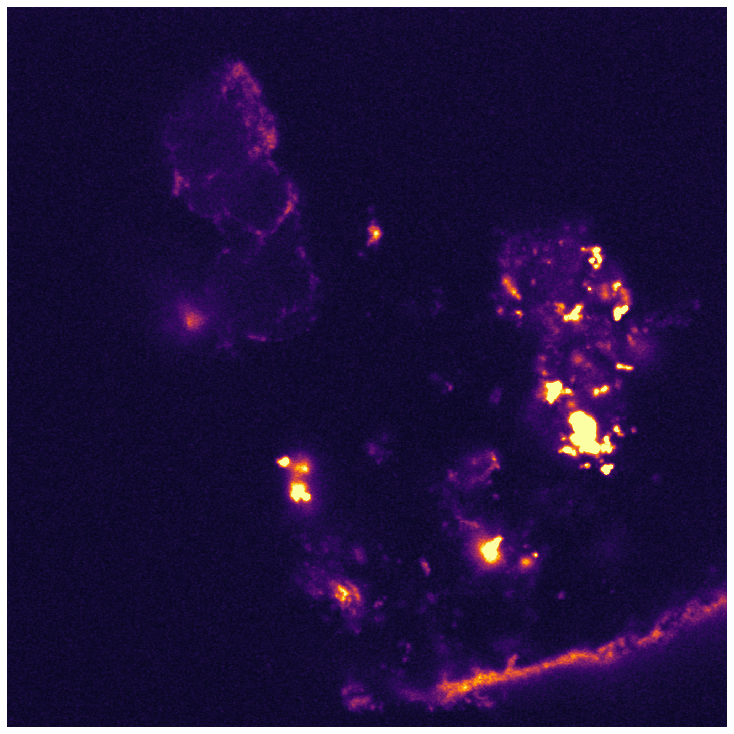

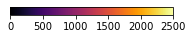

In [35]:
ip.plot_image(im[:,:,0], cmap='inferno',clims=[0,2500], im_inches=10)

Visualize spots

(<Figure size 720x720 with 1 Axes>,
 <Axes:>,
 [<Figure size 720x72 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7ff855e1f220>])

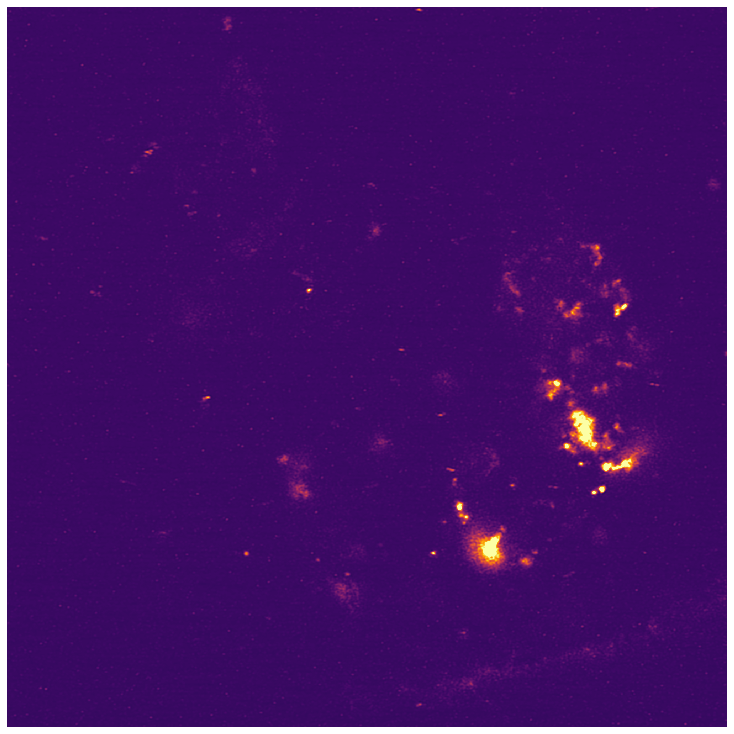

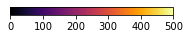

In [27]:
im_spot = im[:,:,1]
ip.plot_image(im_spot, cmap='inferno',clims=[0,500], im_inches=10)

## Measure SNR
Get stats

In [30]:
med = np.median(im_spot)
mx = np.max(im_spot)
mn = np.min(im_spot)
std = np.std(im_spot)
mean = np.mean(im_spot)
print(
    'med',med,
    'mx',mx,
    'mn',mn,
    'std',std,
    'mean',mean
)

med 93.0 mx 1055 mn 71 std 27.56839012957128 mean 97.37628033753066


Pick background

bg_thresh 175.70517038871384


(<Figure size 720x720 with 1 Axes>, <Axes:>, [[], []])

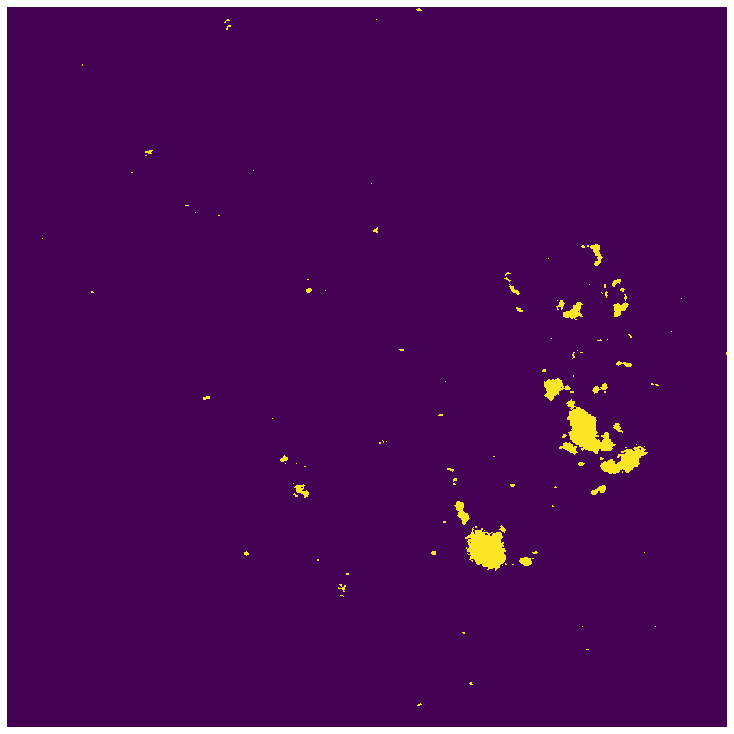

In [34]:
nstds = 3
bg_thresh = med + nstds*std
print('bg_thresh',bg_thresh)
mask = im_spot > bg_thresh
ip.plot_image(mask, im_inches=10)

Get mask properties and pick a threshold

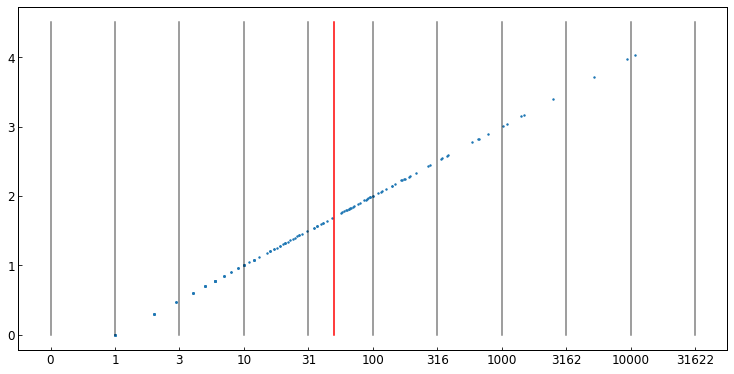

In [60]:
mask_lab = label(mask)
mask_props = sf.measure_regionprops(mask_lab, raw=im_spot)
fig, ax = ip.general_plot(dims=(10,5))
ax.scatter(np.log10(mask_props.area), np.log10(mask_props.area), s=2)
xticks = ax.get_xticks()
ax.set_xticks(xticks, labels=[int(10**x) for x in xticks])
for x in xticks:
    ax.plot([x,x], [0,max(xticks)], 'k', alpha=0.5)

thresh_area = 50
ax.plot([np.log10(thresh_area)]*2, [0,max(xticks)], 'r')


Filter large blobs

(54, 2)


(<Figure size 720x720 with 1 Axes>, <Axes:>, [[], []])

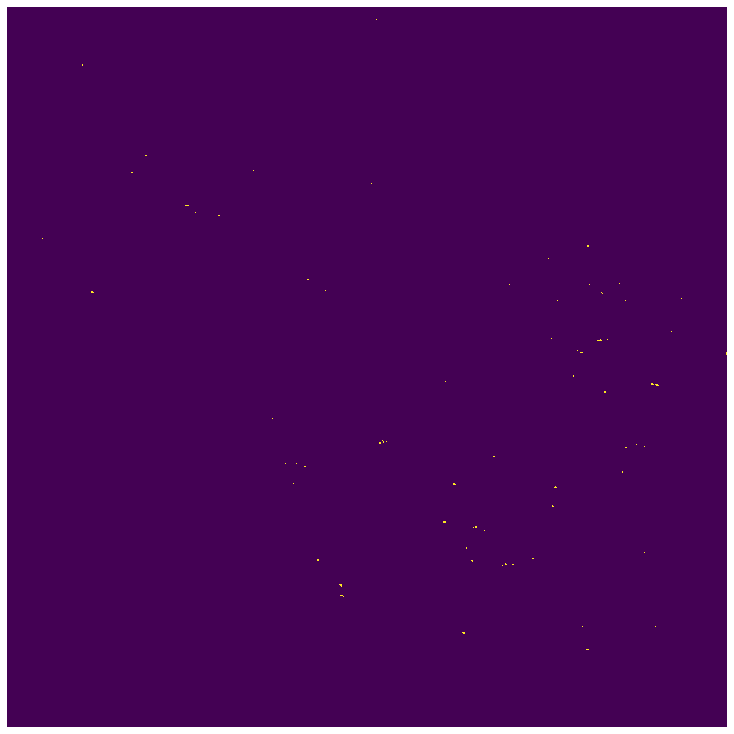

In [64]:
mask_props['filt_area'] = (mask_props.area < thresh_area)*1
mask_area = ip.filter_seg_objects(mask_lab, mask_props, 'filt_area')
ip.plot_image(mask_area>0, im_inches=10)

Measure signal and noise

In [66]:
noise = np.mean(im_spot * ~mask)
print('noise',noise)
signal = mask_props.loc[mask_props['filt_area'] == 1, 'max_intensity'].mean()
print('signal',signal)

noise 94.1474658348826
signal 190.66666666666666


90


(0.0, 10.0)

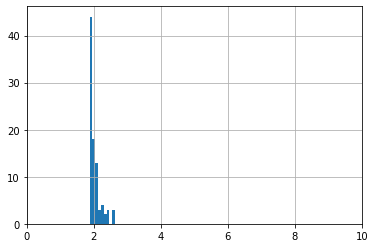

In [72]:
nspots = mask_props['filt_area'].sum()
print(nspots)
ax = (mask_props.loc[mask_props['filt_area'] == 1, 'max_intensity'] / noise).hist(bins=nspots//10)
ax.set_xlim(0,10)

## Plot spot SNR and counts for each fov

function

In [101]:
def count_spots(im_spot, nstds_bg=3, thresh_area=50, figsize=(10,5), snr=True, xlims=(0,10)):
    med = np.median(im_spot)
    std = np.std(im_spot)
    bg_thresh = med + nstds_bg*std
    mask = im_spot > bg_thresh
    mask_lab = label(mask)
    mask_props = sf.measure_regionprops(mask_lab, raw=im_spot)
    mask_props['filt_area'] = (mask_props.area < thresh_area)*1
    noise = np.mean(im_spot * ~mask)
    noise = 1 if noise == 0 else noise
    noise = noise if snr else 1
    nspots = mask_props['filt_area'].sum()
    if nspots > 0:
        bins = nspots//10 if nspots > 9 else 1
        ax = (mask_props.loc[mask_props['filt_area'] == 1, 'max_intensity'] / noise).hist(bins=bins, figsize=figsize)
        ax.set_xlim(xlims[0],xlims[1])
        plt.show()
        plt.close()
    else: 
        print('NO spots')
    return nspots / (im_spot.shape[0] * im_spot.shape[1])

def get_spot_im(im):
    im = np.squeeze(im)
    im = np.transpose(im, (1,2,0))
    return im[:,:,1]
    


Iterate through images

sample: slide_11_fov_01


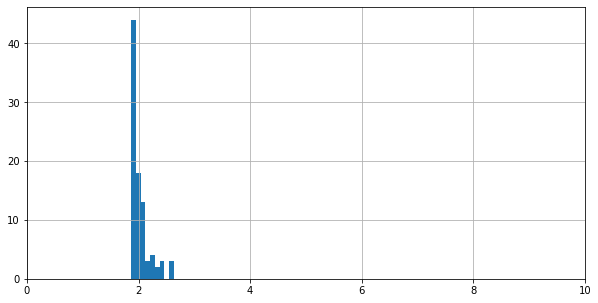

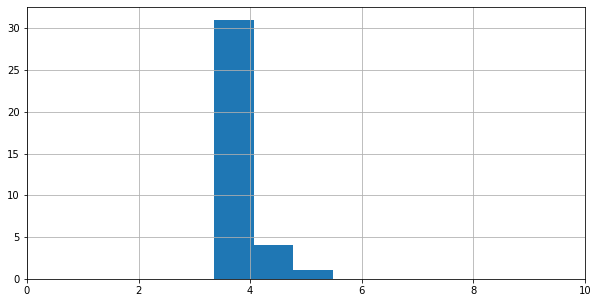

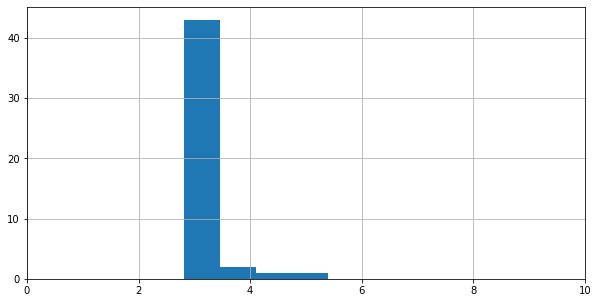

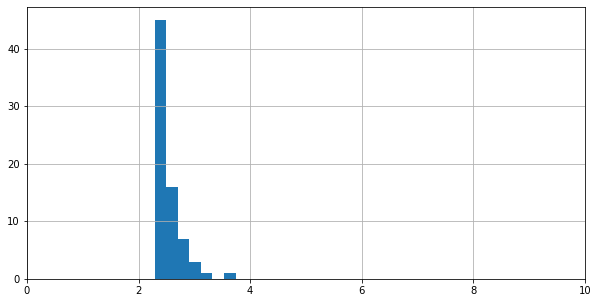

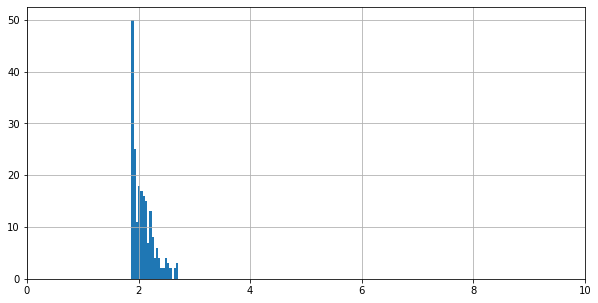

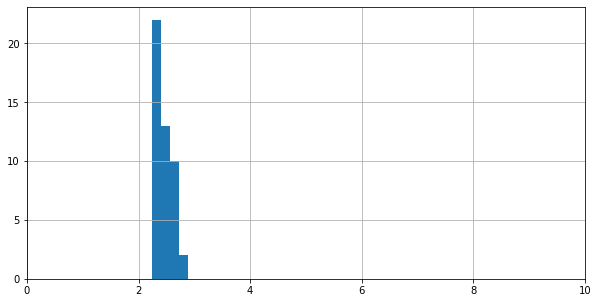

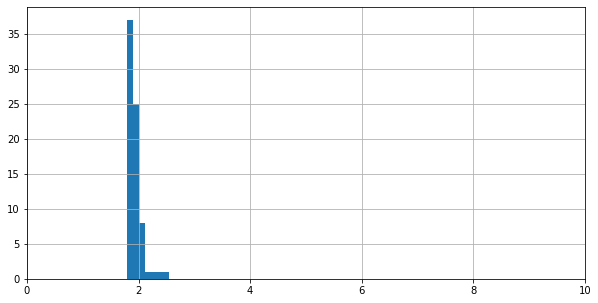

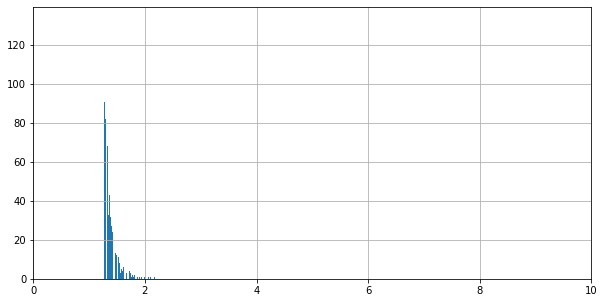

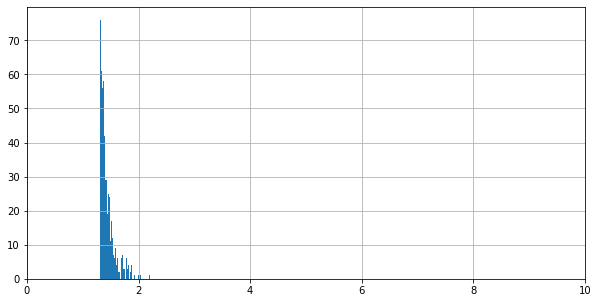

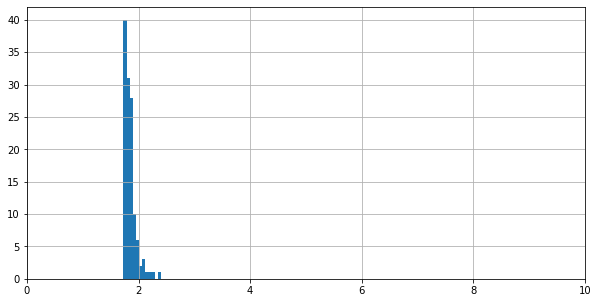

sample: slide_11_fov_02


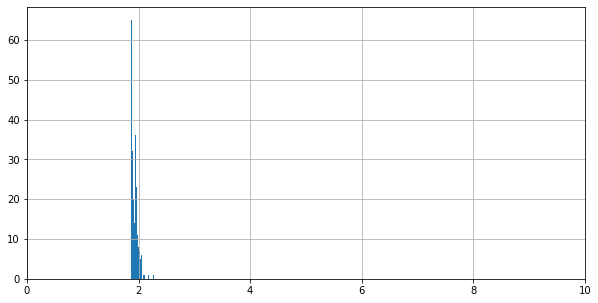

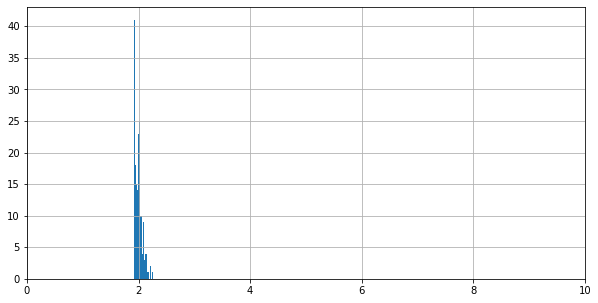

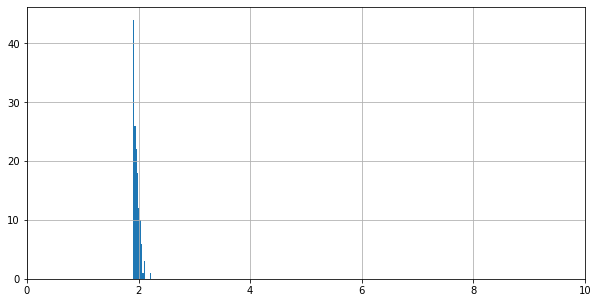

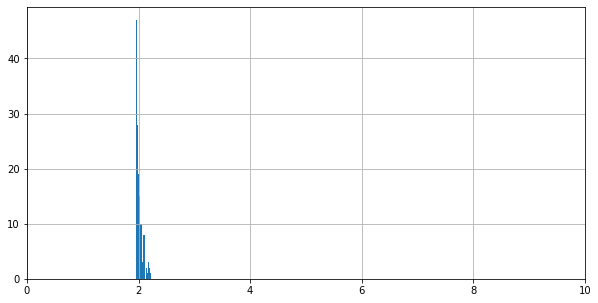

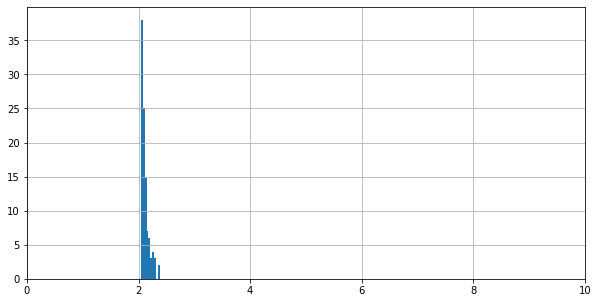

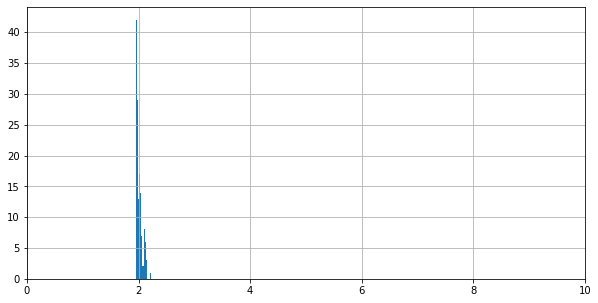

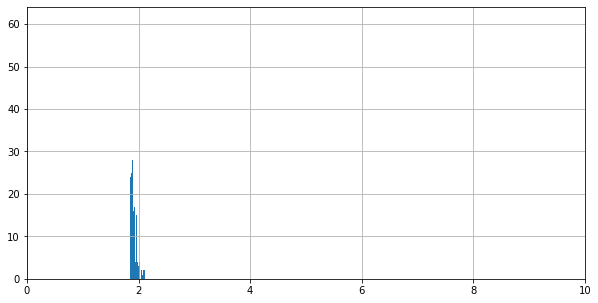

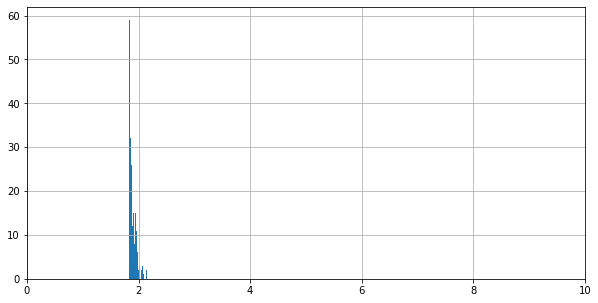

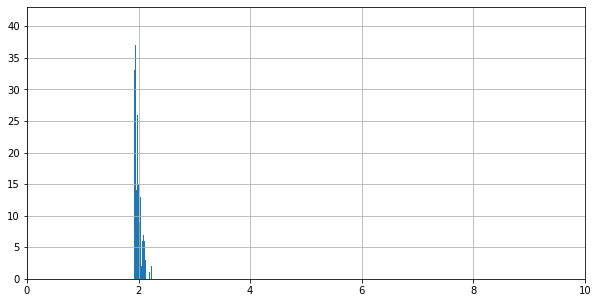

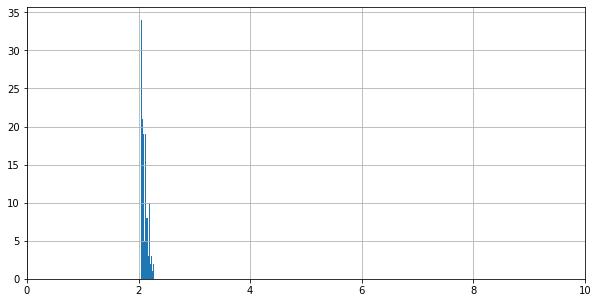

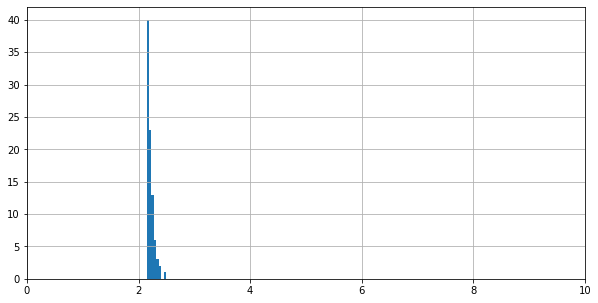

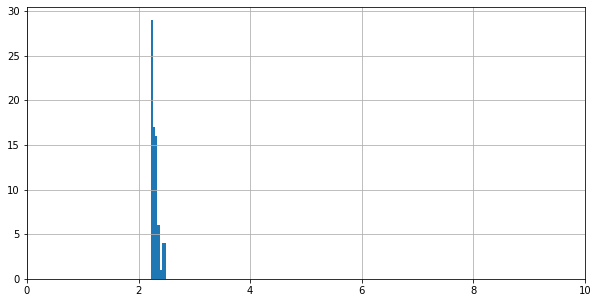

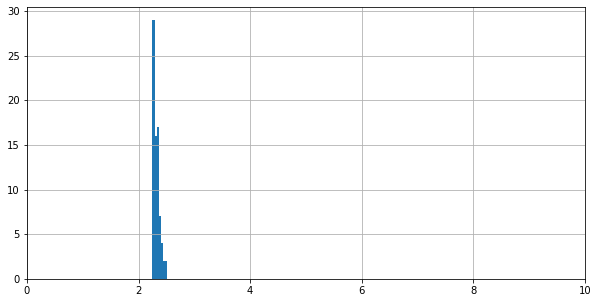

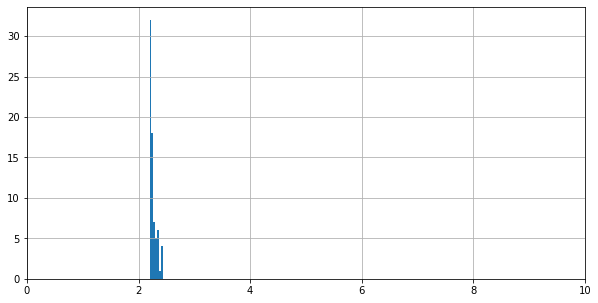

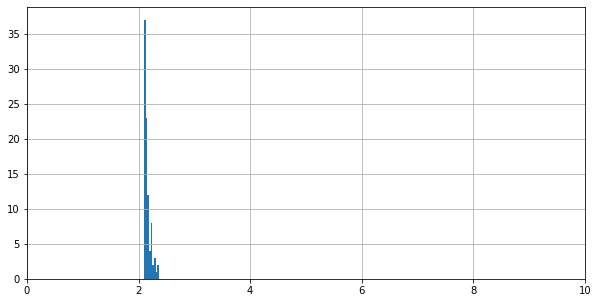

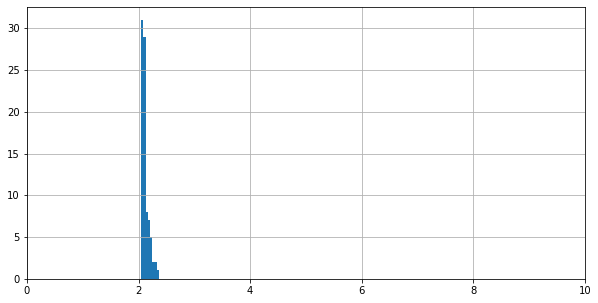

sample: slide_11_fov_03


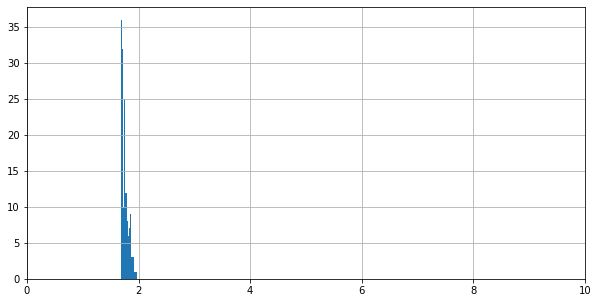

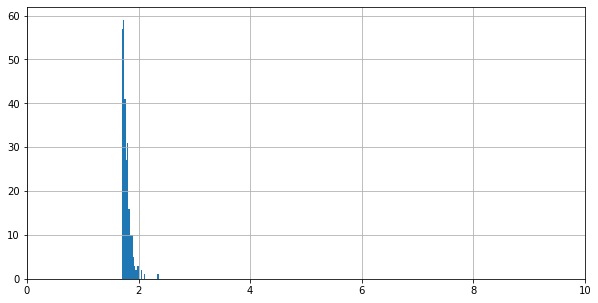

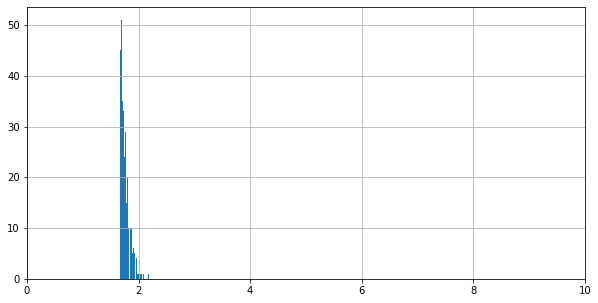

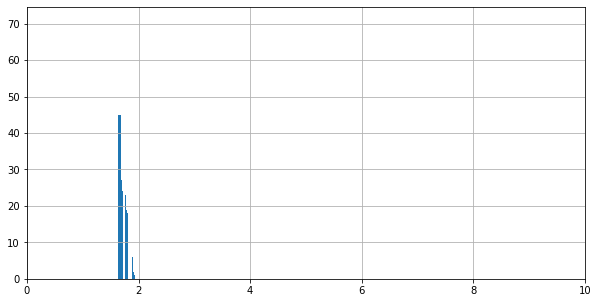

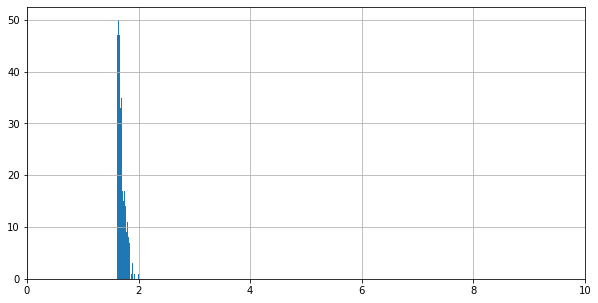

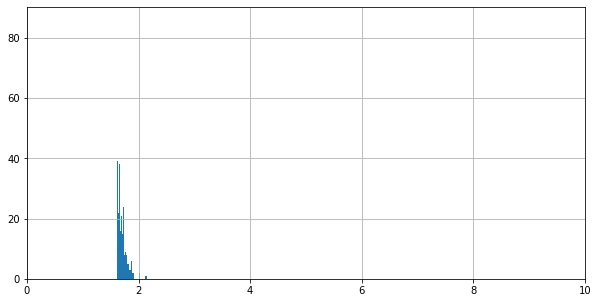

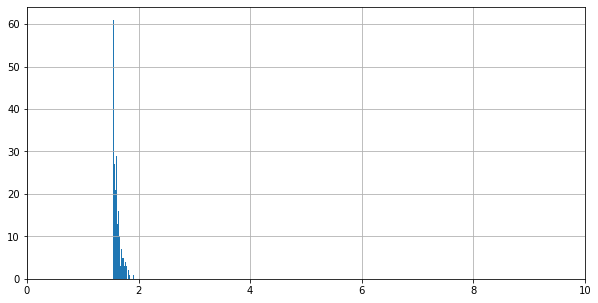

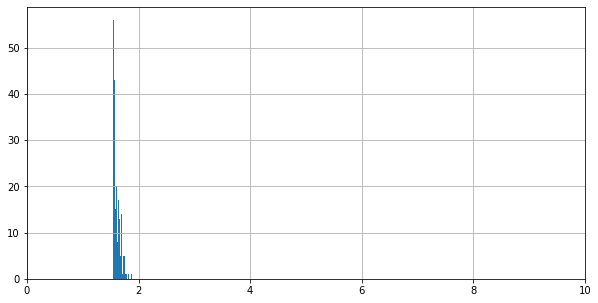

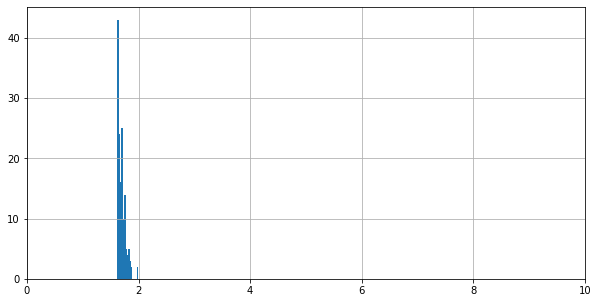

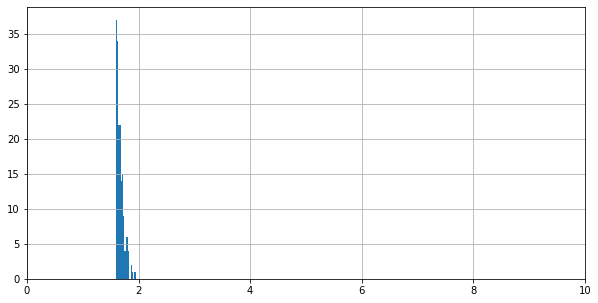

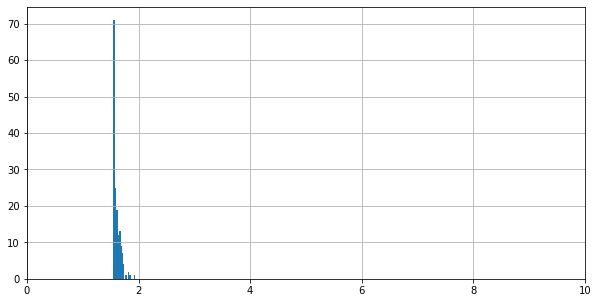

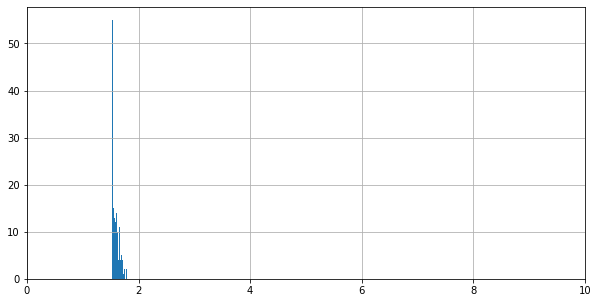

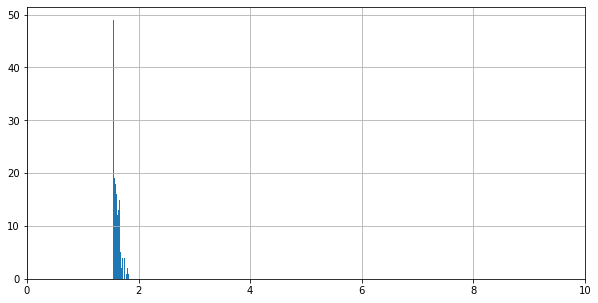

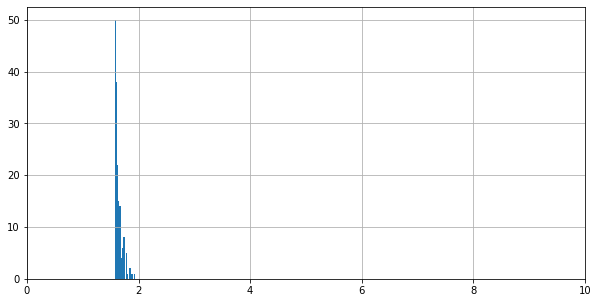

sample: slide_14_fov_02


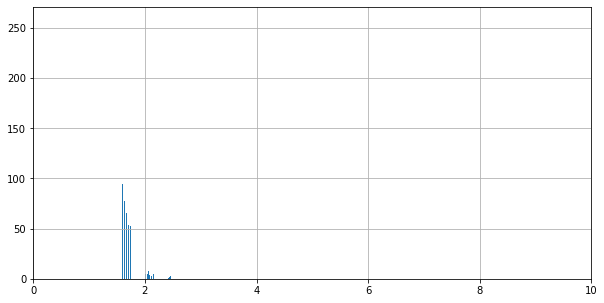

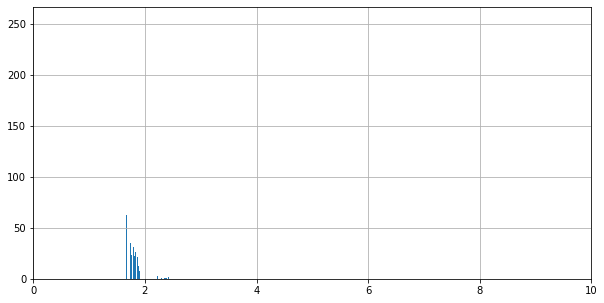

sample: slide_11_fov_04


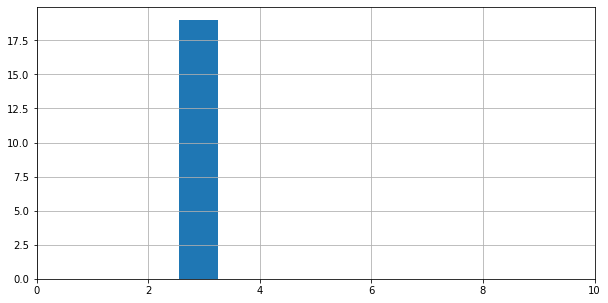

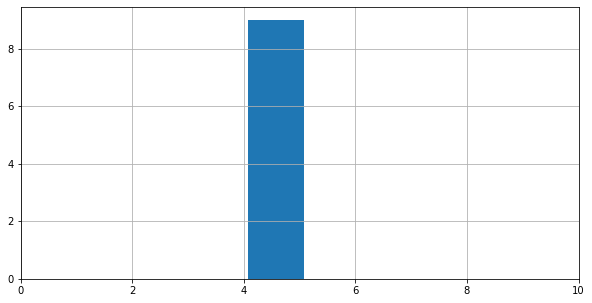

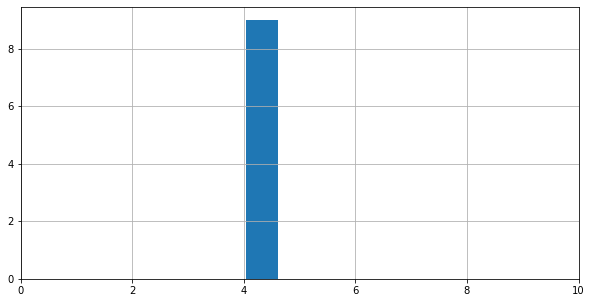

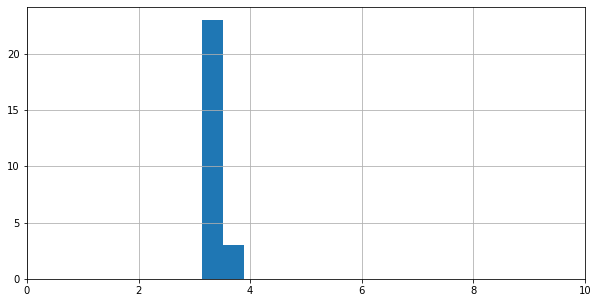

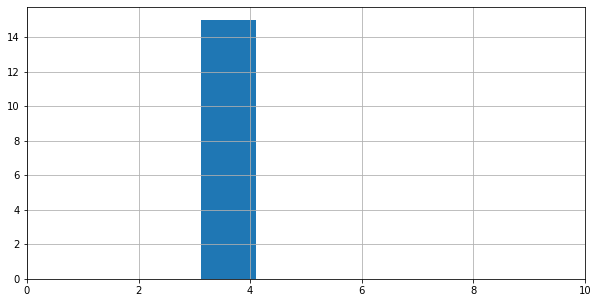

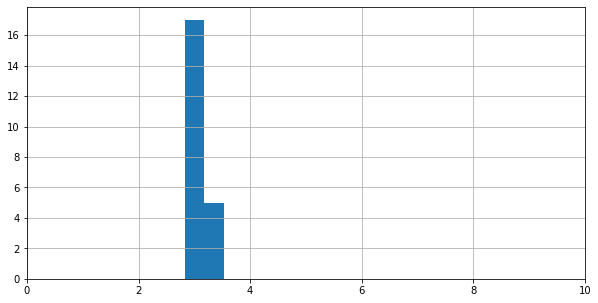

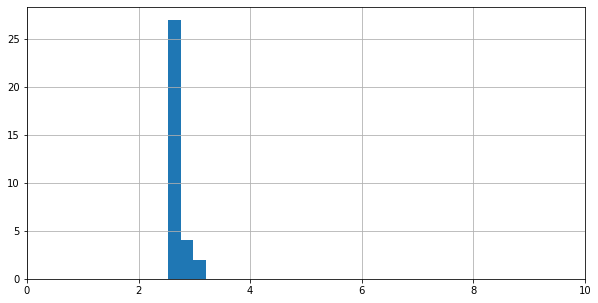

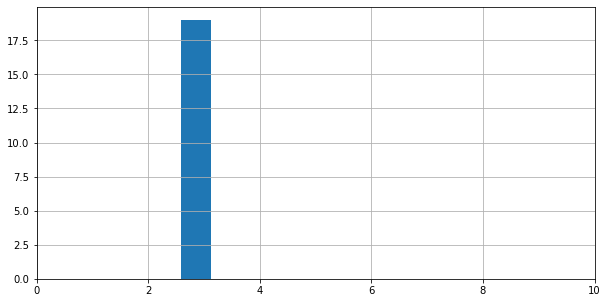

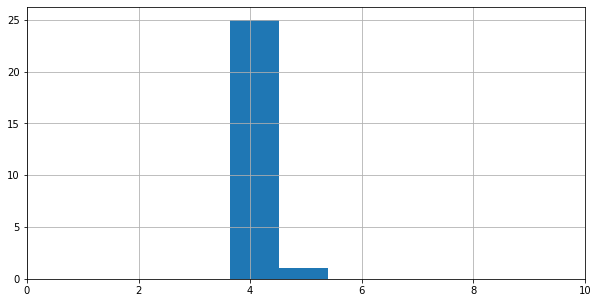

NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots


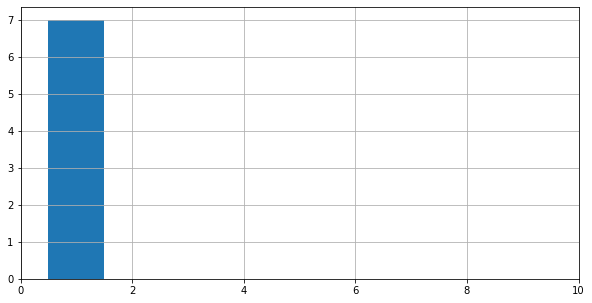

sample: slide_11_fov_05


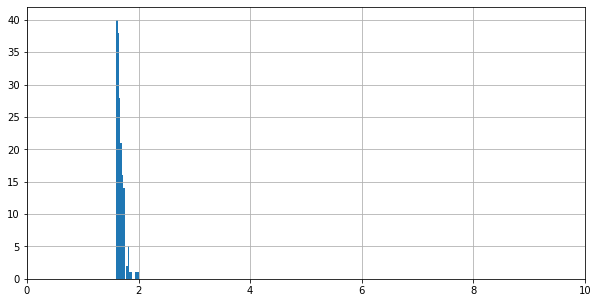

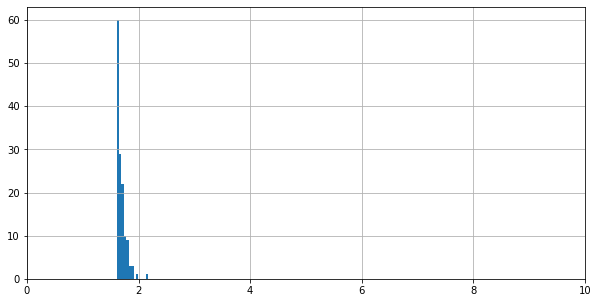

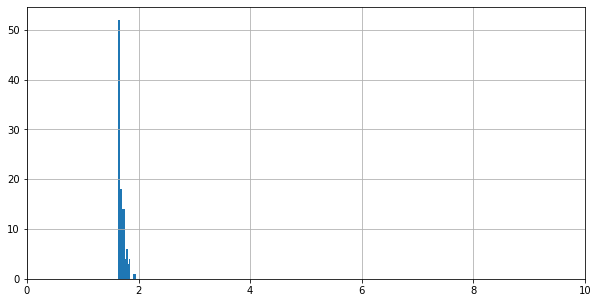

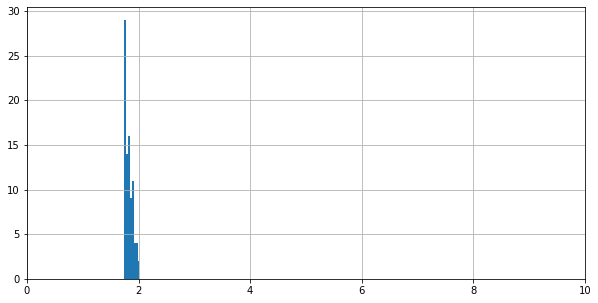

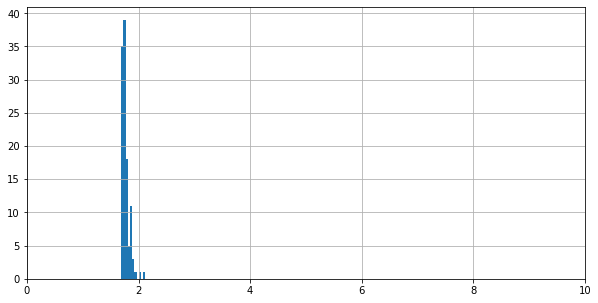

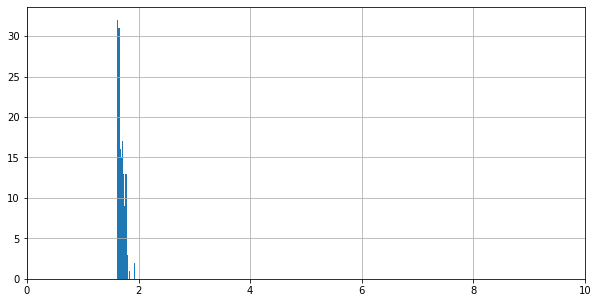

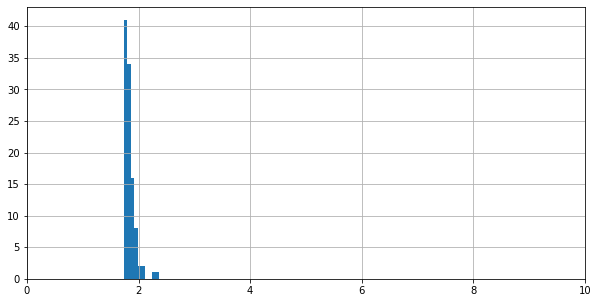

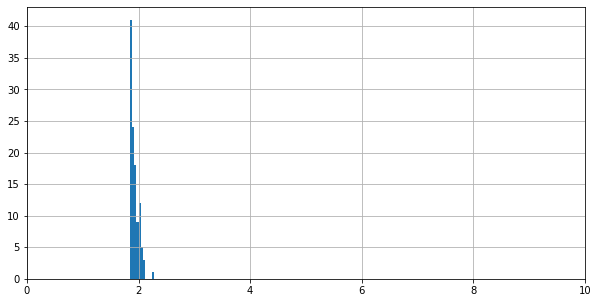

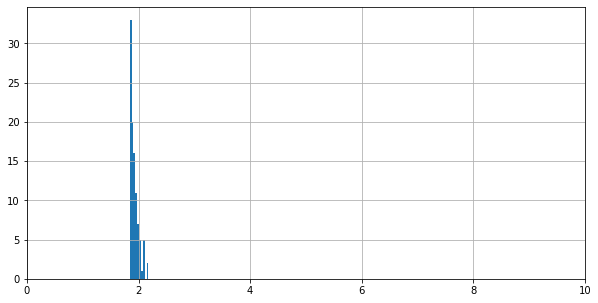

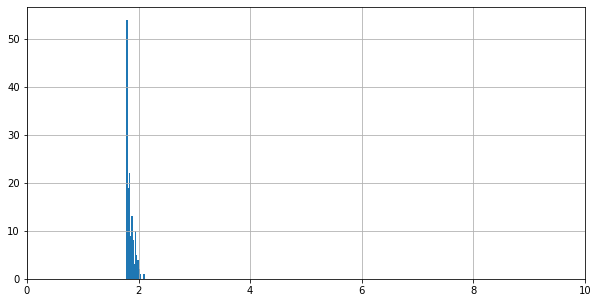

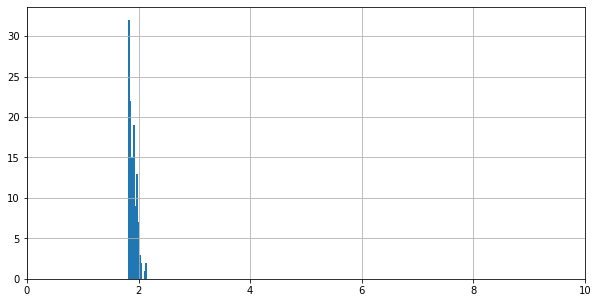

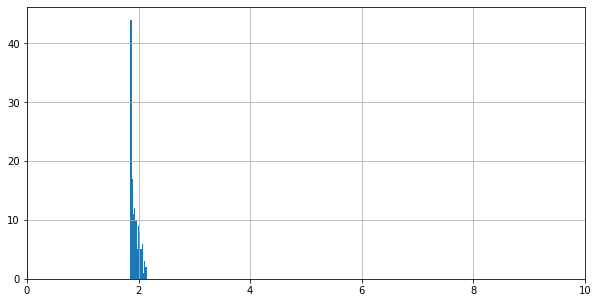

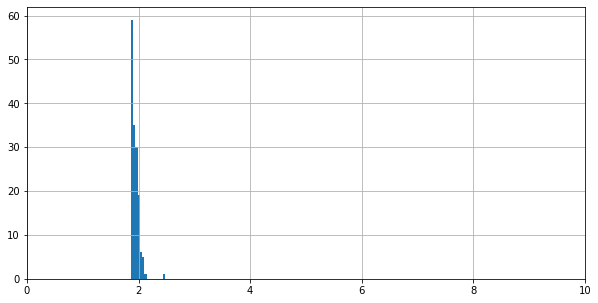

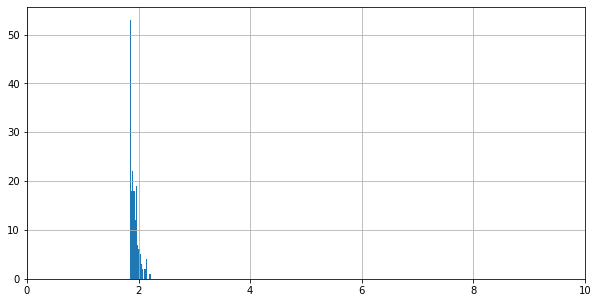

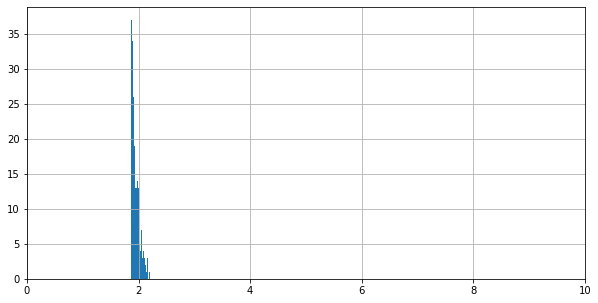

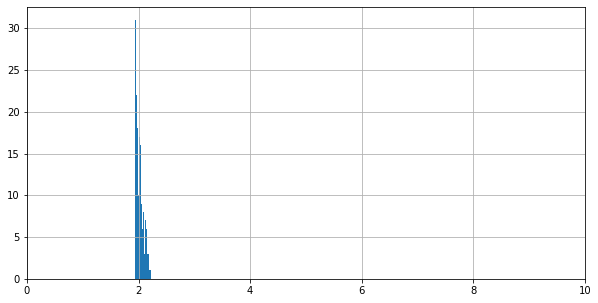

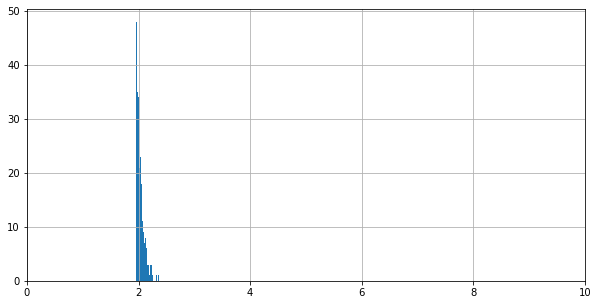

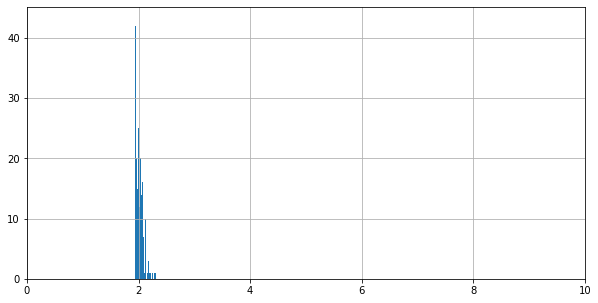

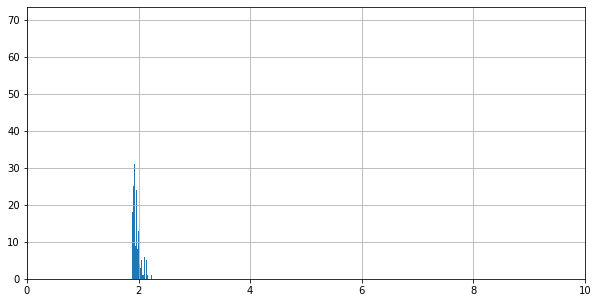

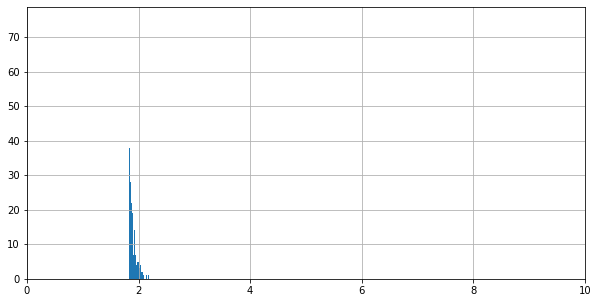

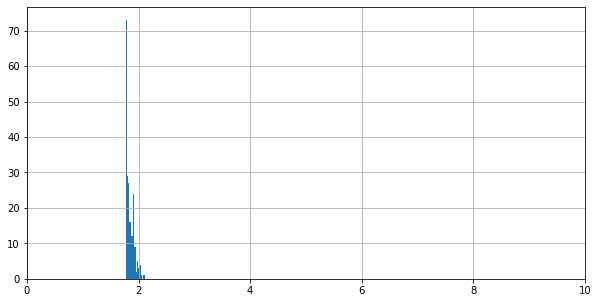

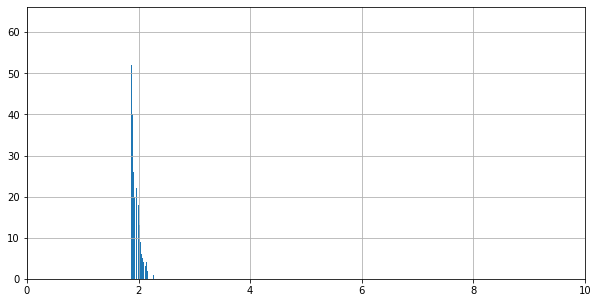

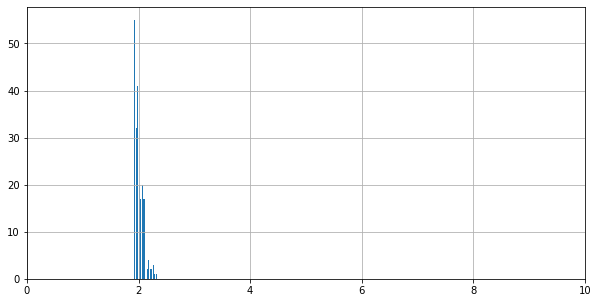

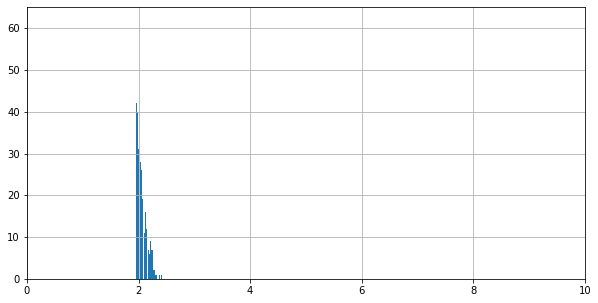

sample: slide_11_fov_06


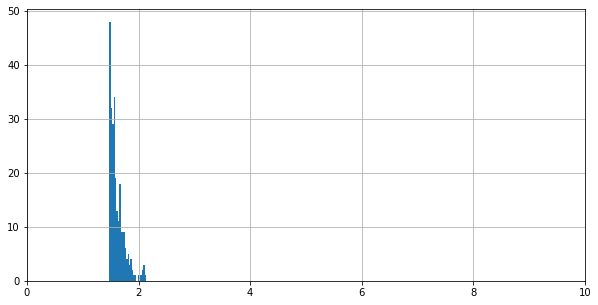

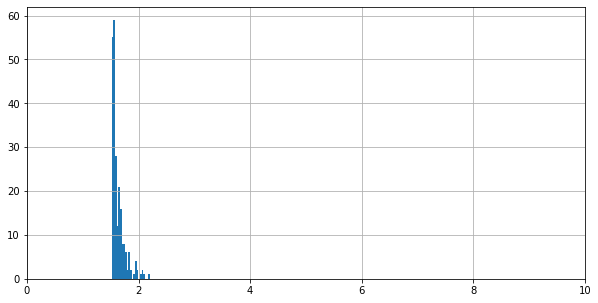

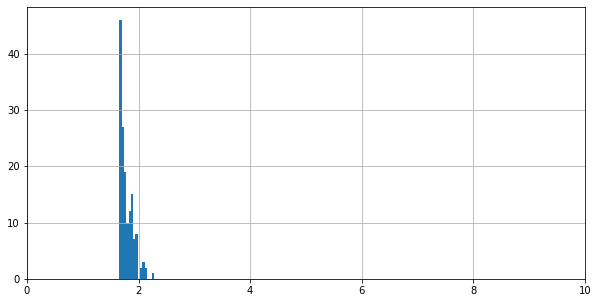

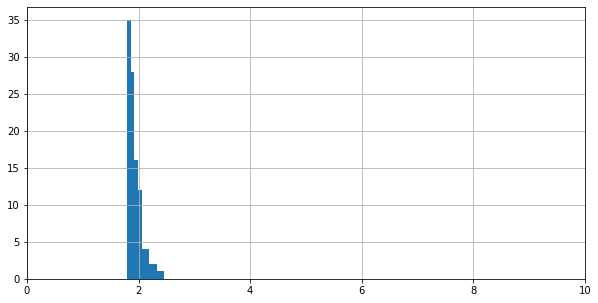

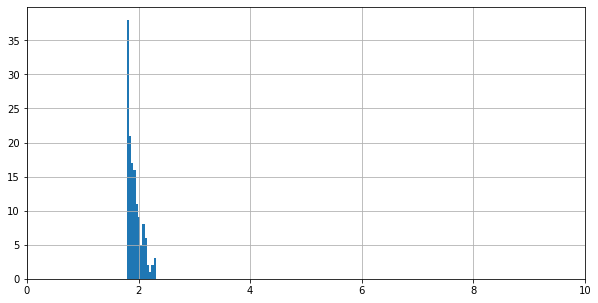

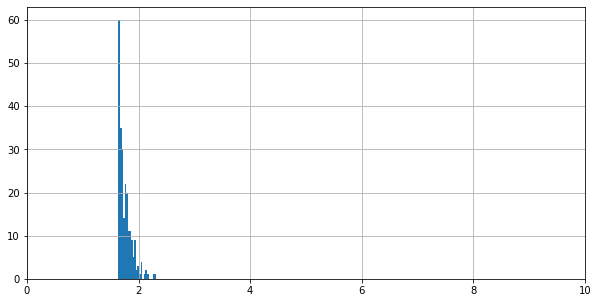

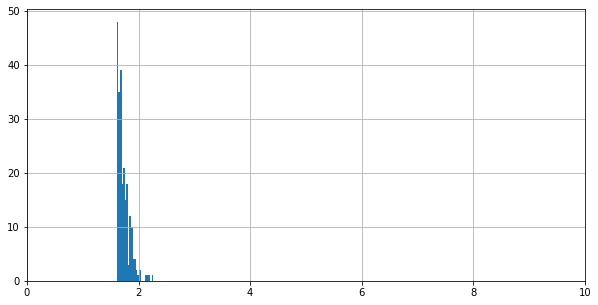

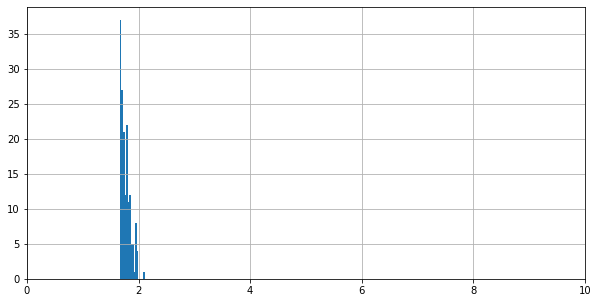

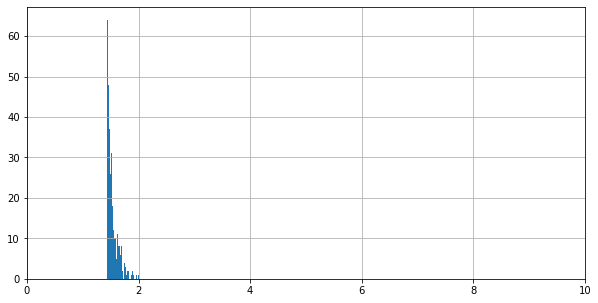

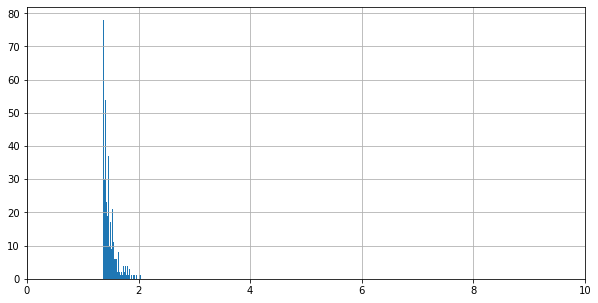

sample: slide_14_fov_01


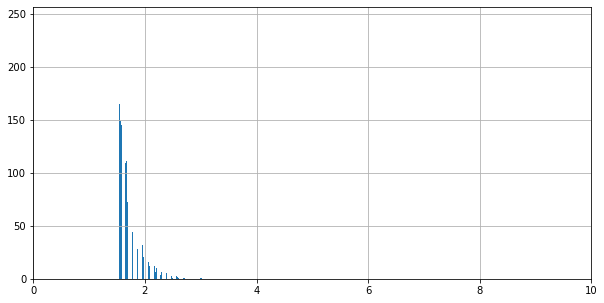

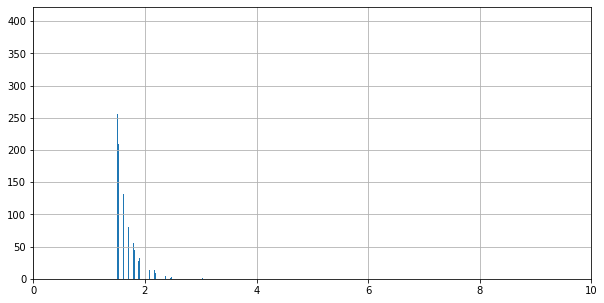

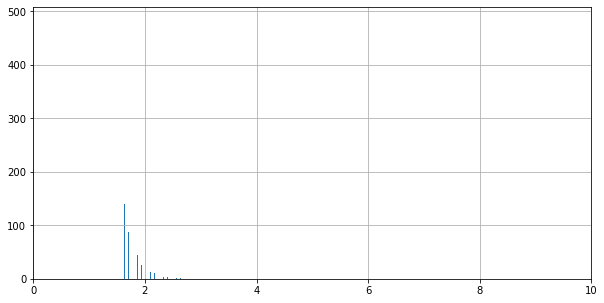

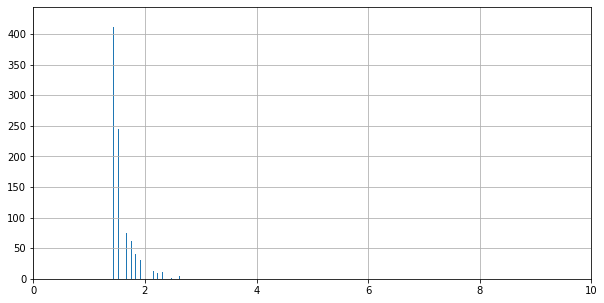

sample: slide_bmgsc_fov_01


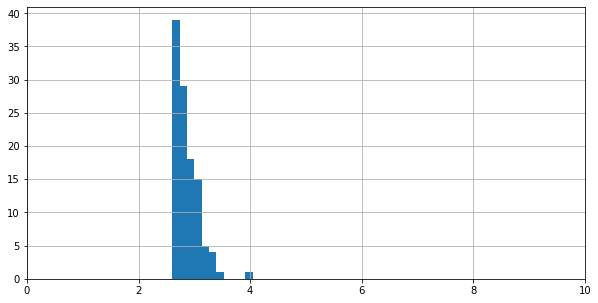

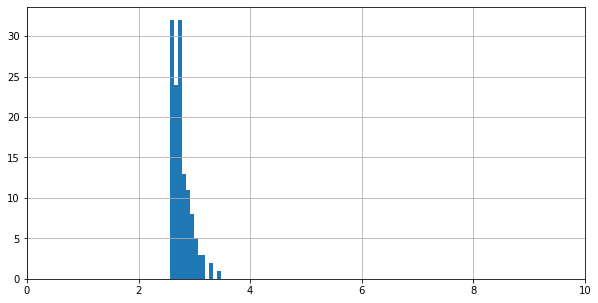

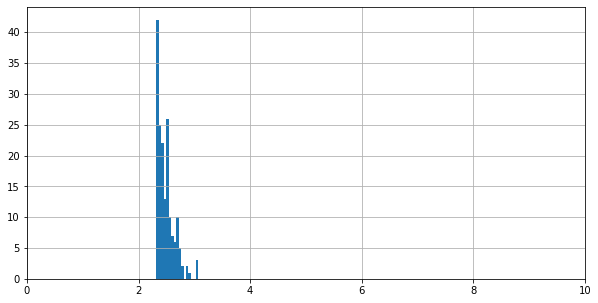

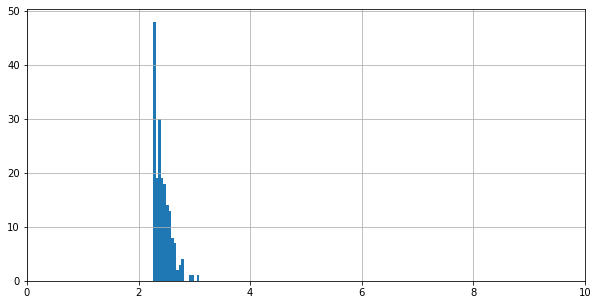

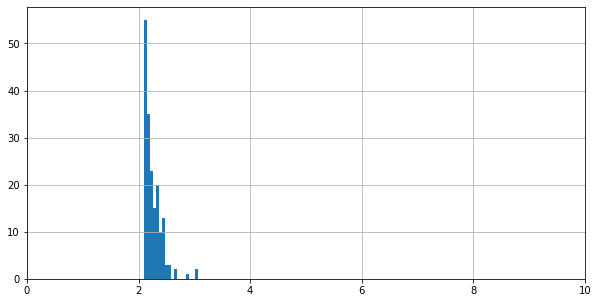

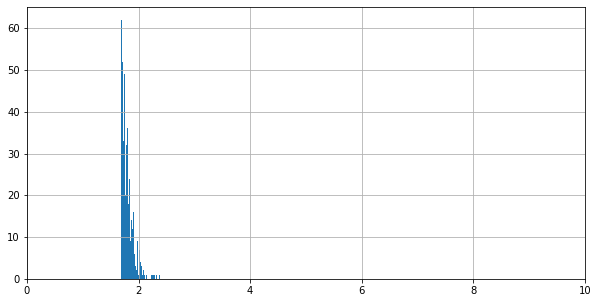

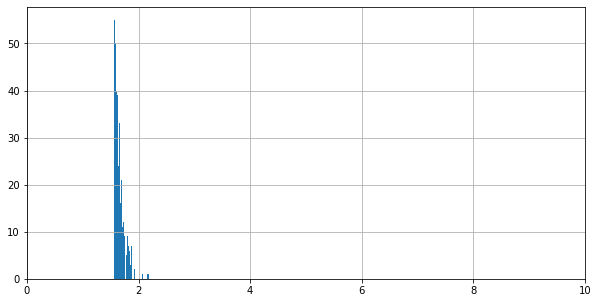

sample: slide_14_fov_03


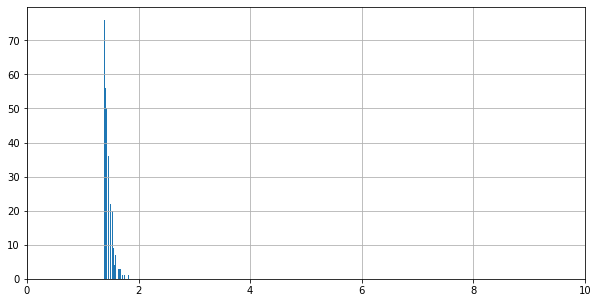

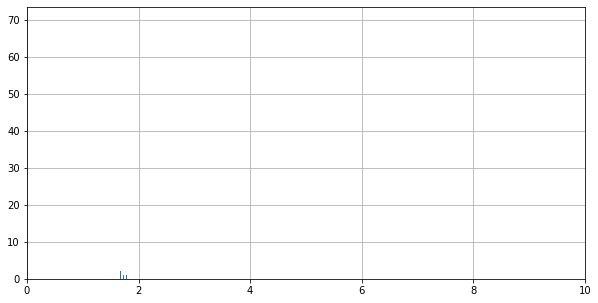

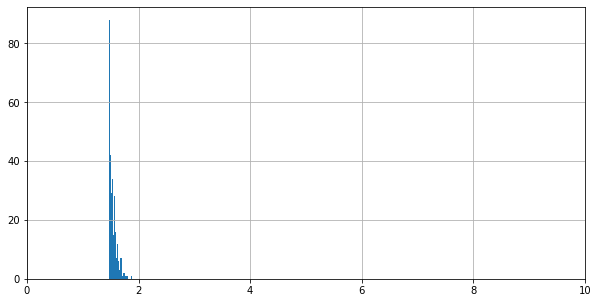

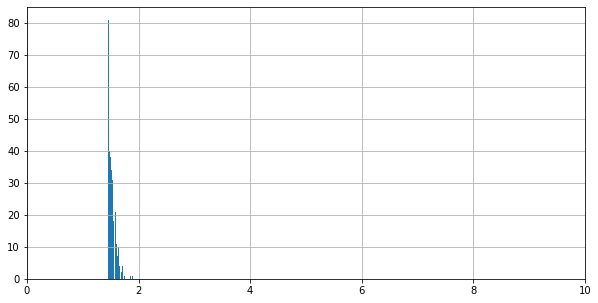

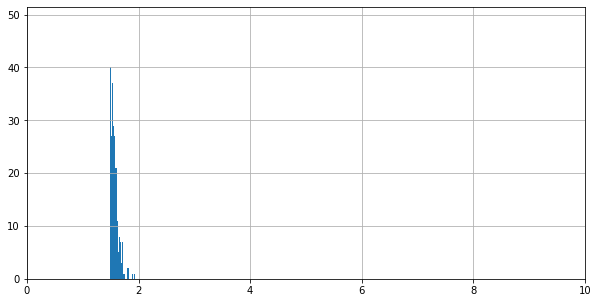

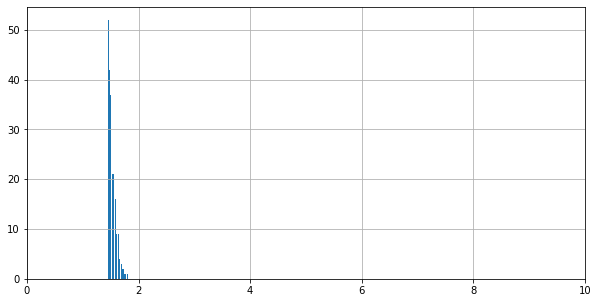

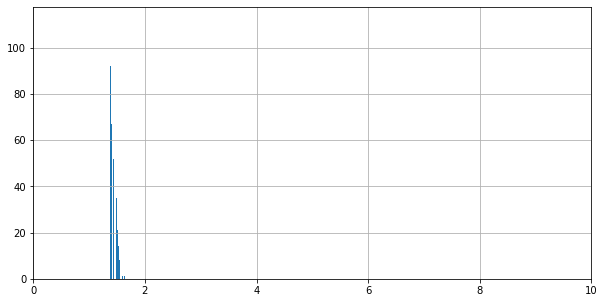

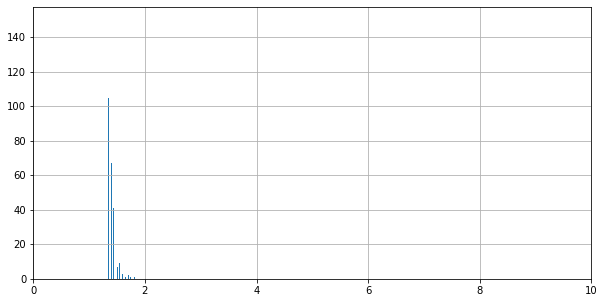

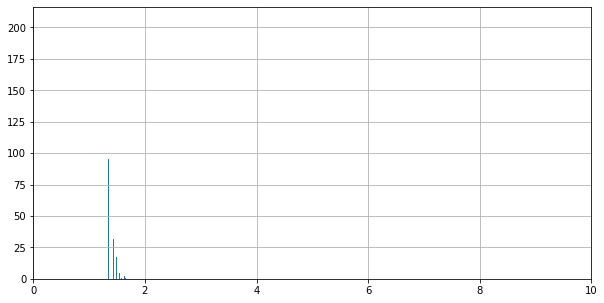

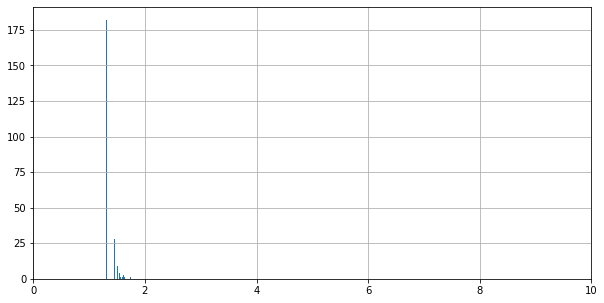

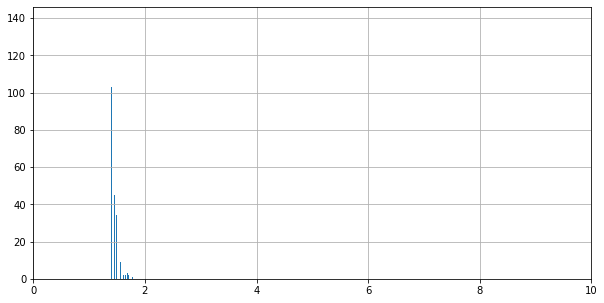

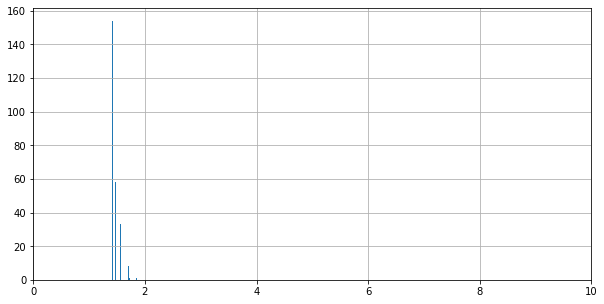

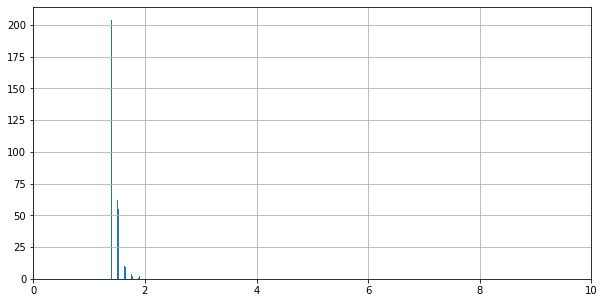

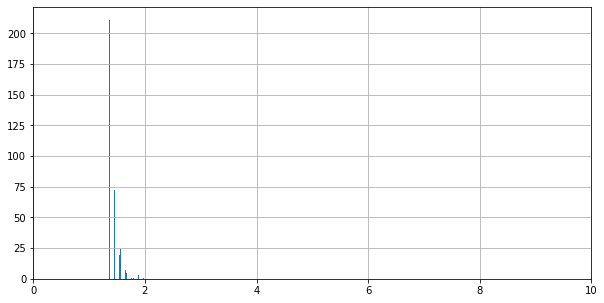

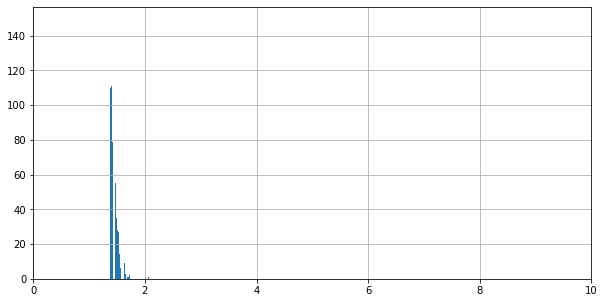

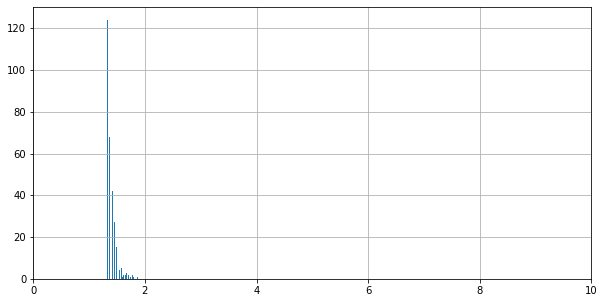

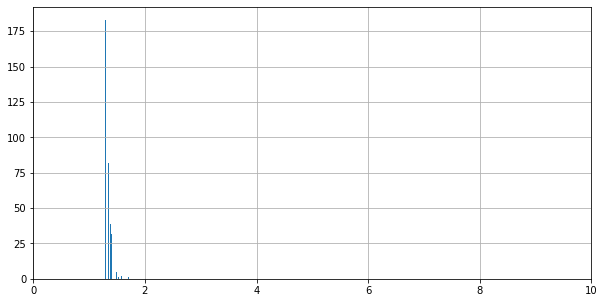

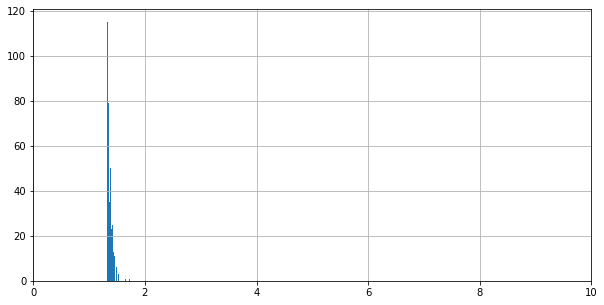

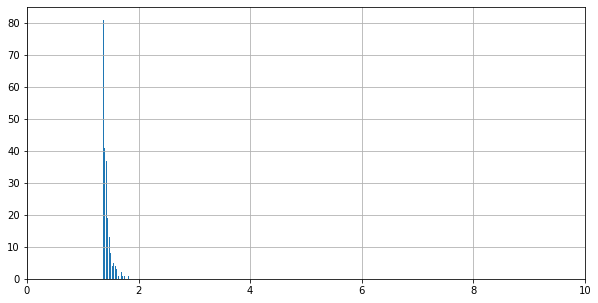

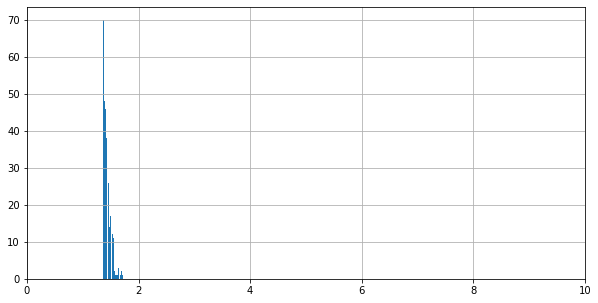

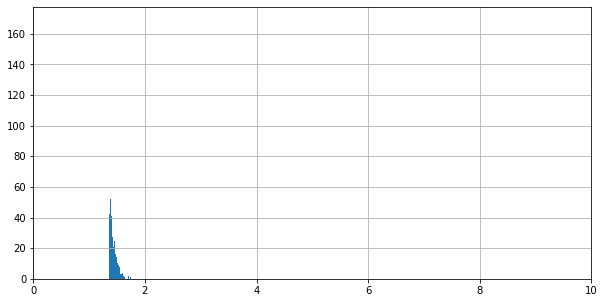

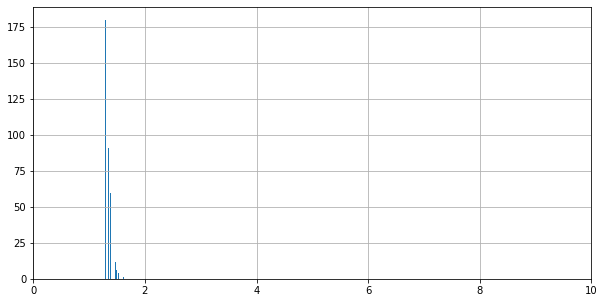

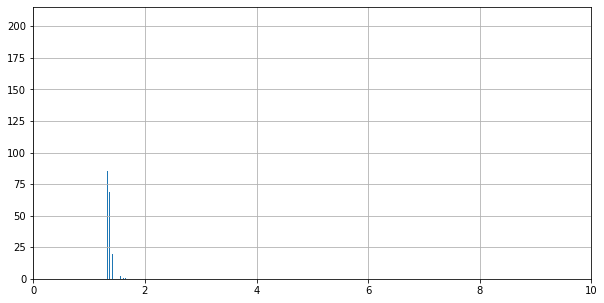

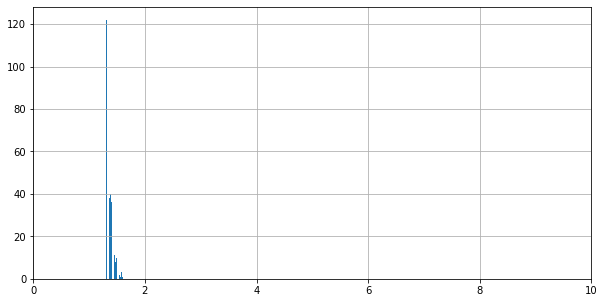

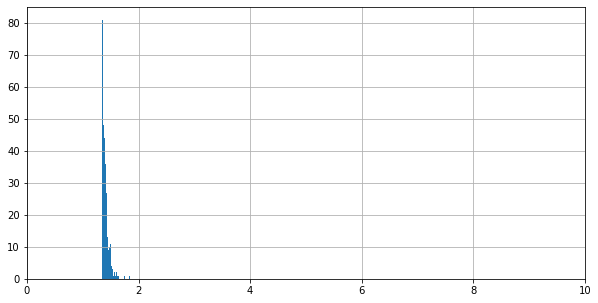

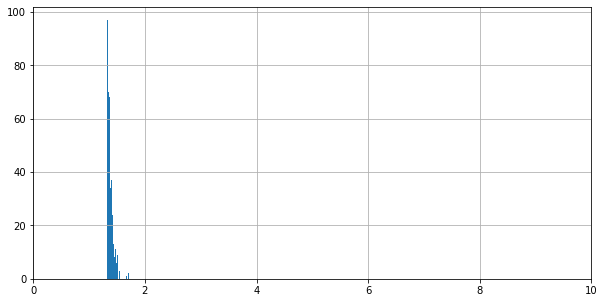

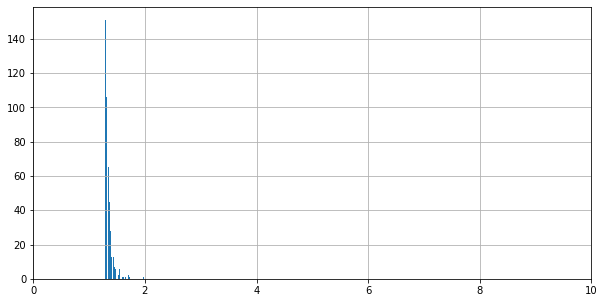

sample: slide_14_fov_05


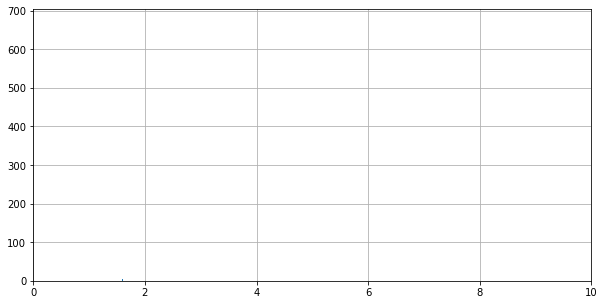

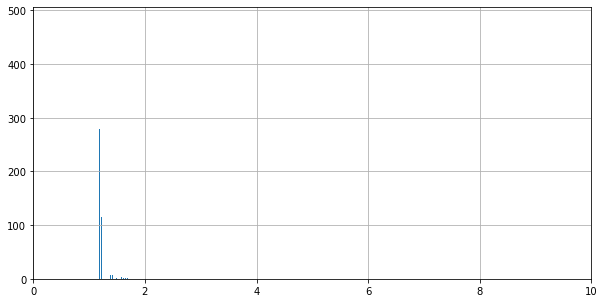

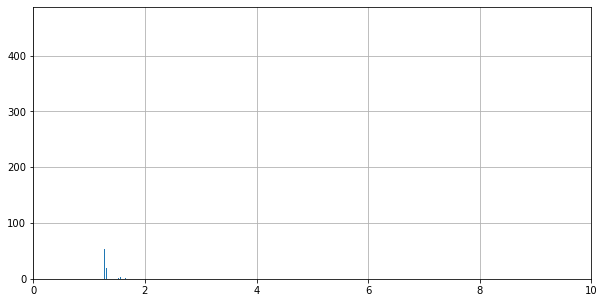

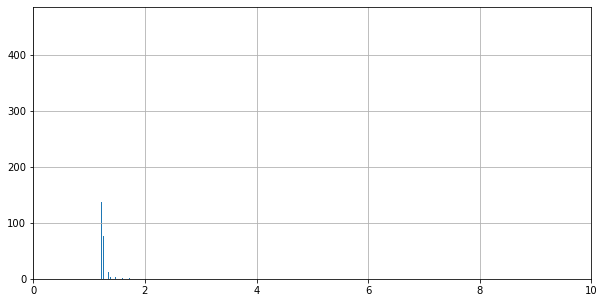

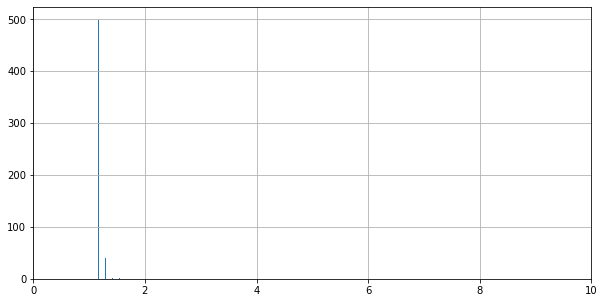

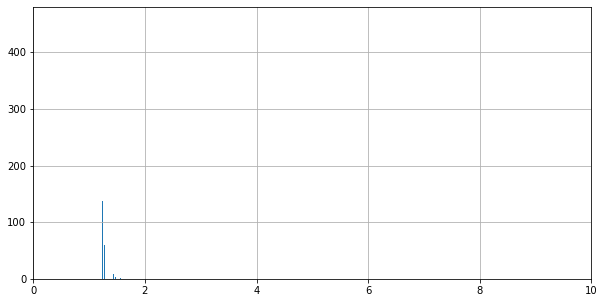

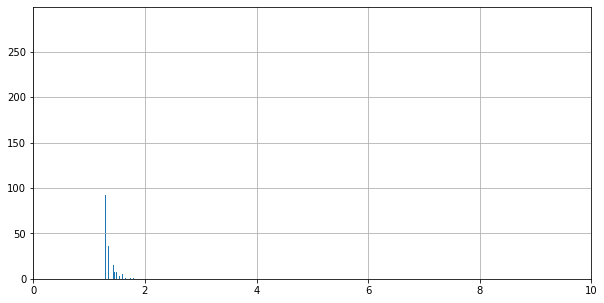

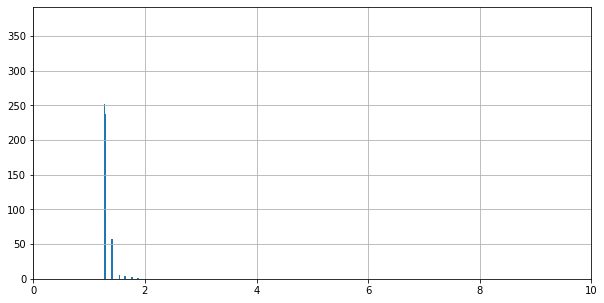

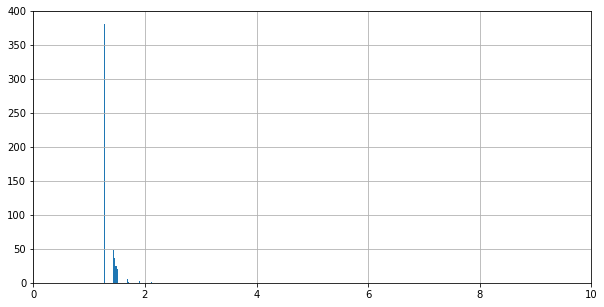

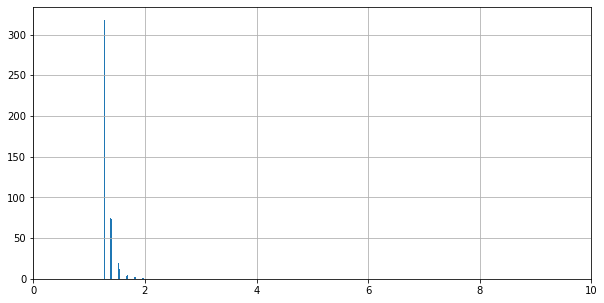

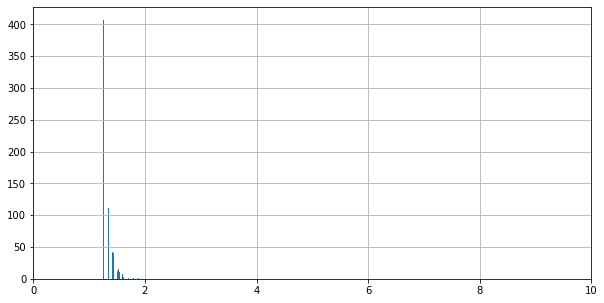

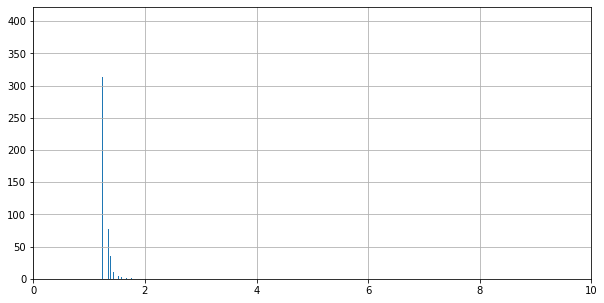

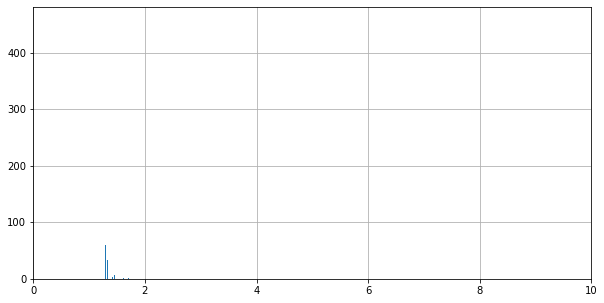

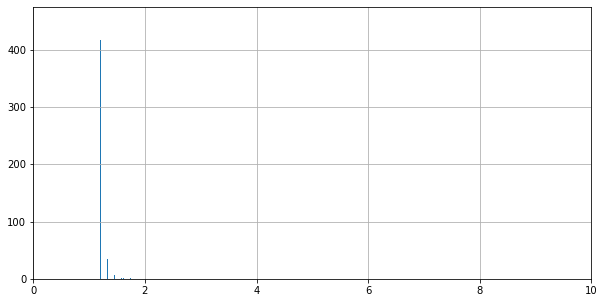

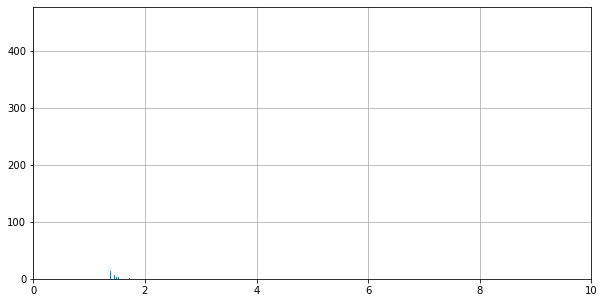

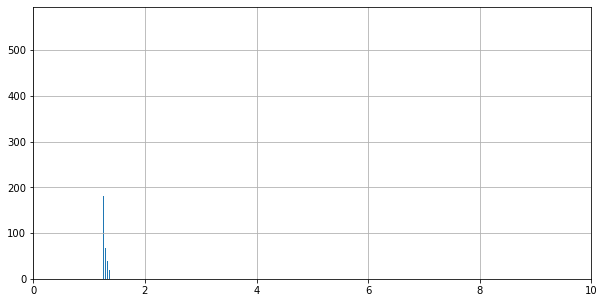

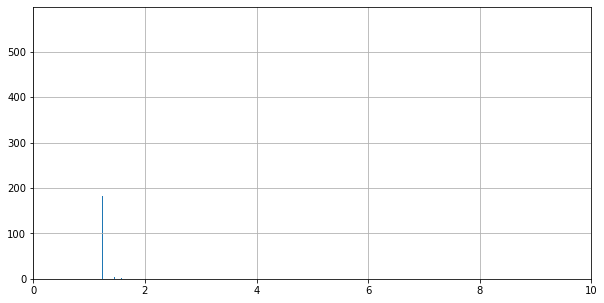

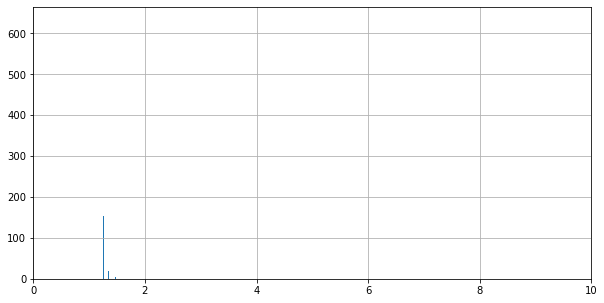

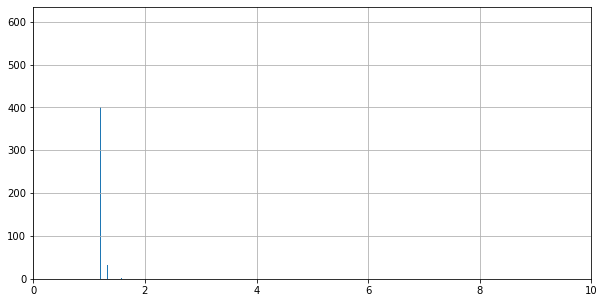

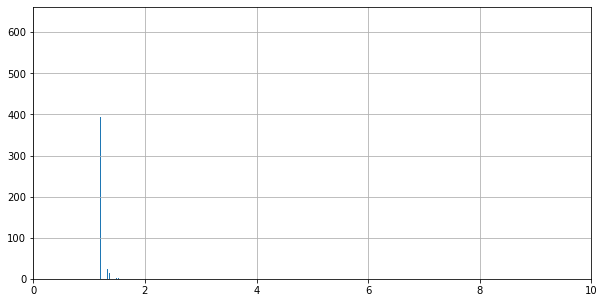

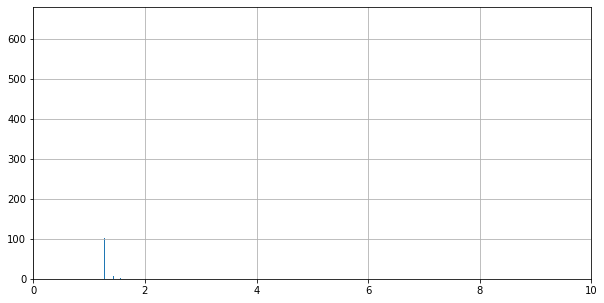

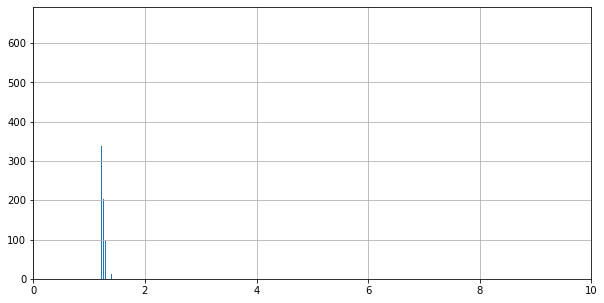

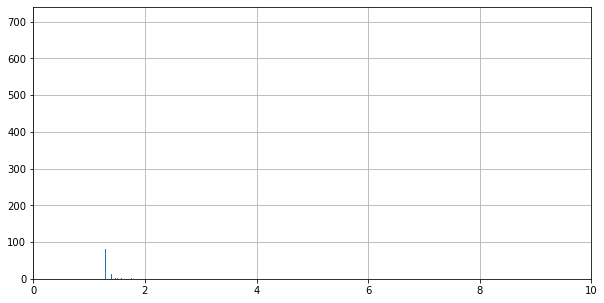

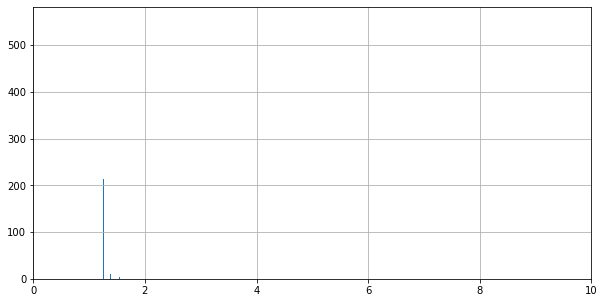

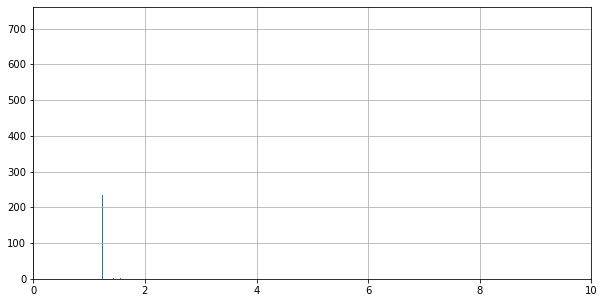

sample: slide_14_fov_06


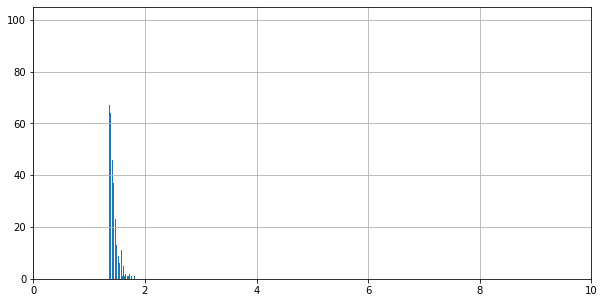

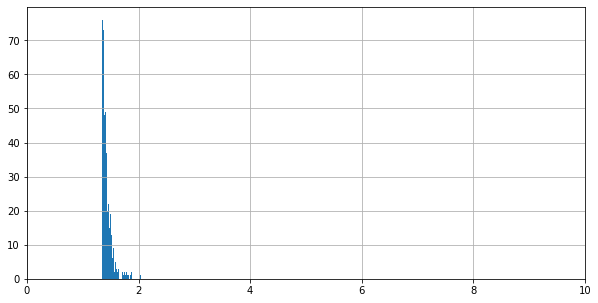

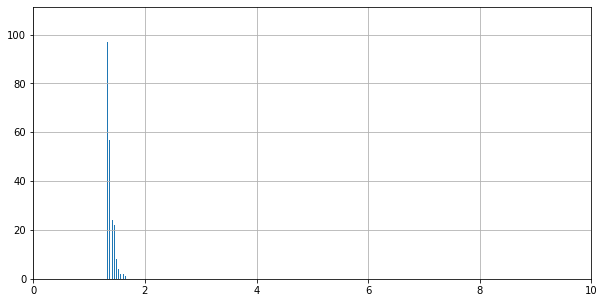

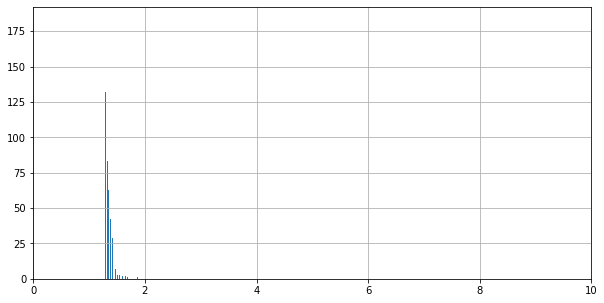

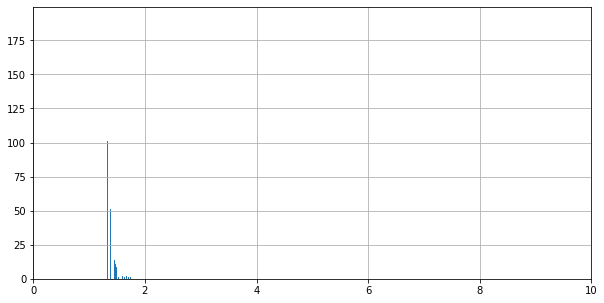

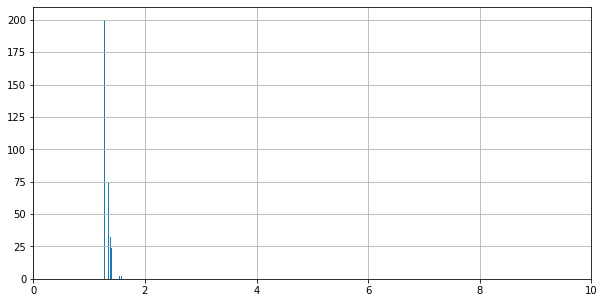

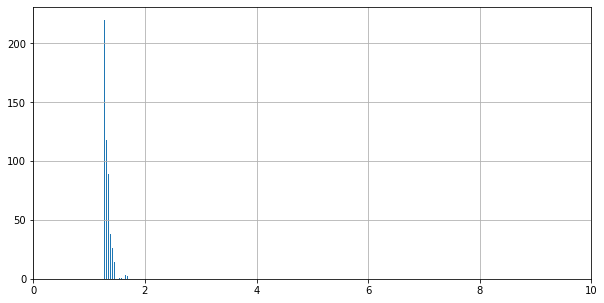

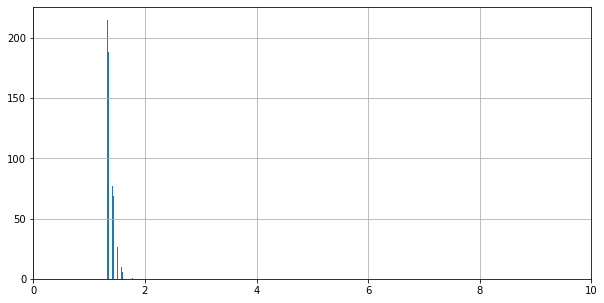

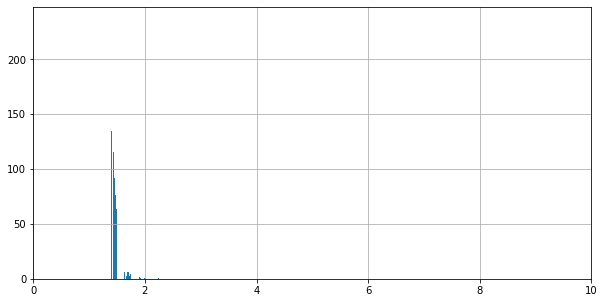

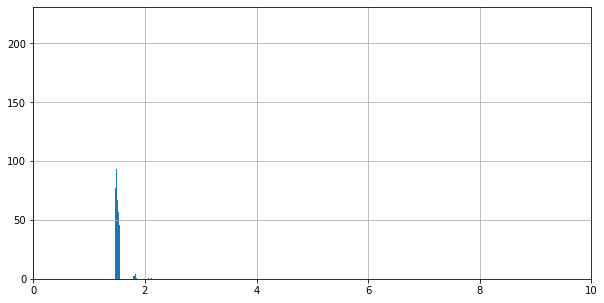

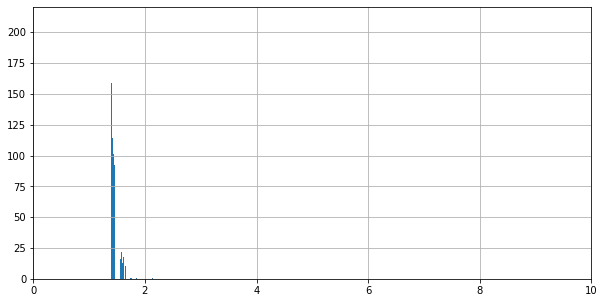

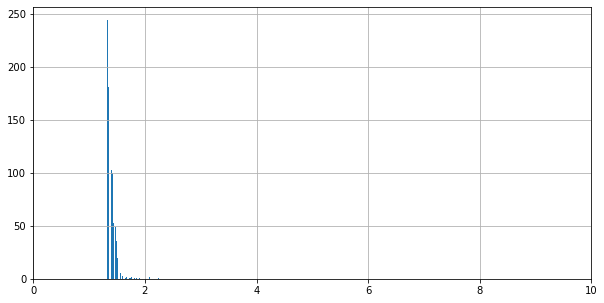

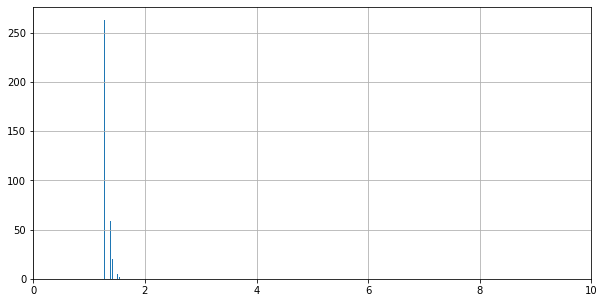

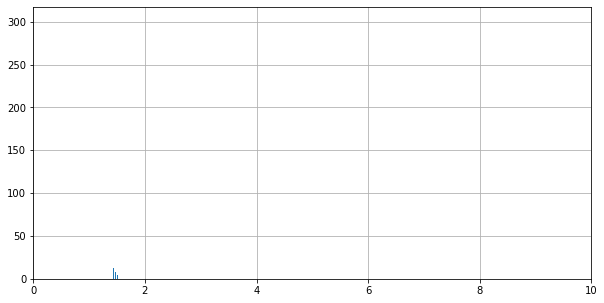

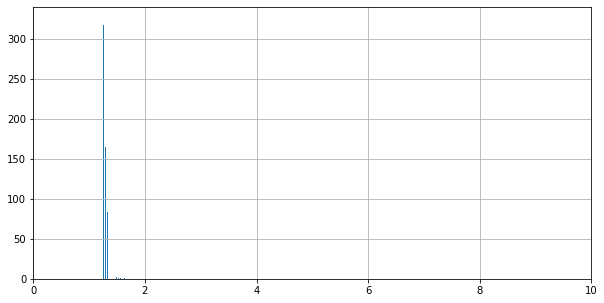

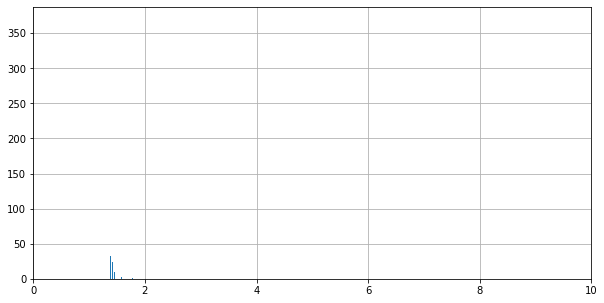

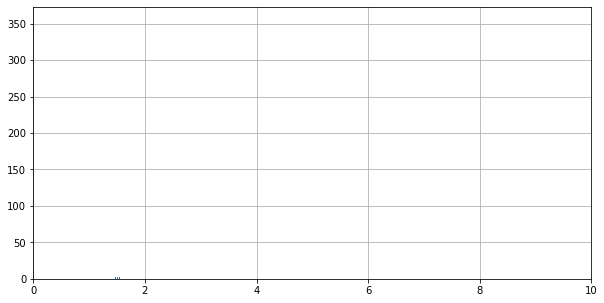

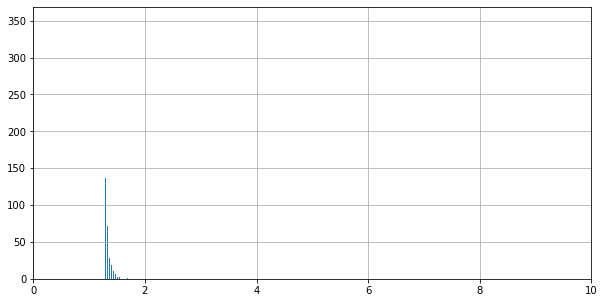

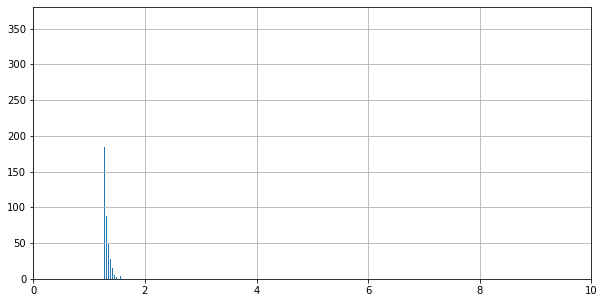

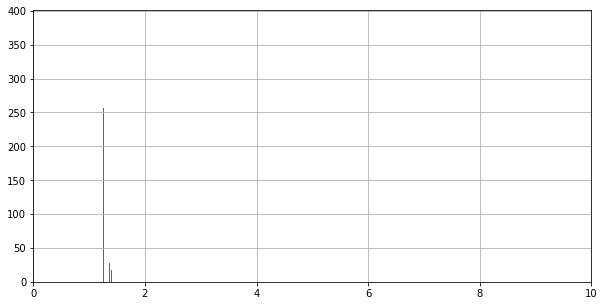

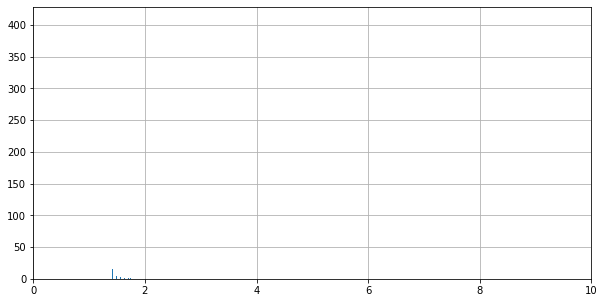

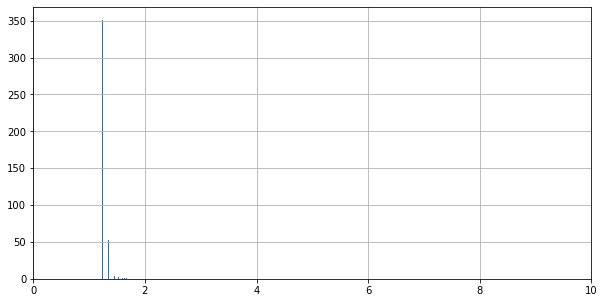

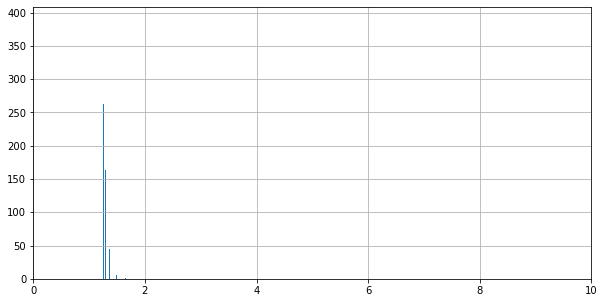

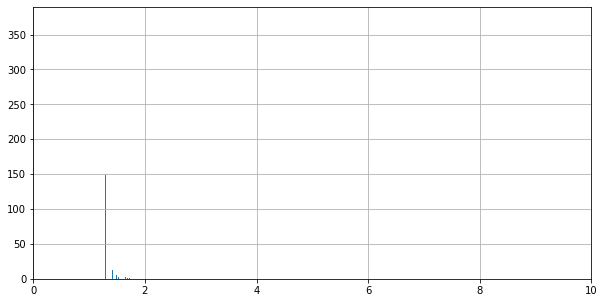

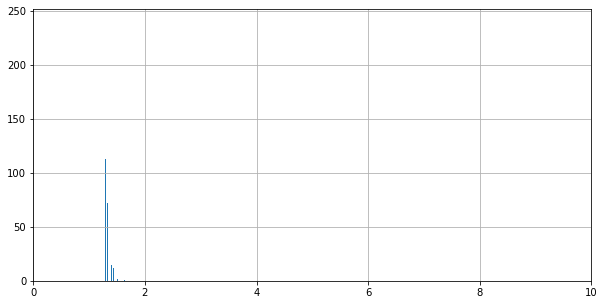

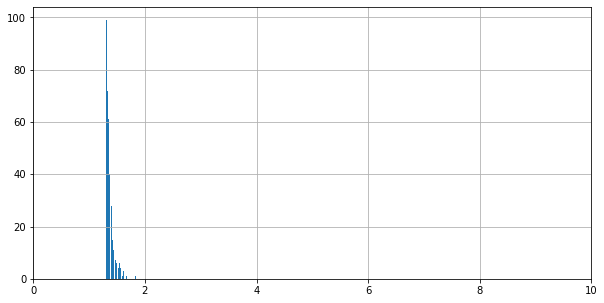

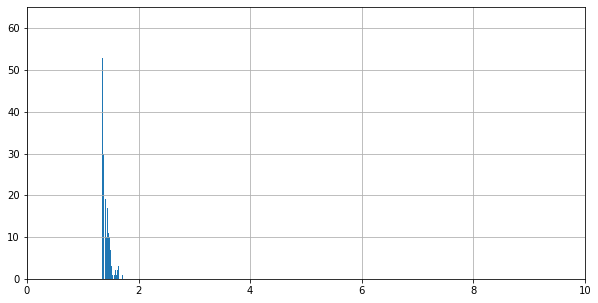

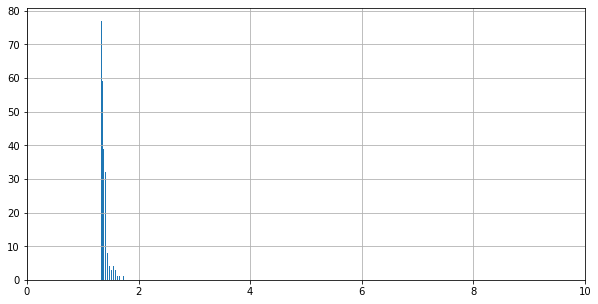

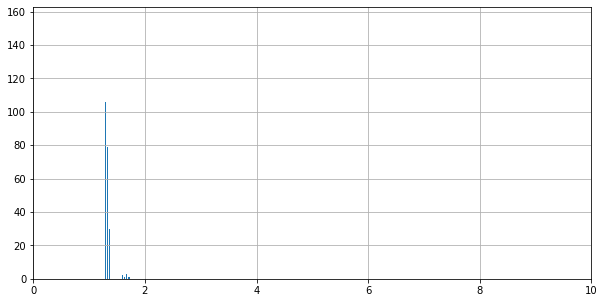

sample: slide_14_fov_07


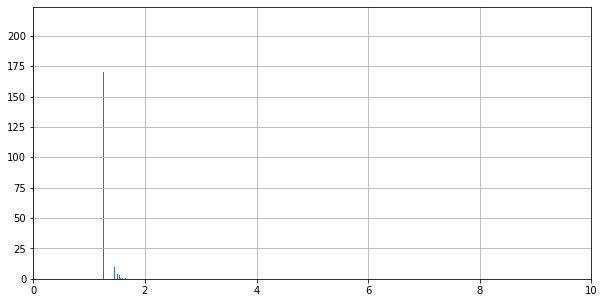

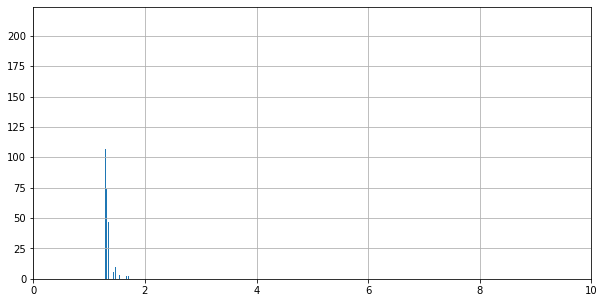

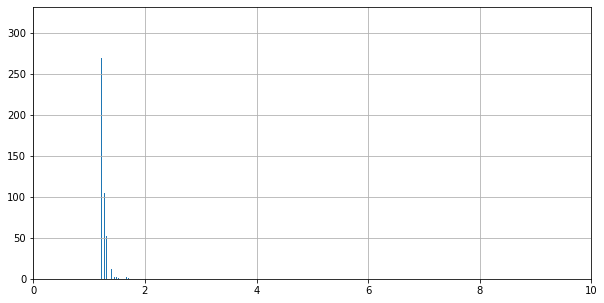

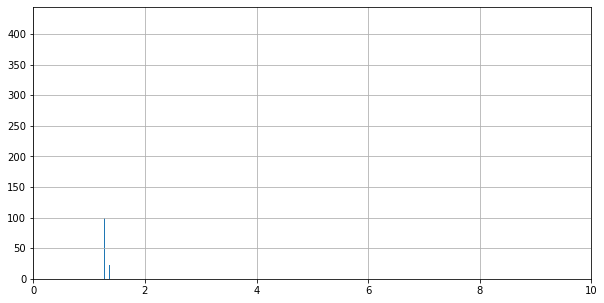

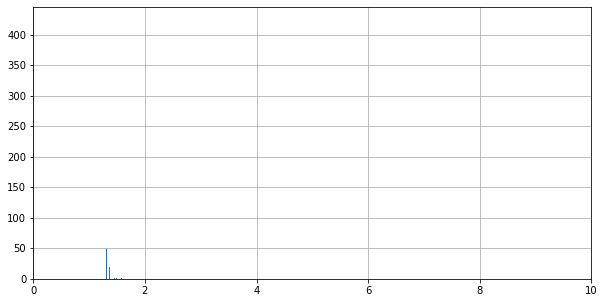

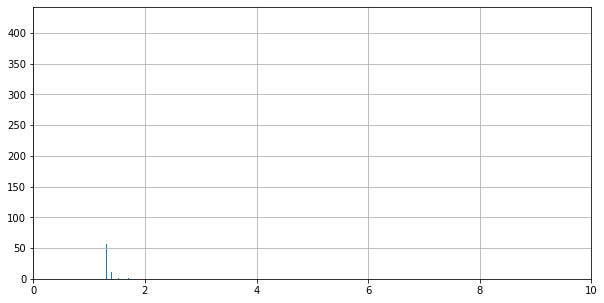

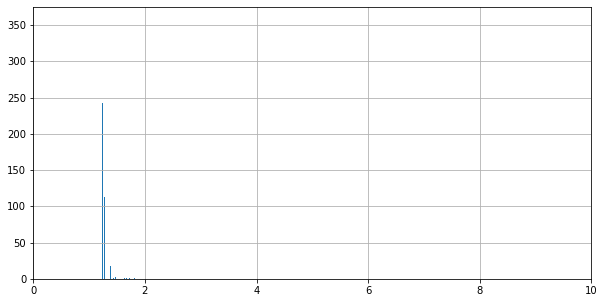

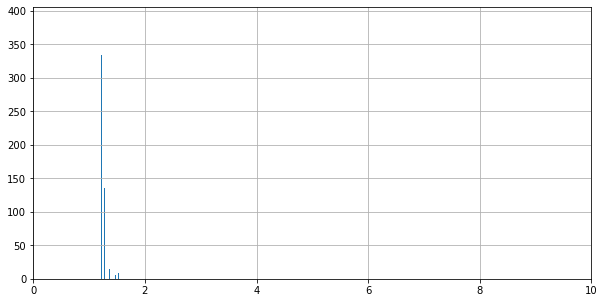

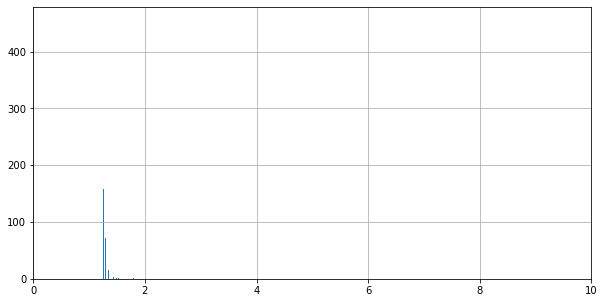

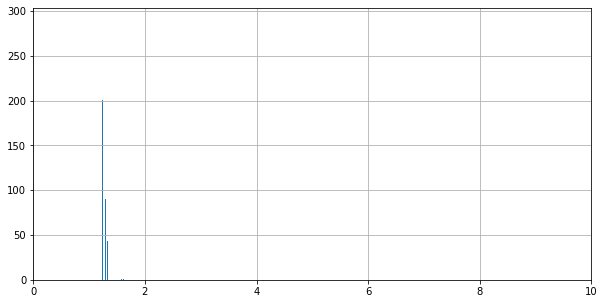

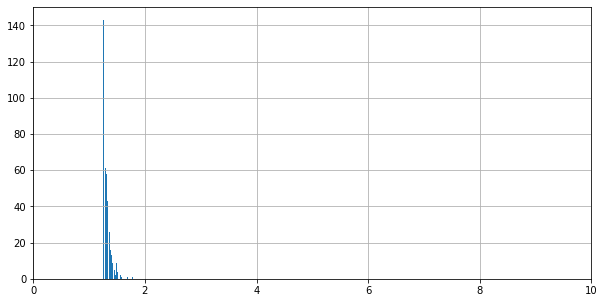

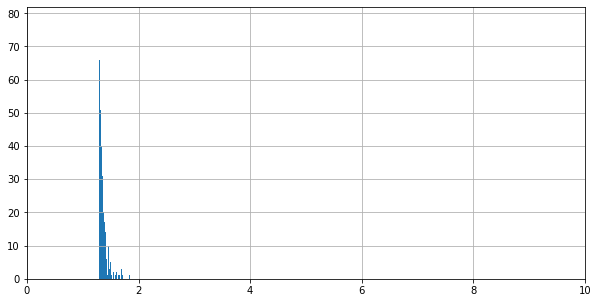

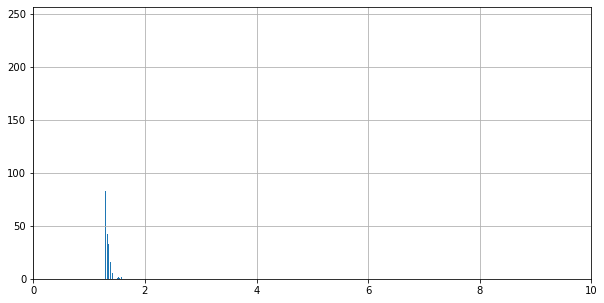

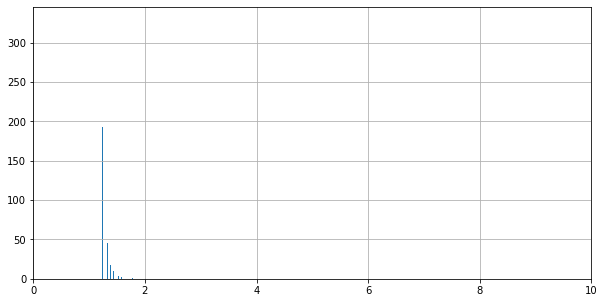

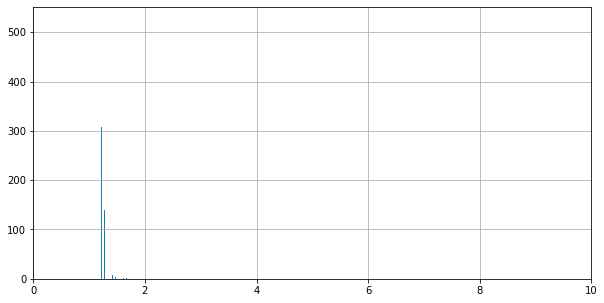

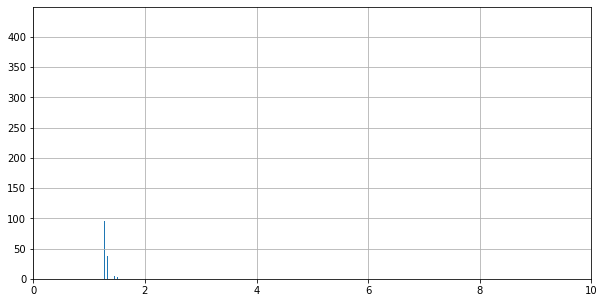

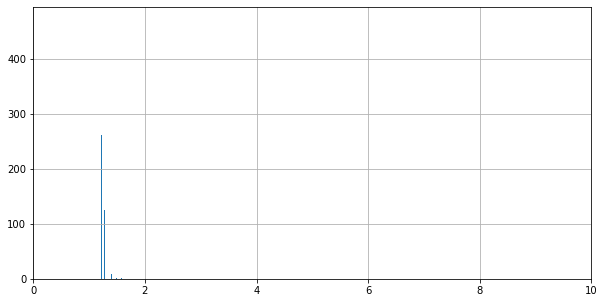

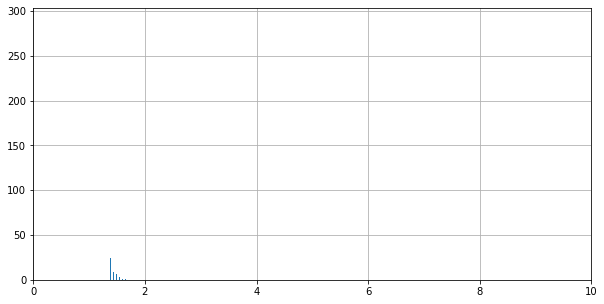

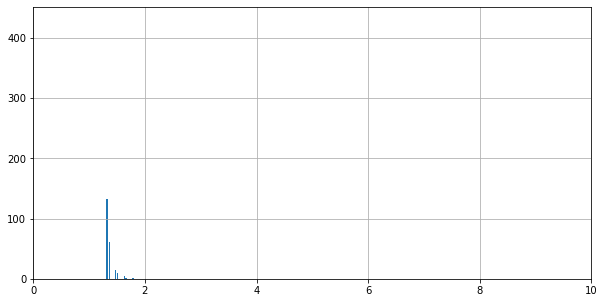

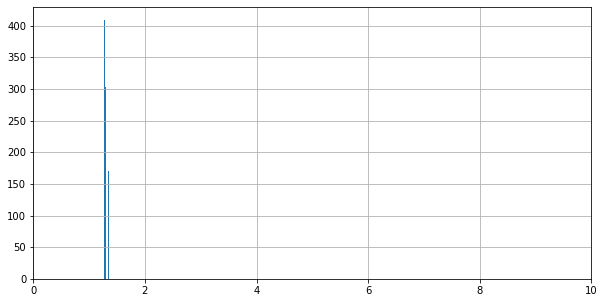

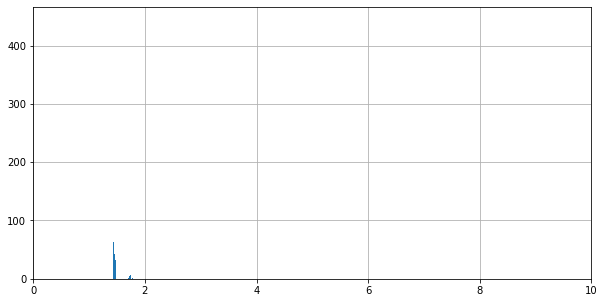

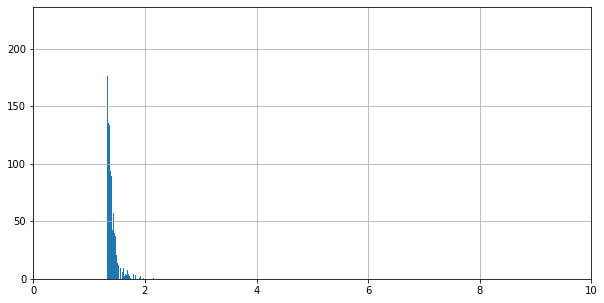

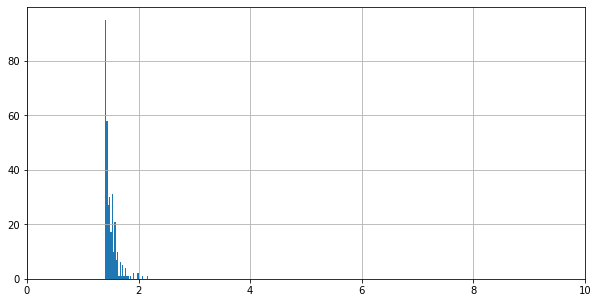

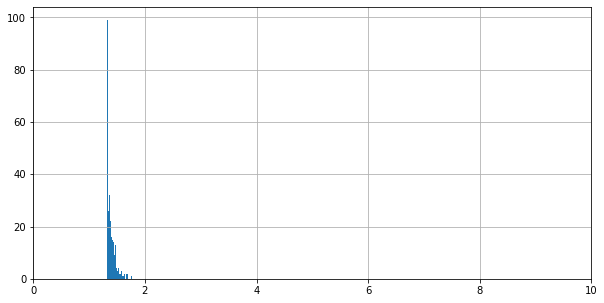

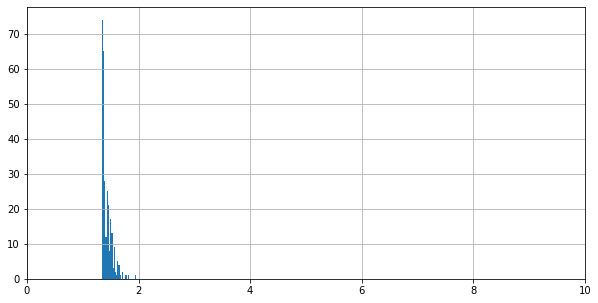

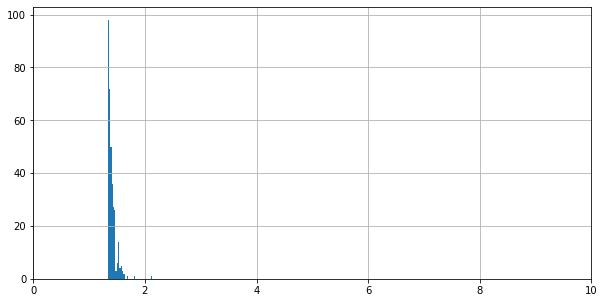

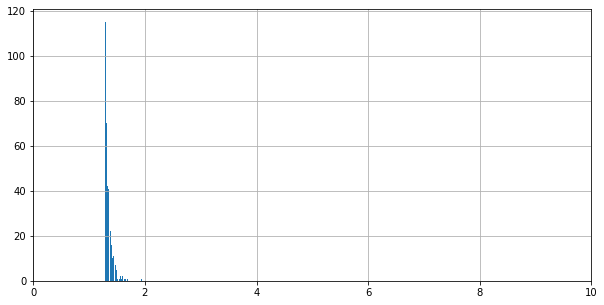

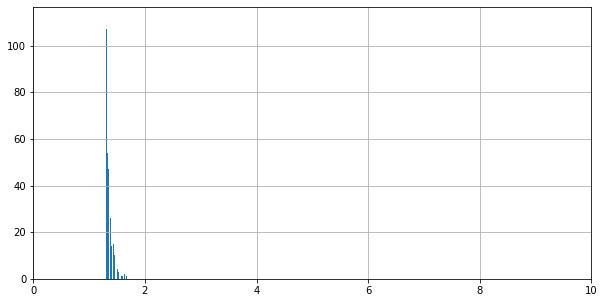

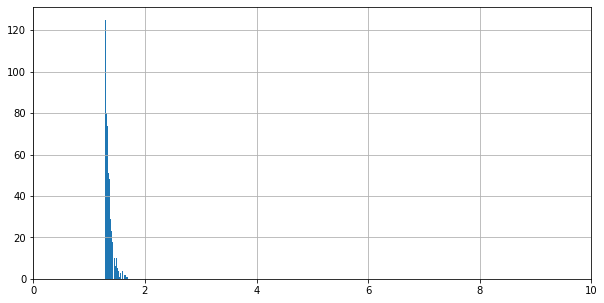

sample: slide_14_fov_09


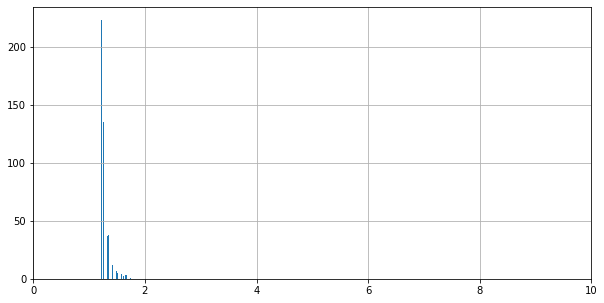

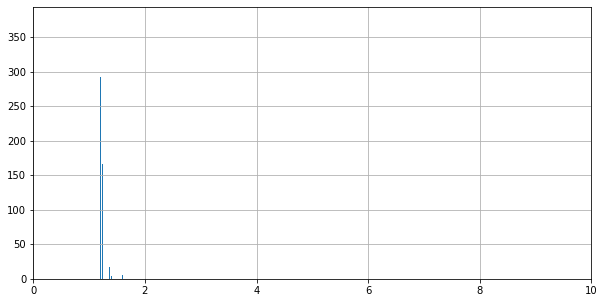

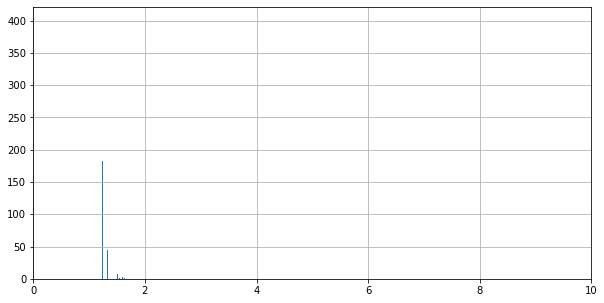

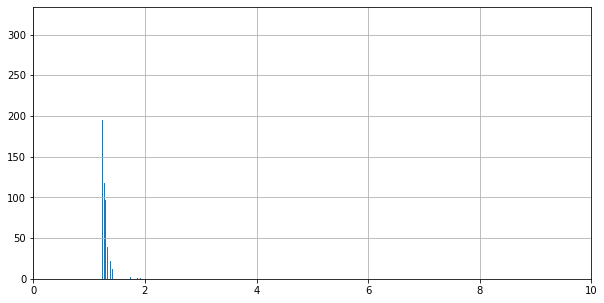

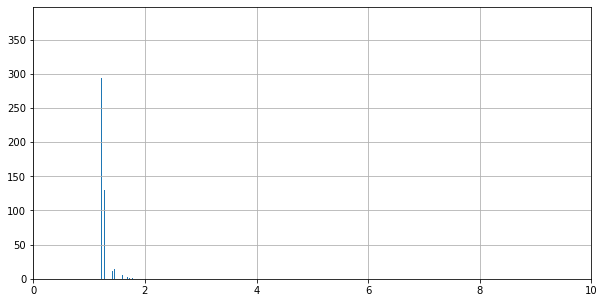

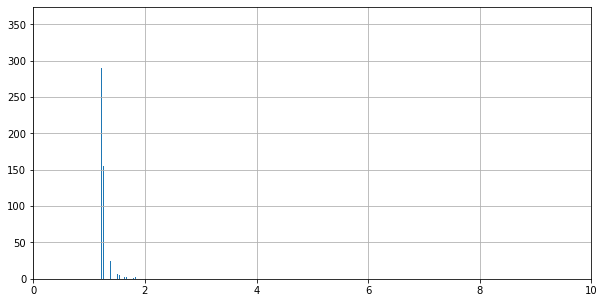

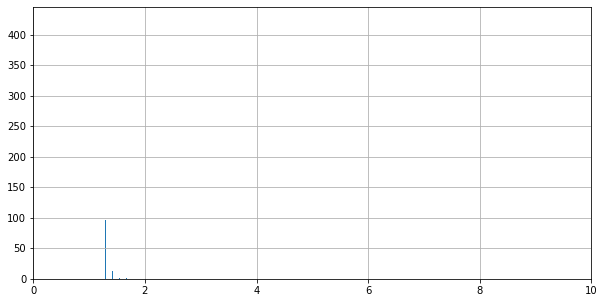

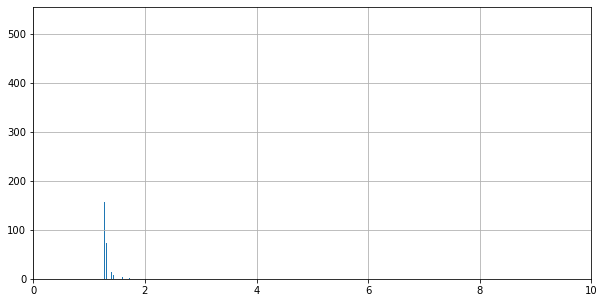

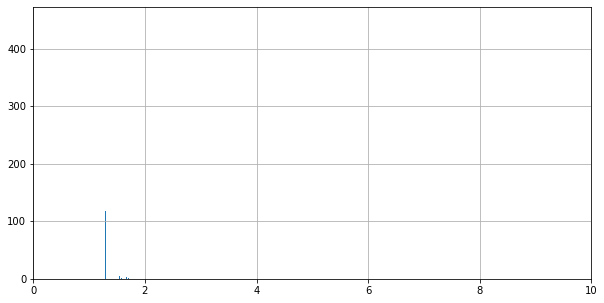

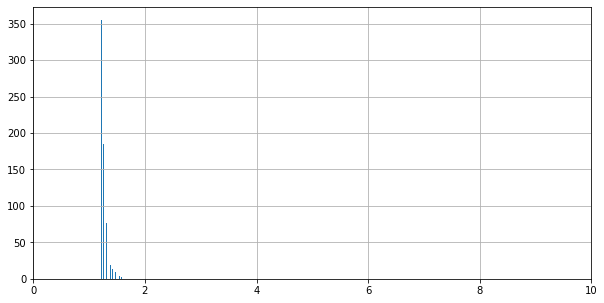

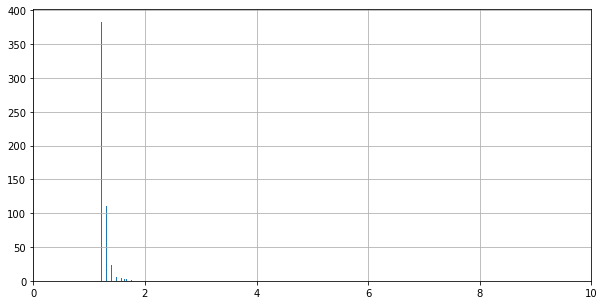

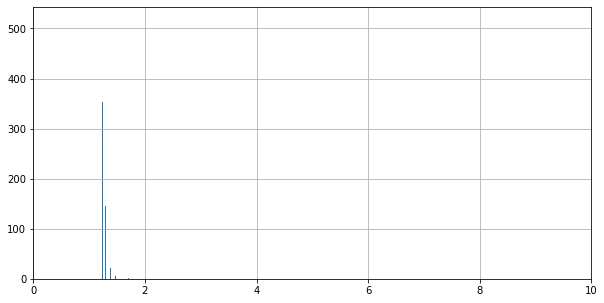

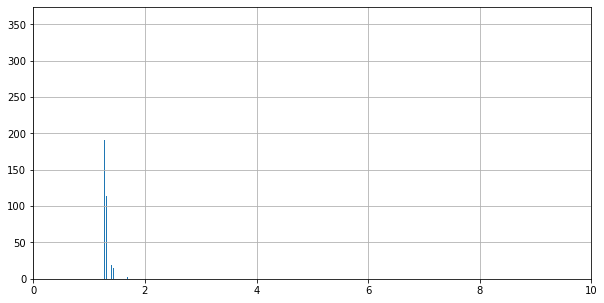

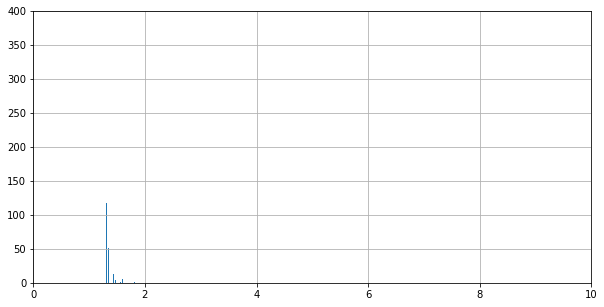

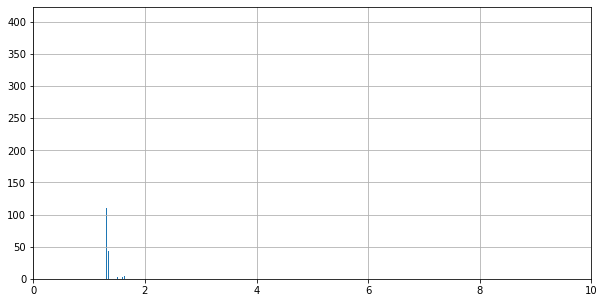

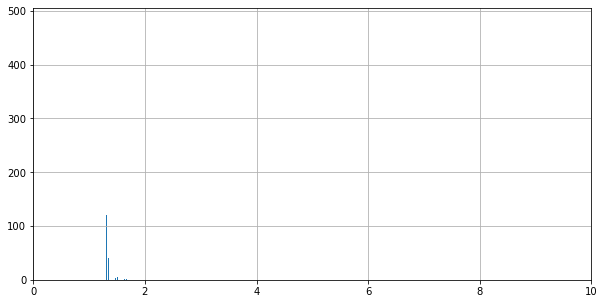

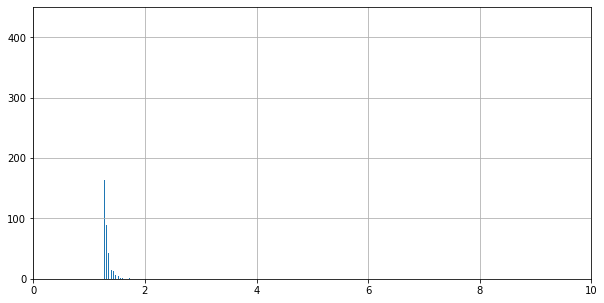

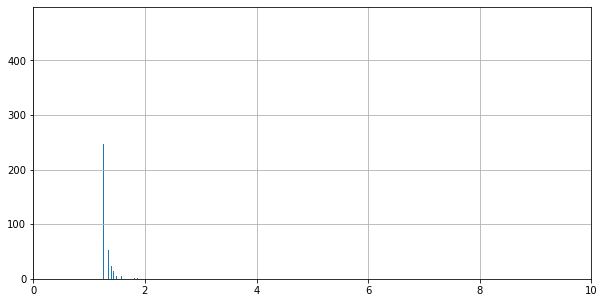

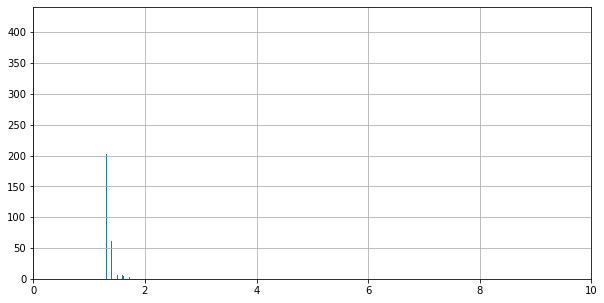

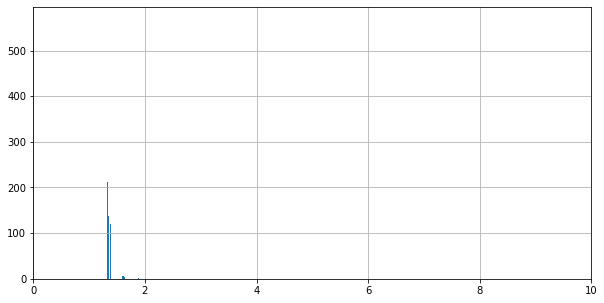

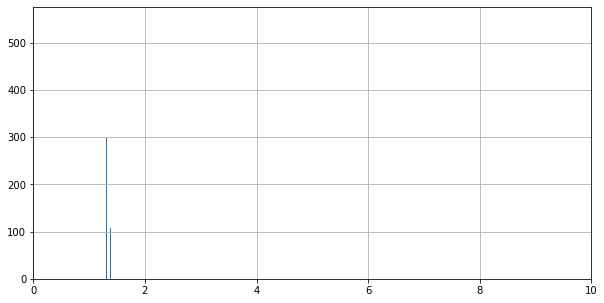

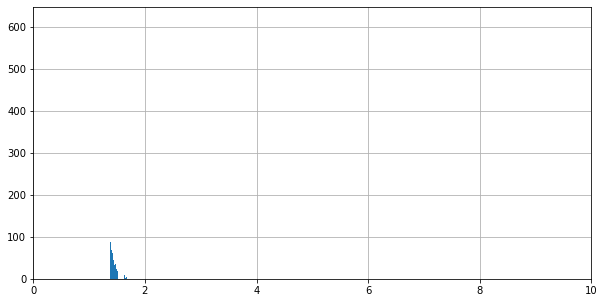

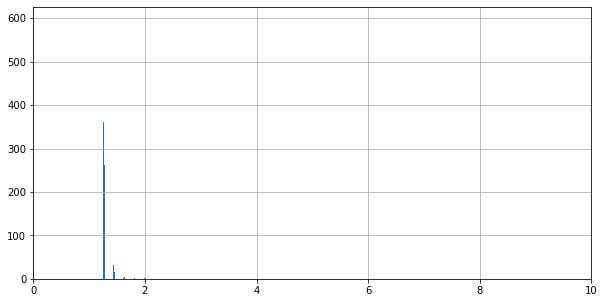

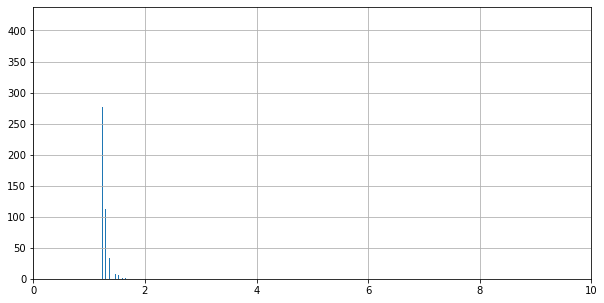

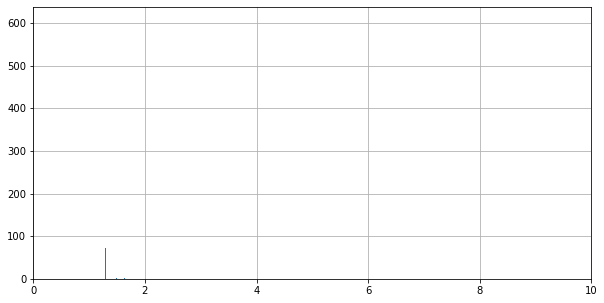

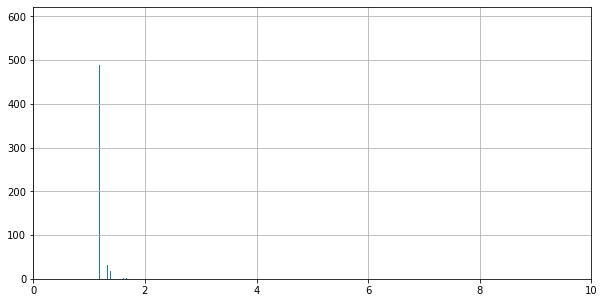

sample: slide_ec_fov_02


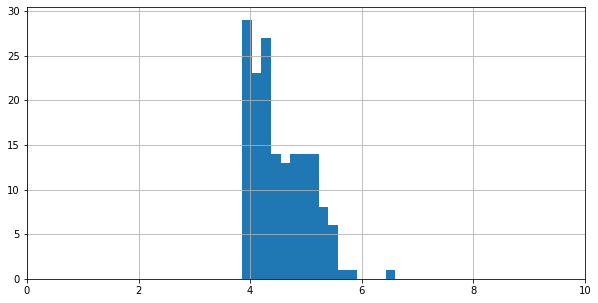

sample: slide_ec_fov_03


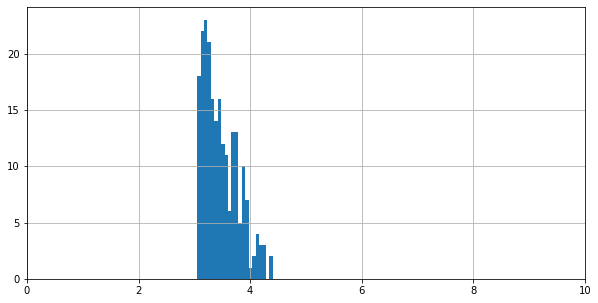

sample: slide_bmgsp_fov_01


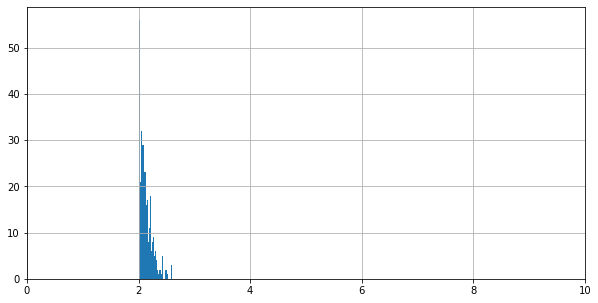

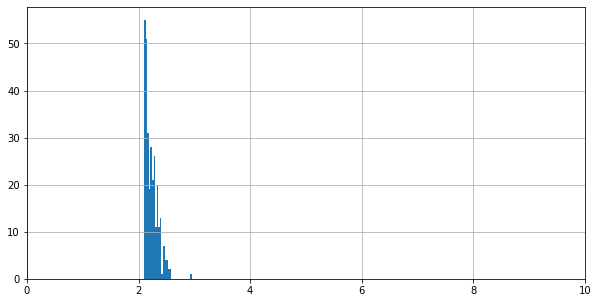

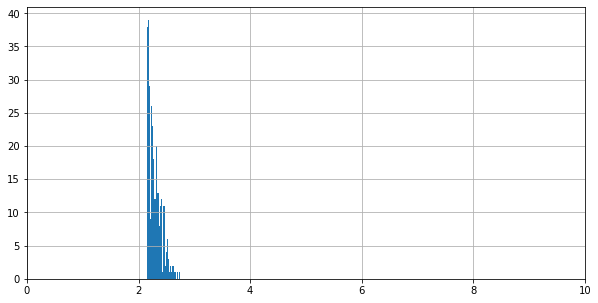

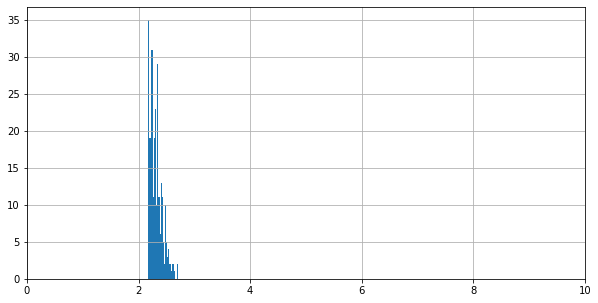

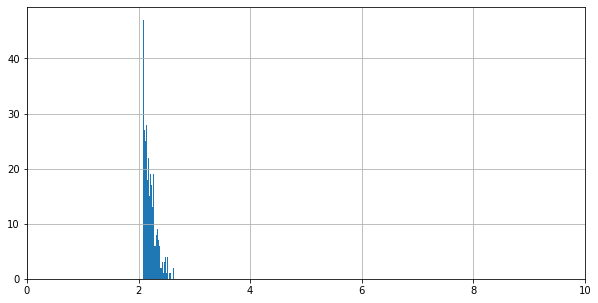

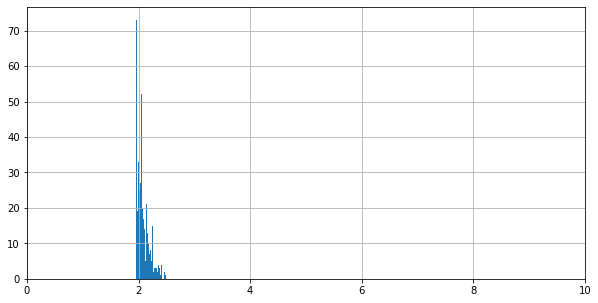

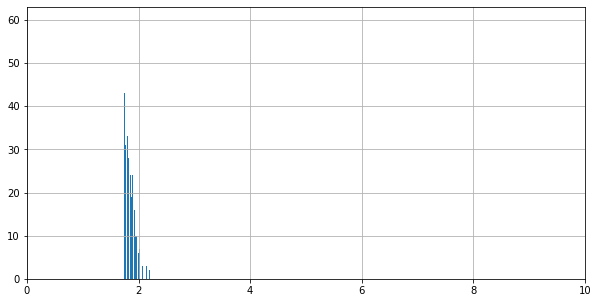

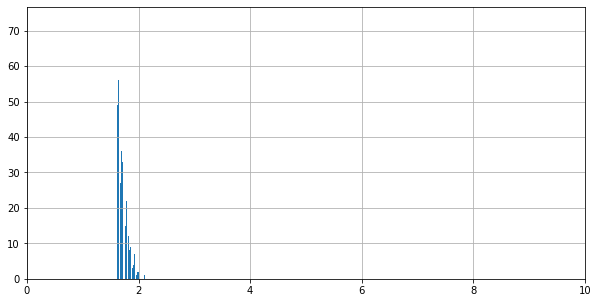

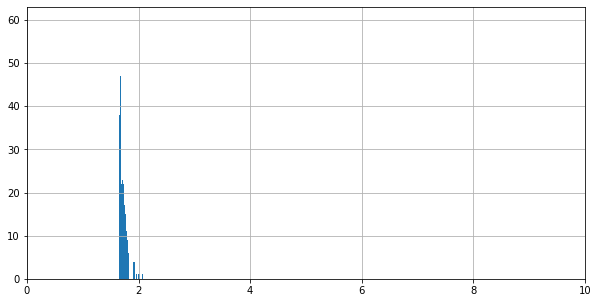

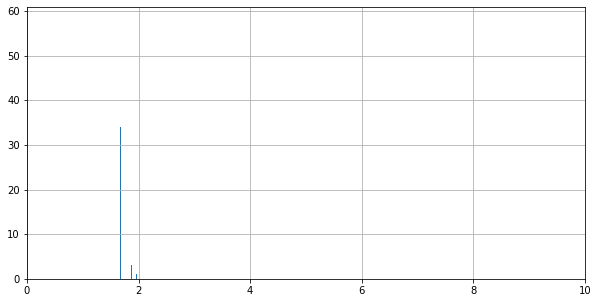

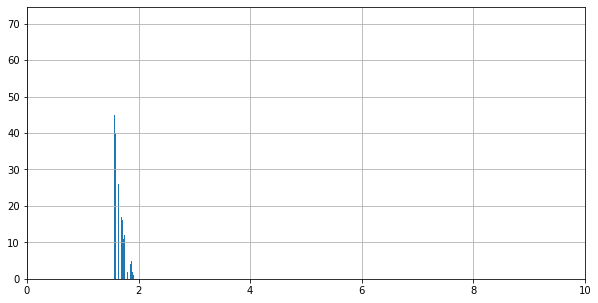

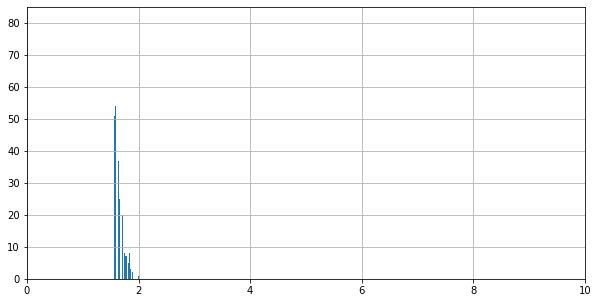

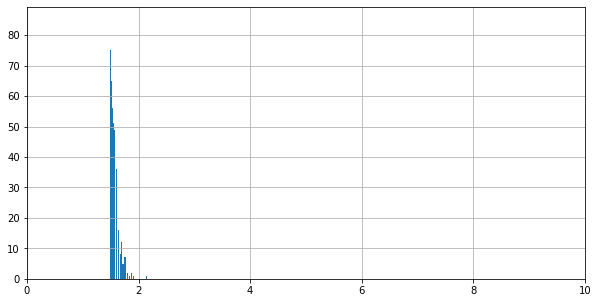

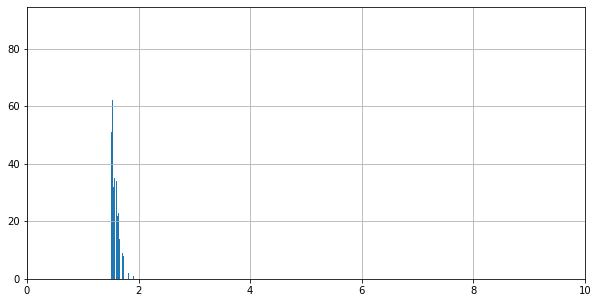

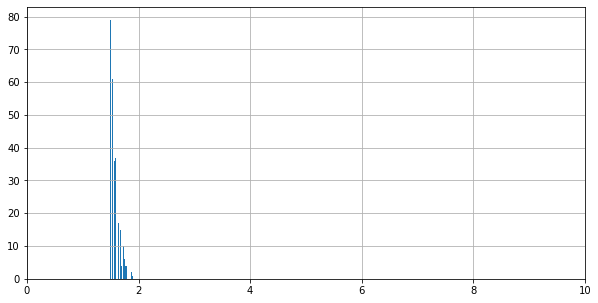

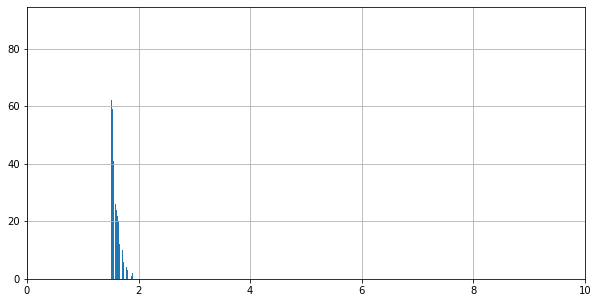

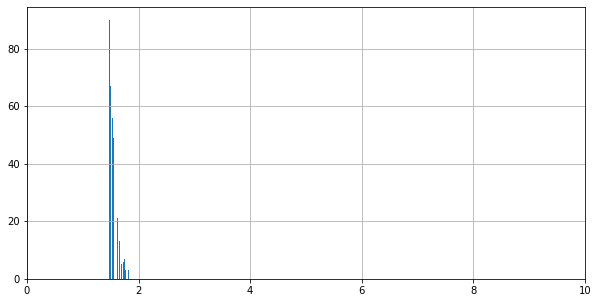

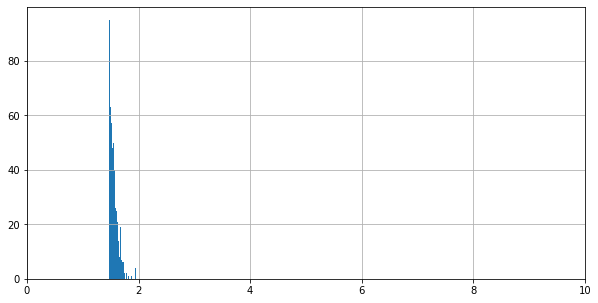

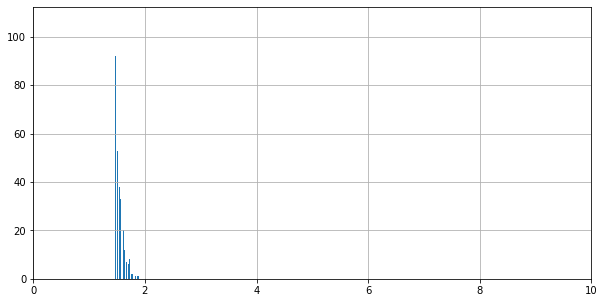

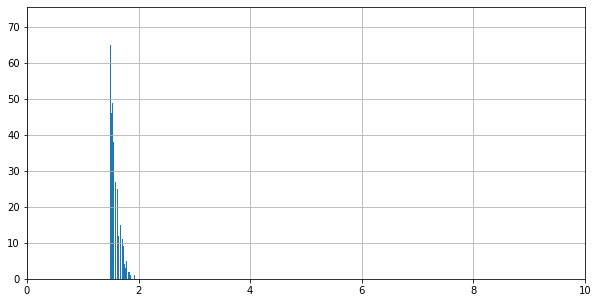

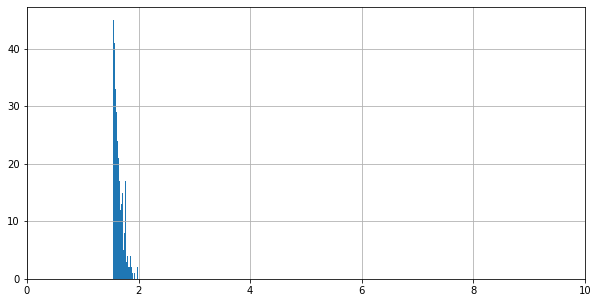

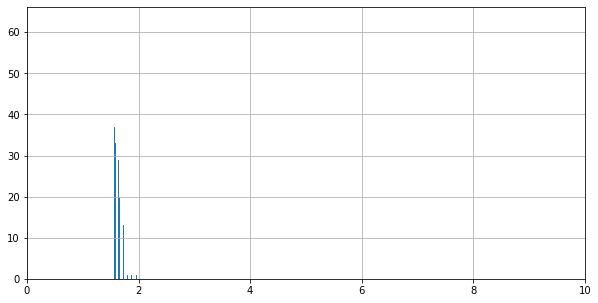

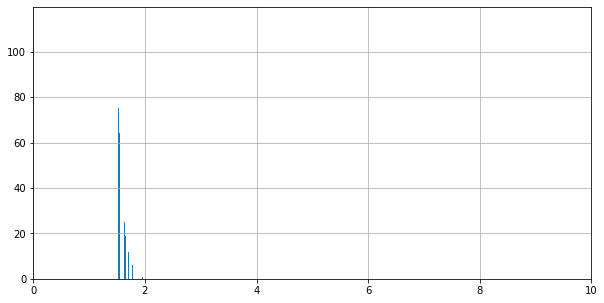

sample: slide_ec_fov_01


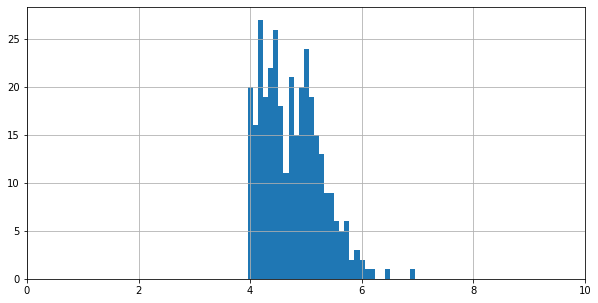

sample: slide_bmgsp_fov_02


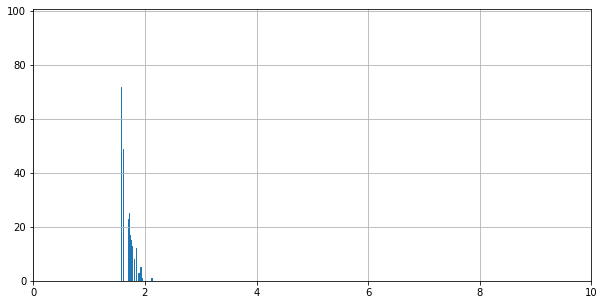

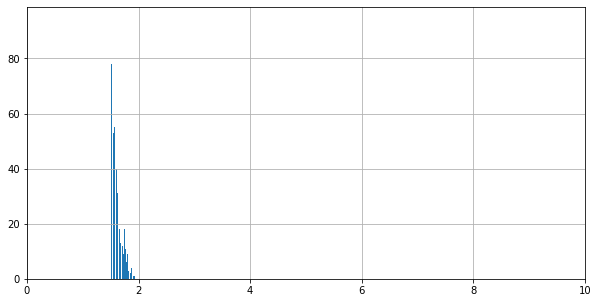

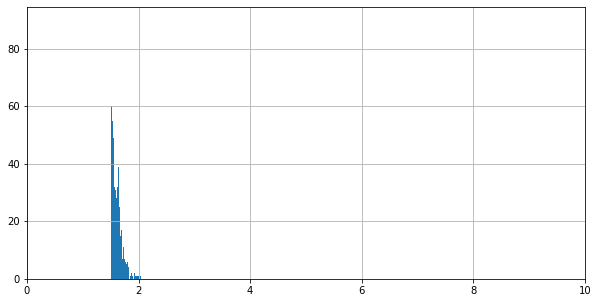

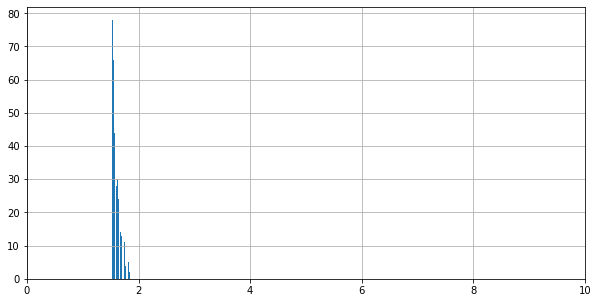

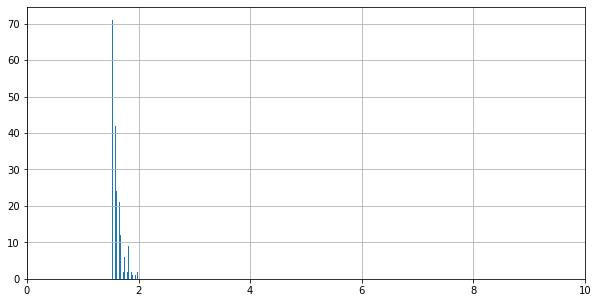

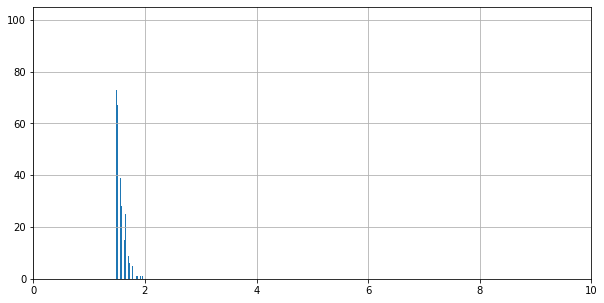

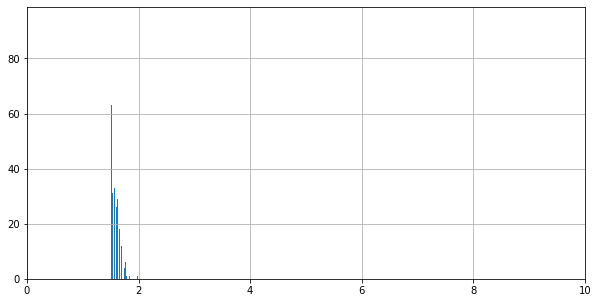

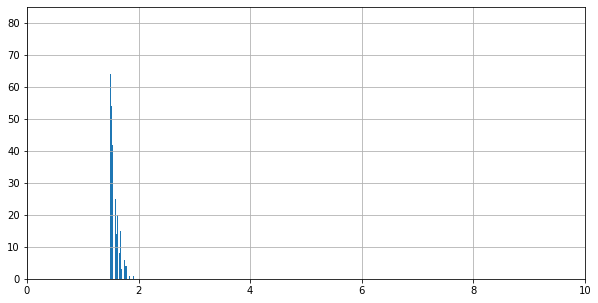

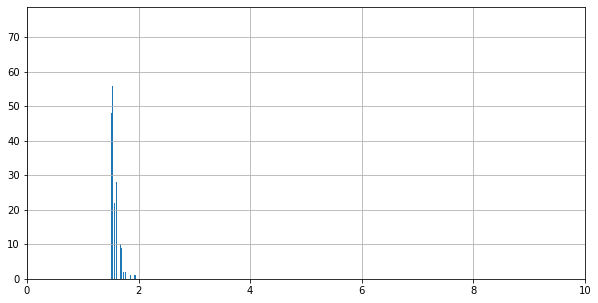

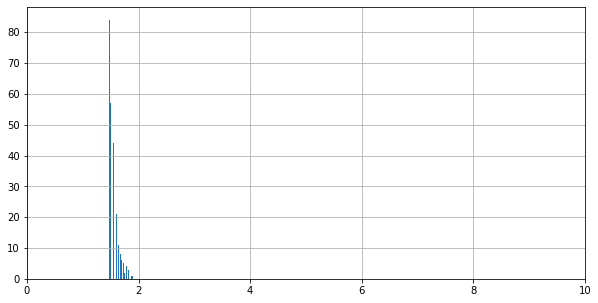

sample: slide_bmgsp_fov_03


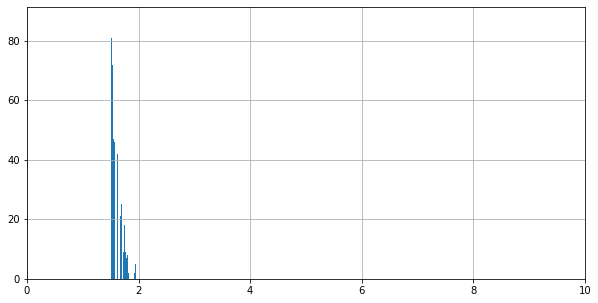

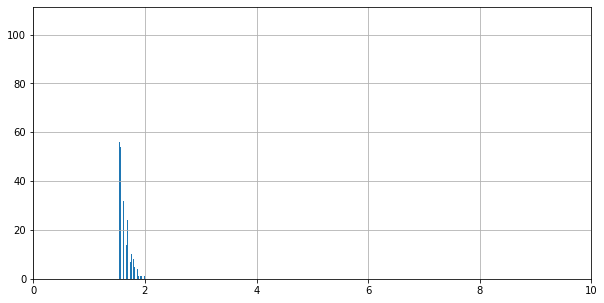

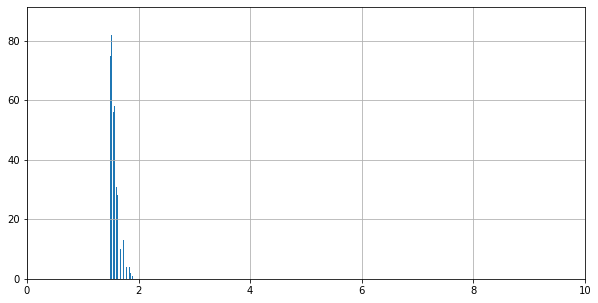

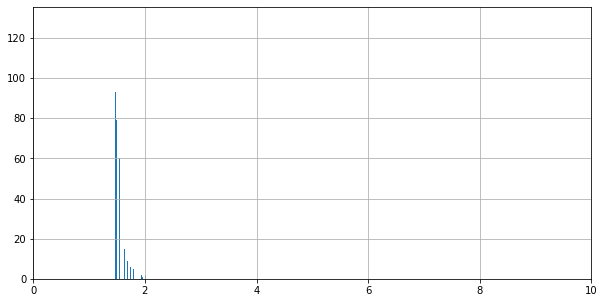

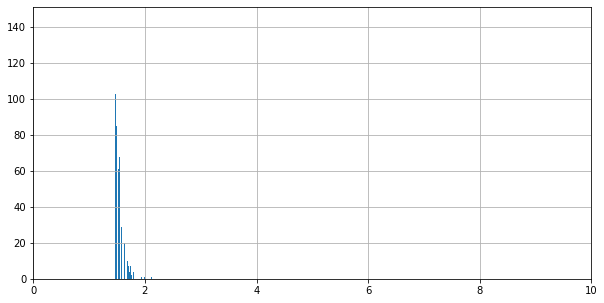

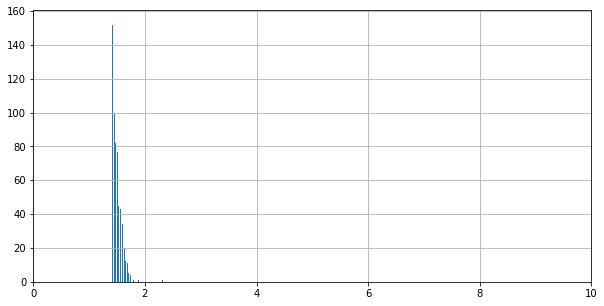

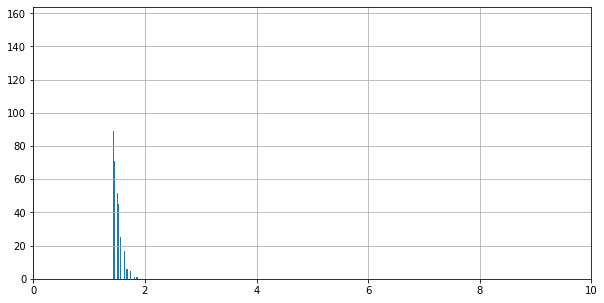

In [96]:
# counts = []
for fn in filenames:
    sample_name = re.sub('2023_09_12_sapp05_spades08_','',os.path.split(fn)[1])
    sample_name = re.sub('_mode_airy_Airyscan\ Processing.czi','',sample_name)
    print('sample:', sample_name)
    czi = aplc.CziFile(fn)
    dims = czi.get_dims_shape()[0]
    counts_fov = []
    if 'M' in czi.dims:
        ms = dims['M'][1]
        if 'Z' in czi.dims:
            zs = dims['Z'][1] 
            for m in range(ms):
                for z in range(zs):
                    im, shp = czi.read_image(M=m, Z=z)
                    im_spot = get_spot_im(im)
                    counts_fov.append(count_spots(im_spot))           
    elif 'Z' in czi.dims:
        zs = dims['Z'][1] 
        for z in range(zs):
            im, shp = czi.read_image(Z=z)
            im_spot = get_spot_im(im)
            counts_fov.append(count_spots(im_spot))
    else:
        im, shp = czi.read_image()
        im_spot = get_spot_im(im)
        counts_fov.append(count_spots(im_spot))
    counts.append(counts_fov)

Plot max intensity histograms

sample: slide_11_fov_01


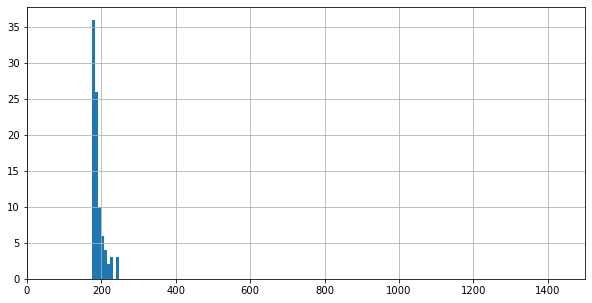

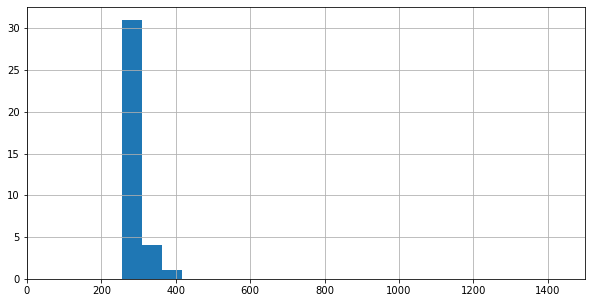

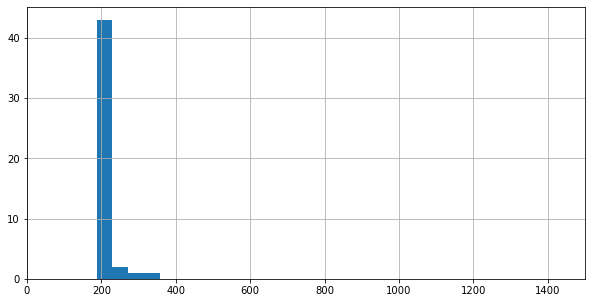

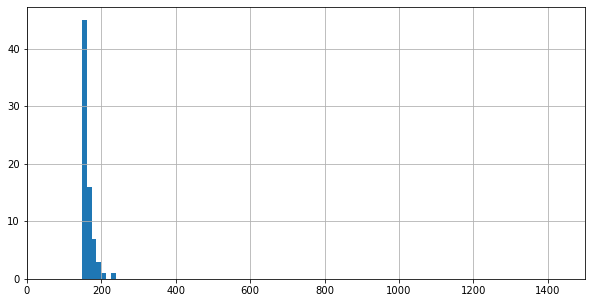

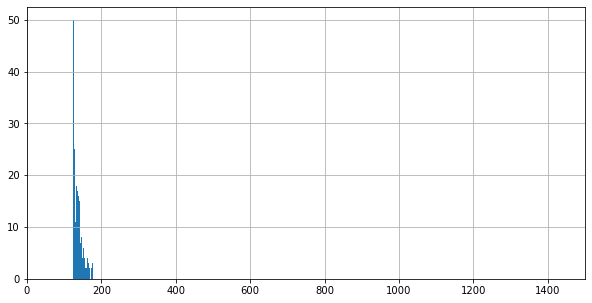

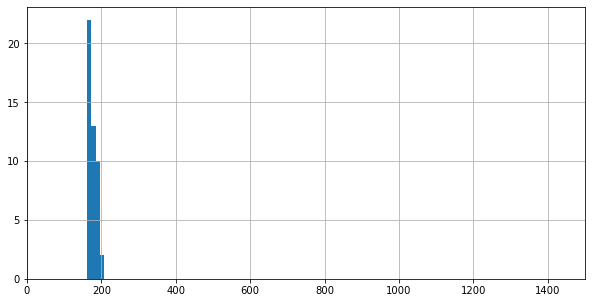

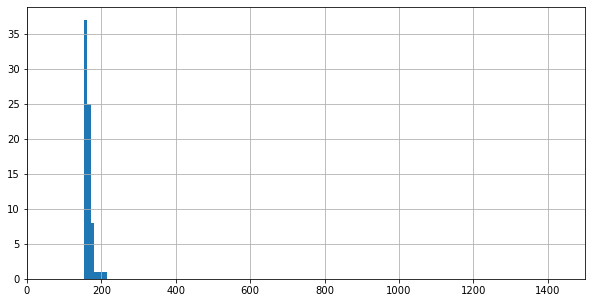

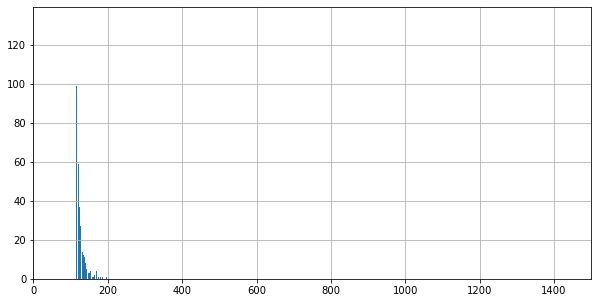

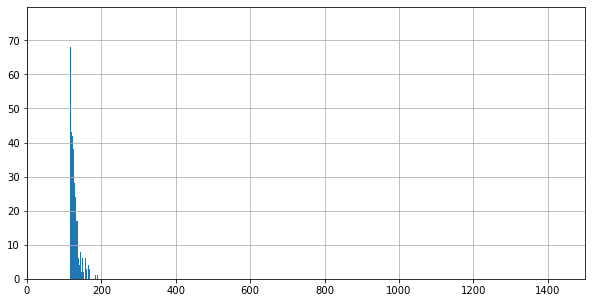

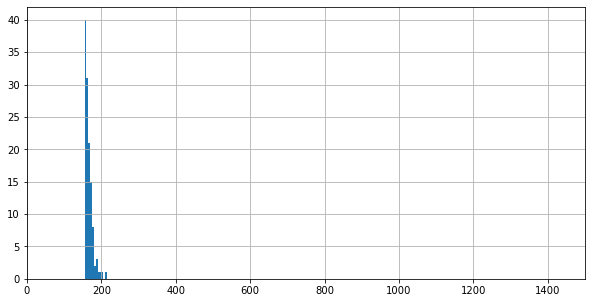

sample: slide_11_fov_02


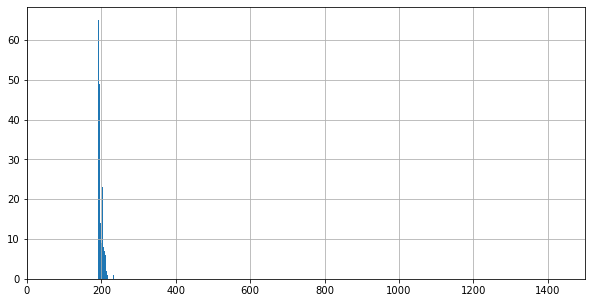

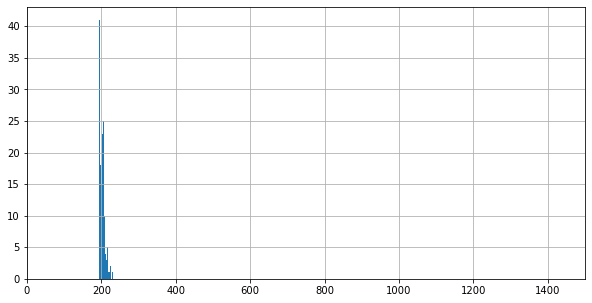

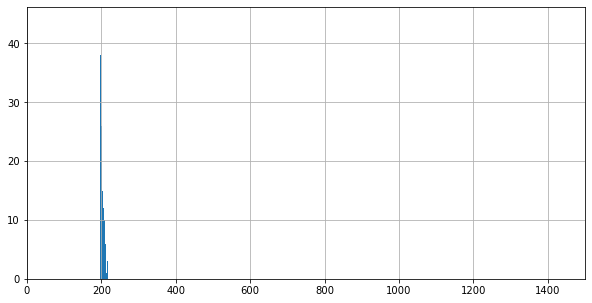

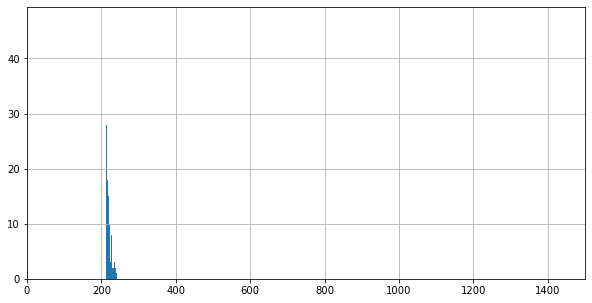

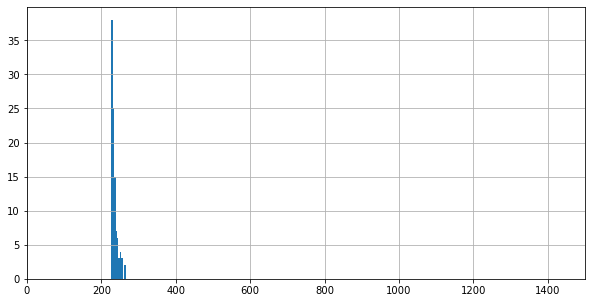

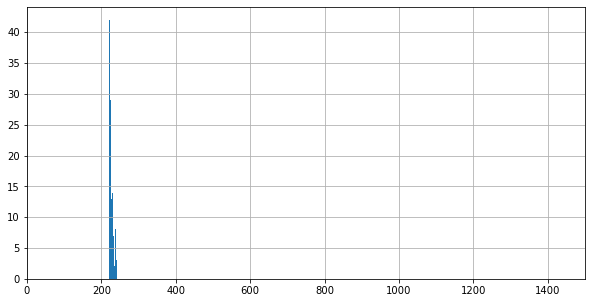

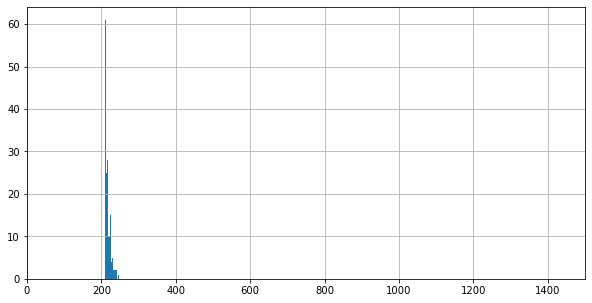

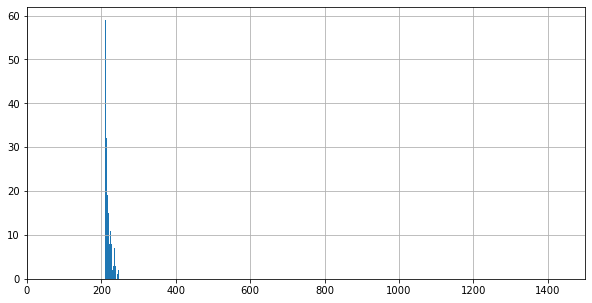

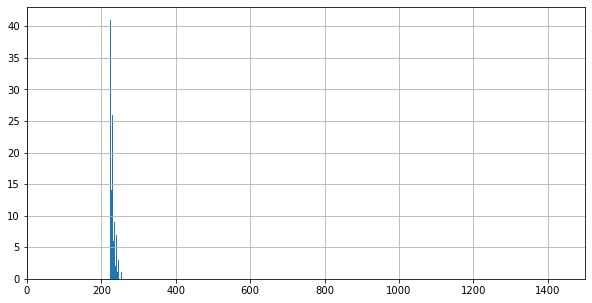

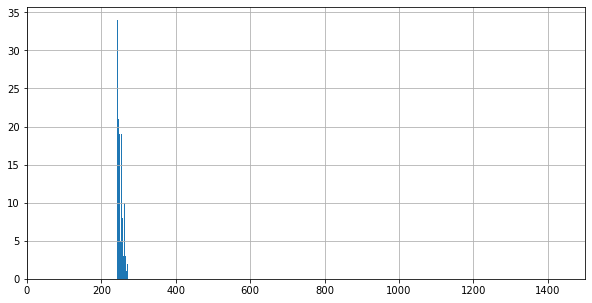

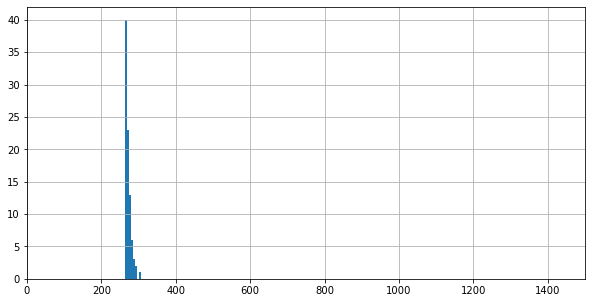

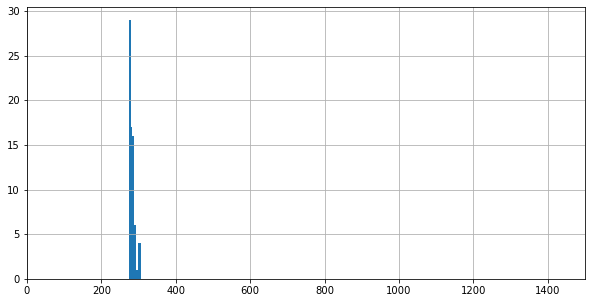

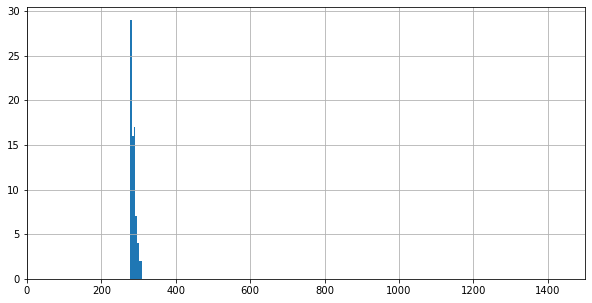

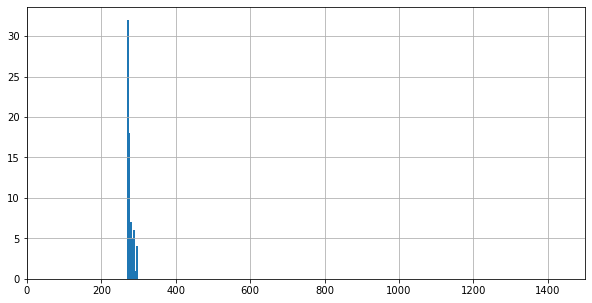

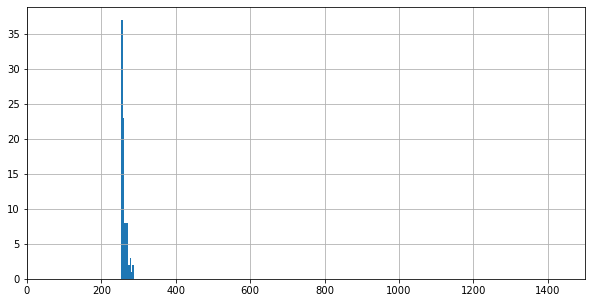

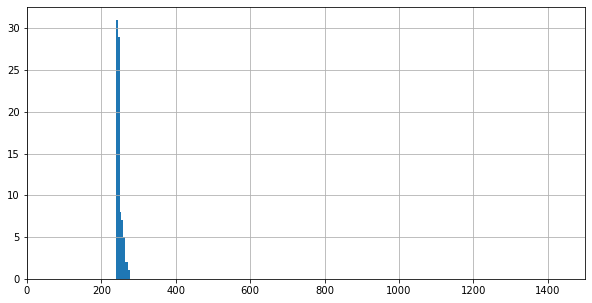

sample: slide_11_fov_03


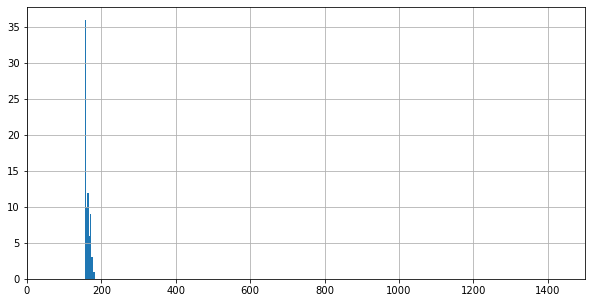

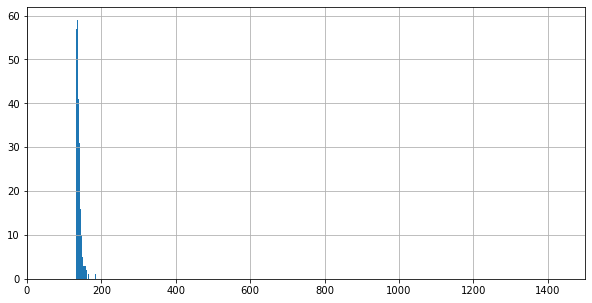

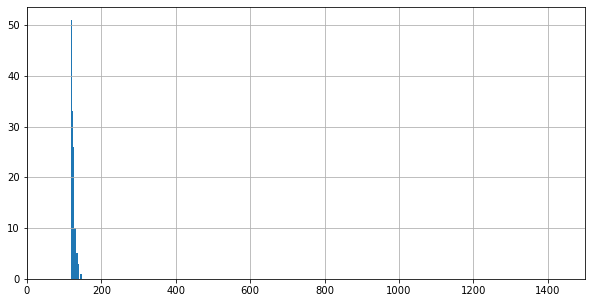

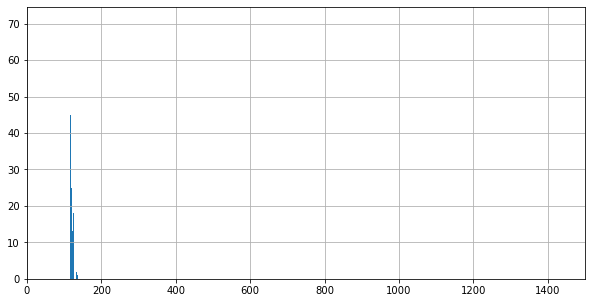

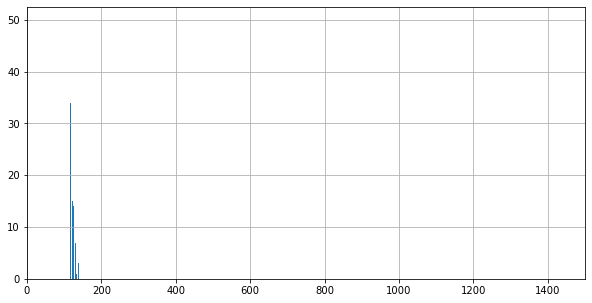

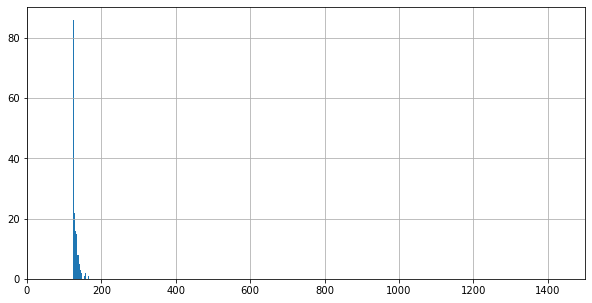

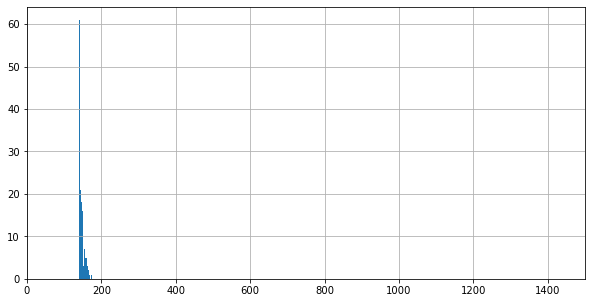

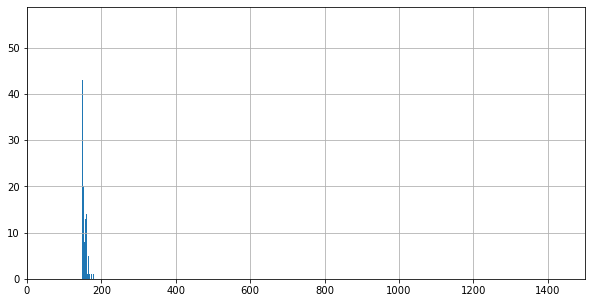

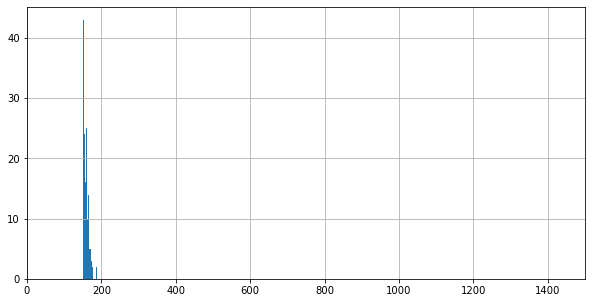

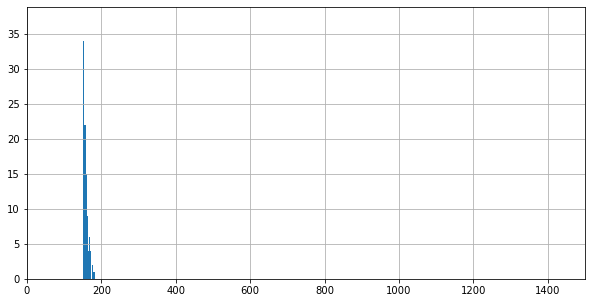

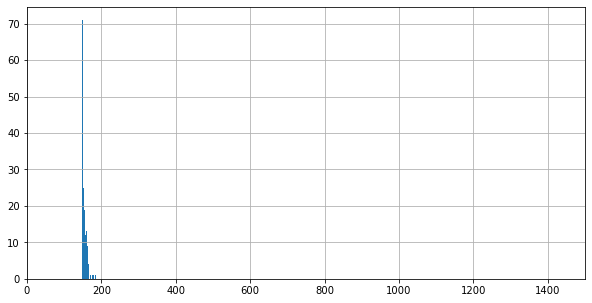

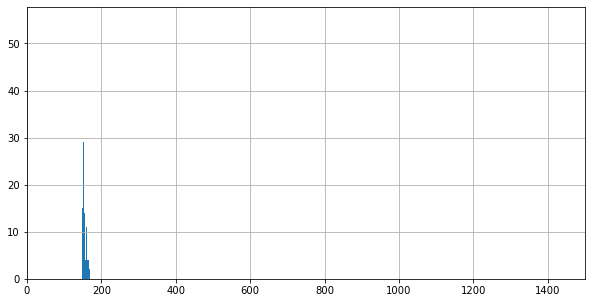

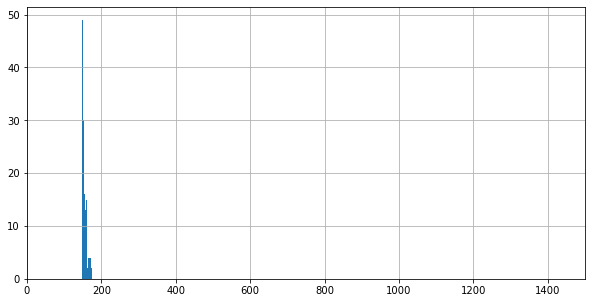

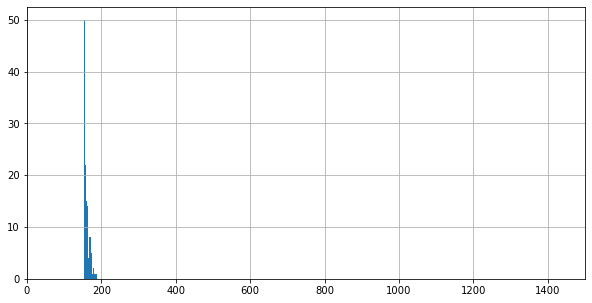

sample: slide_14_fov_02


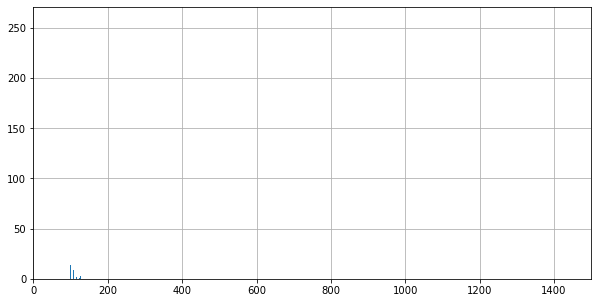

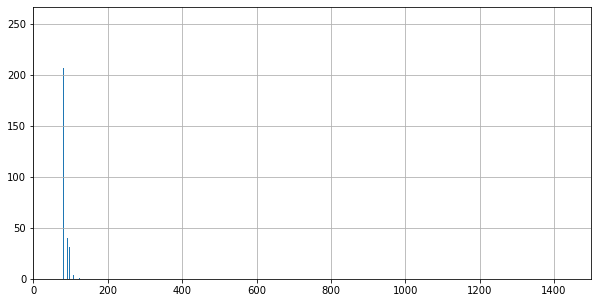

sample: slide_11_fov_04


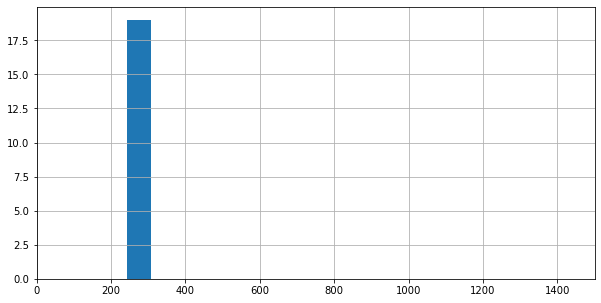

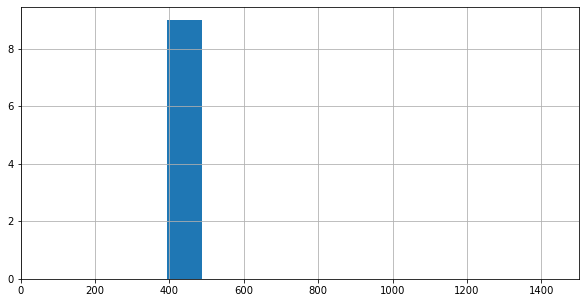

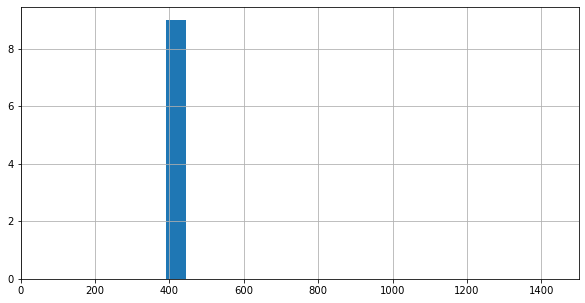

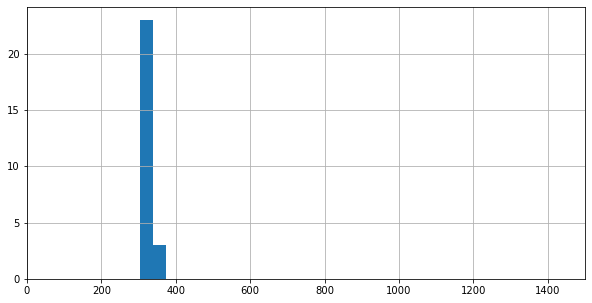

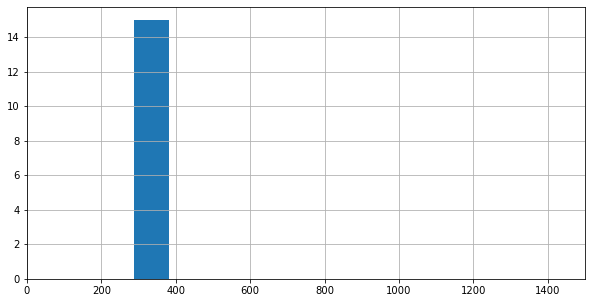

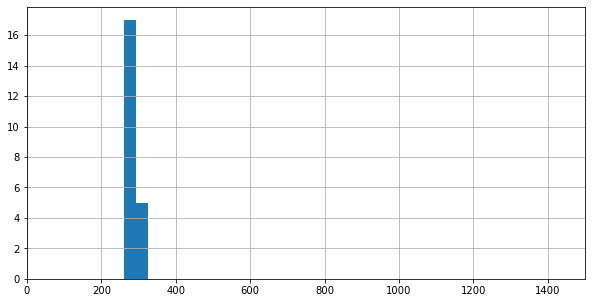

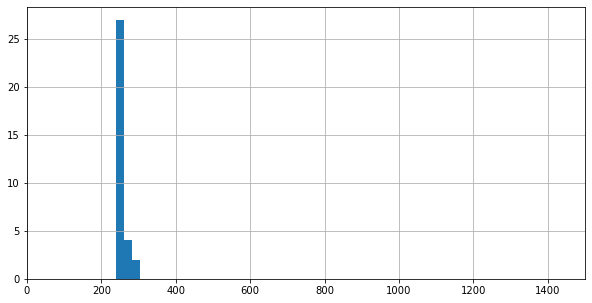

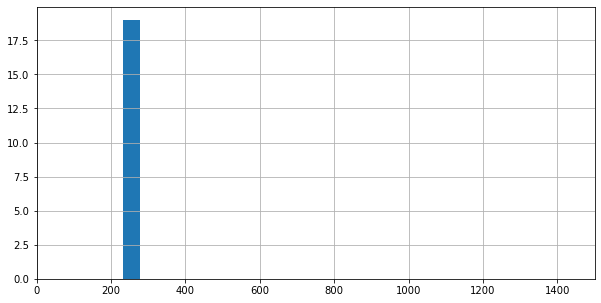

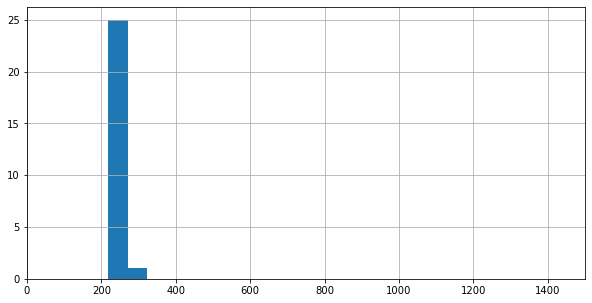

NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots
NO spots


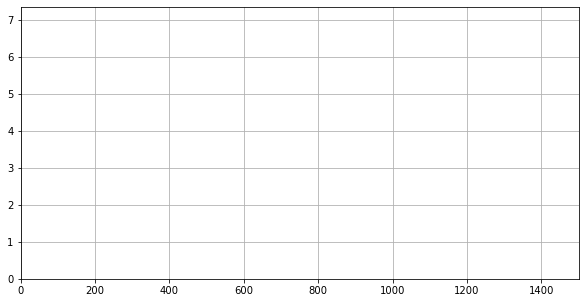

sample: slide_11_fov_05


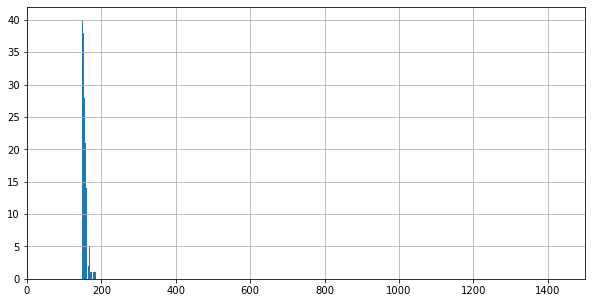

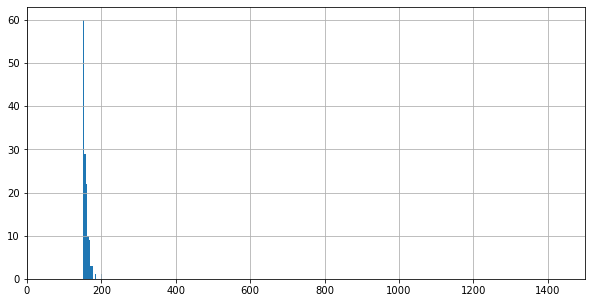

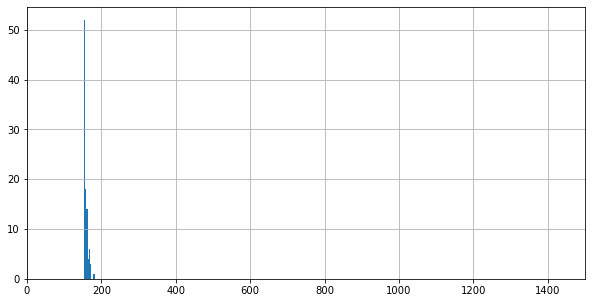

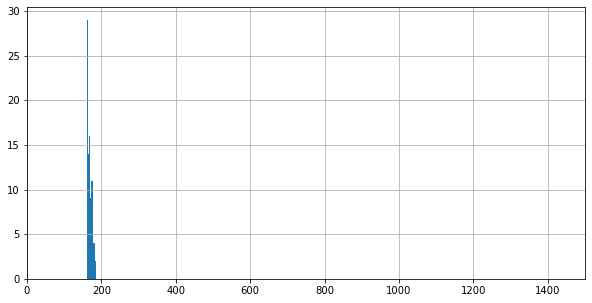

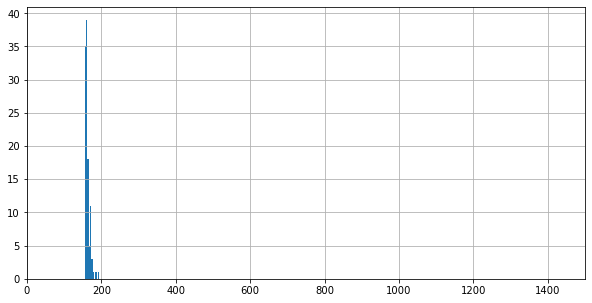

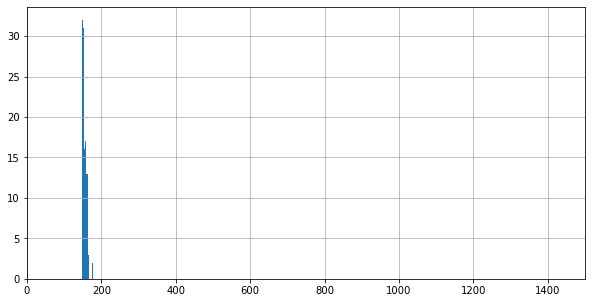

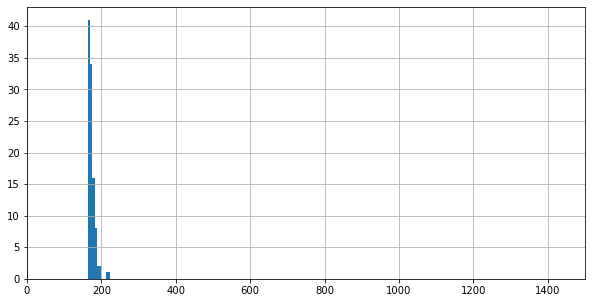

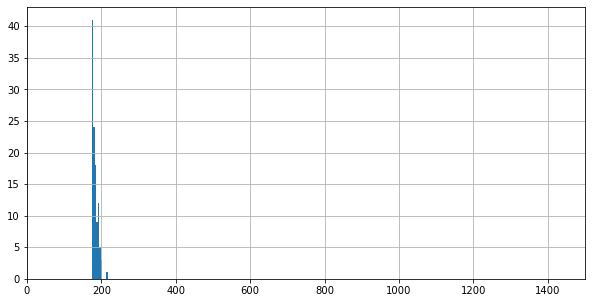

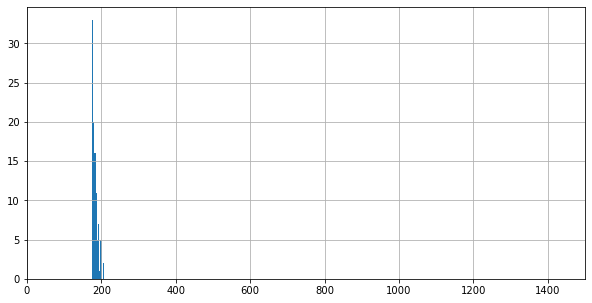

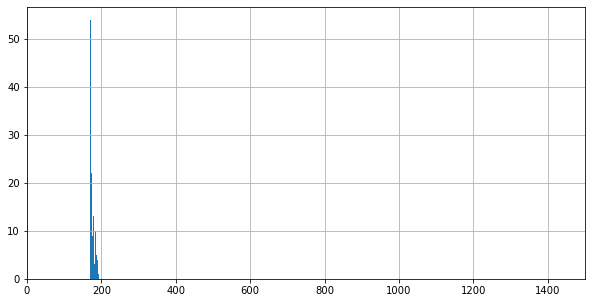

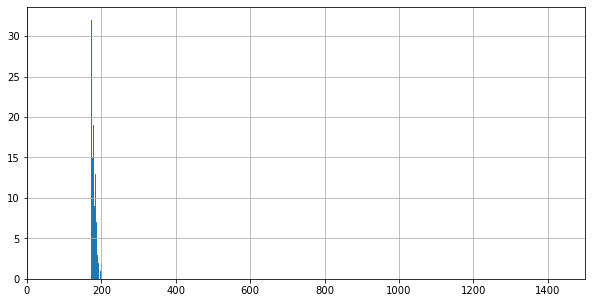

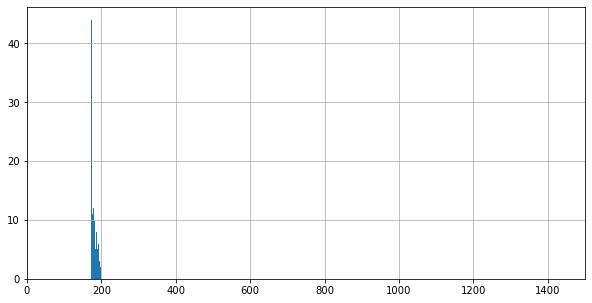

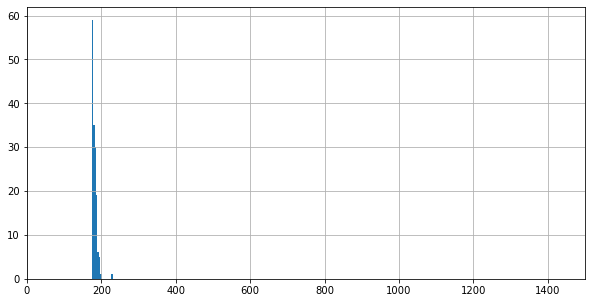

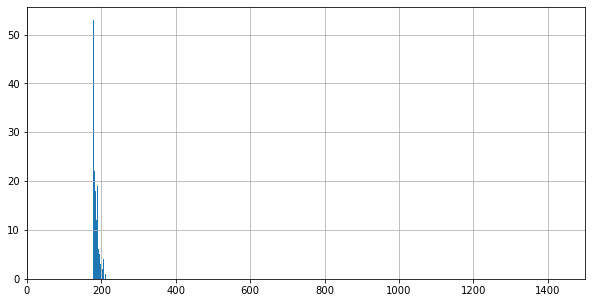

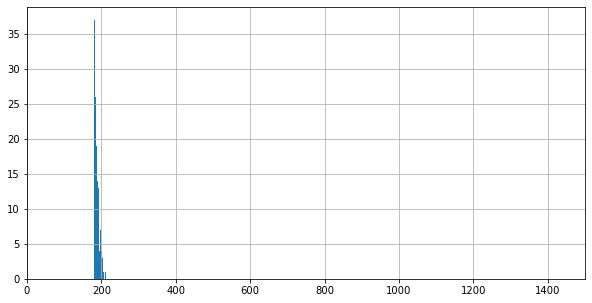

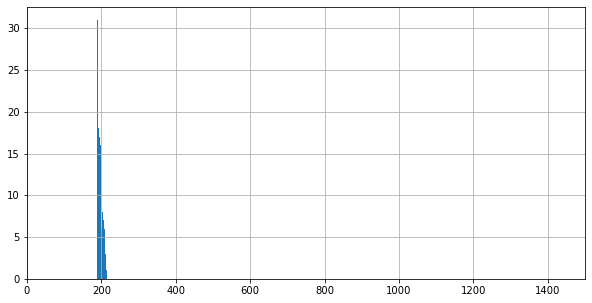

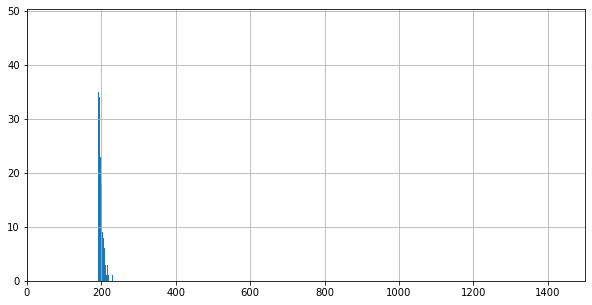

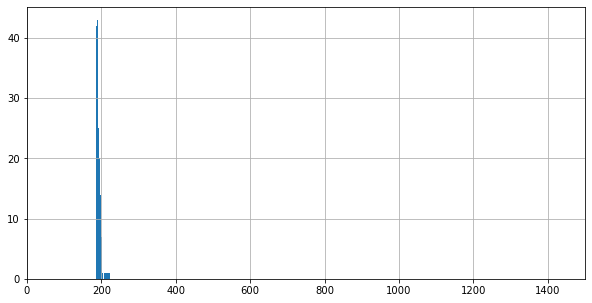

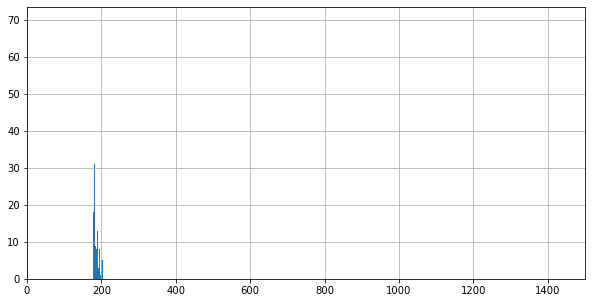

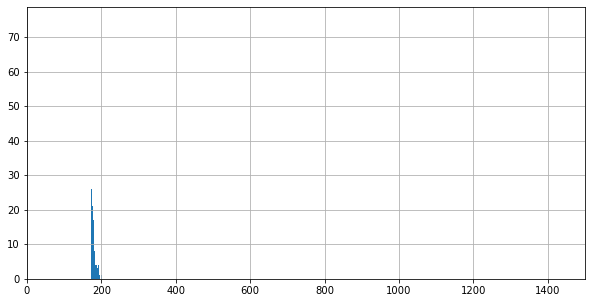

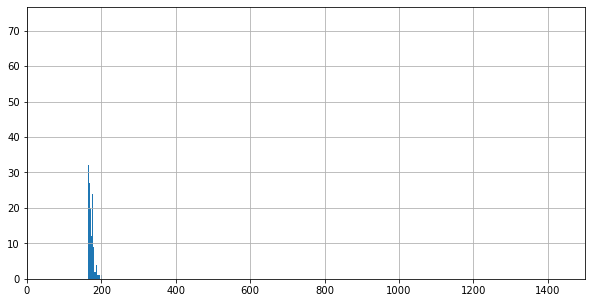

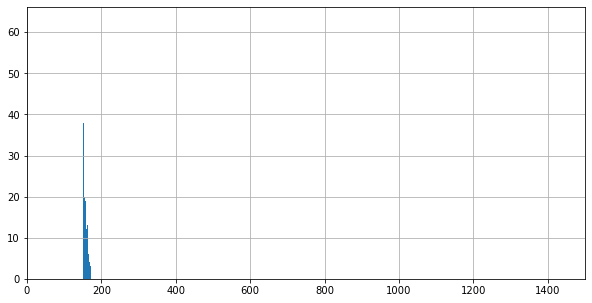

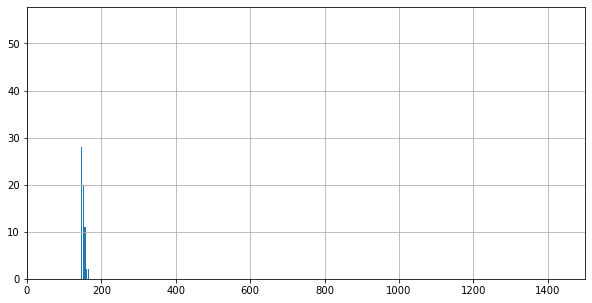

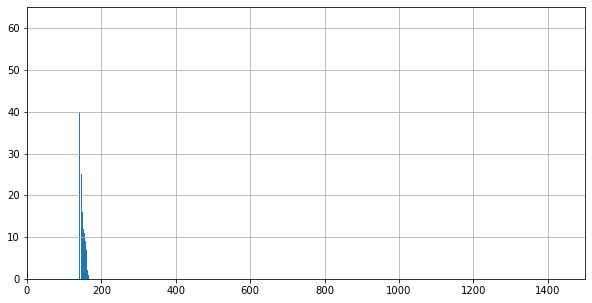

sample: slide_11_fov_06


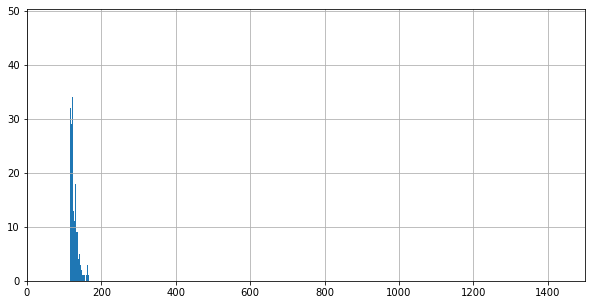

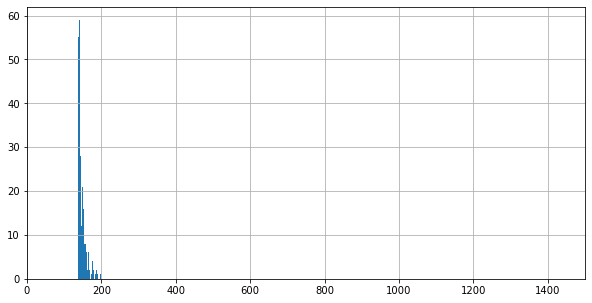

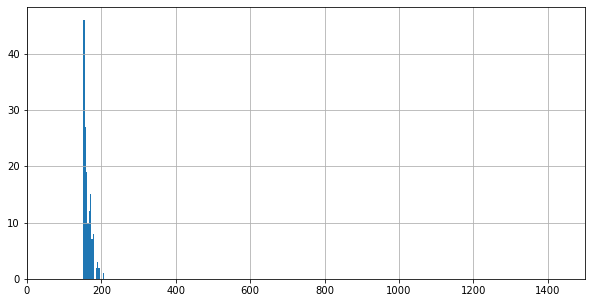

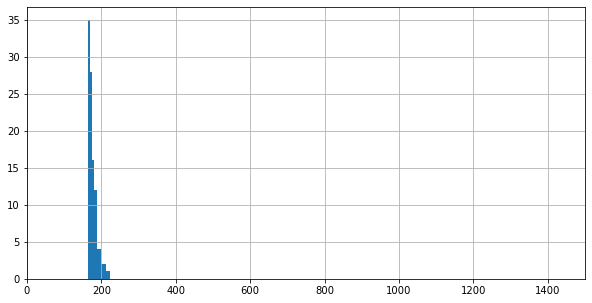

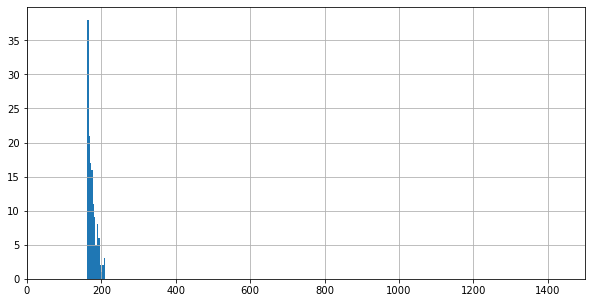

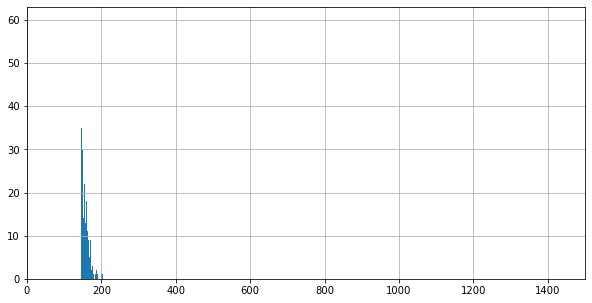

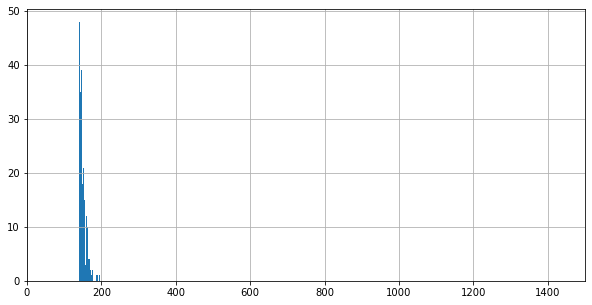

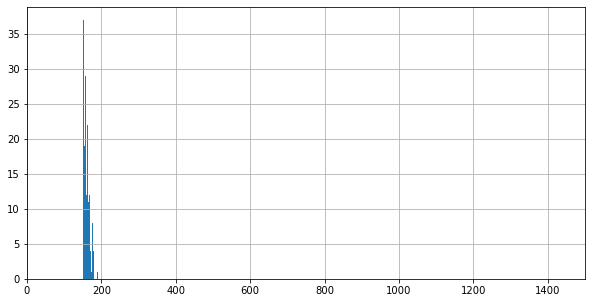

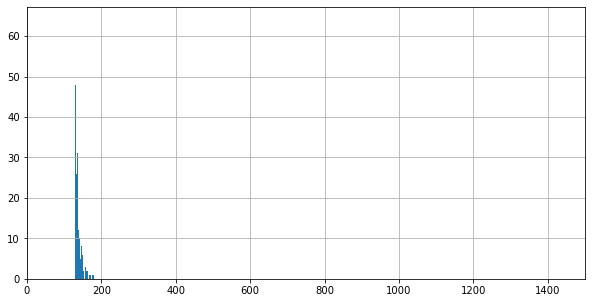

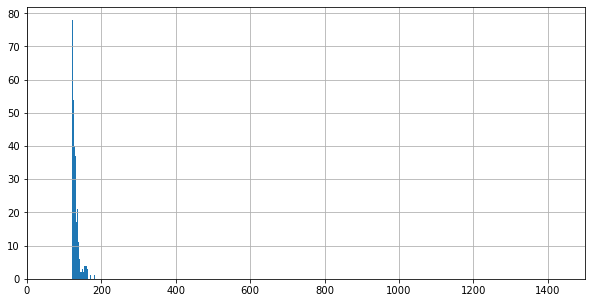

sample: slide_14_fov_01


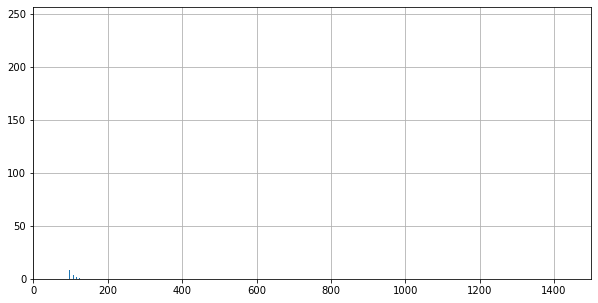

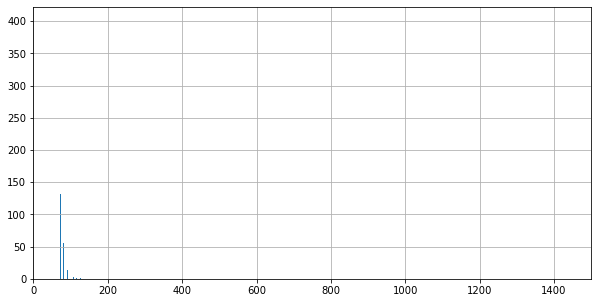

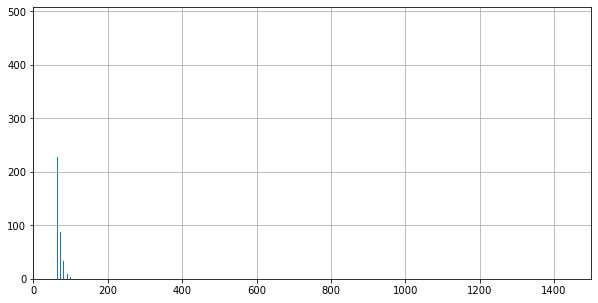

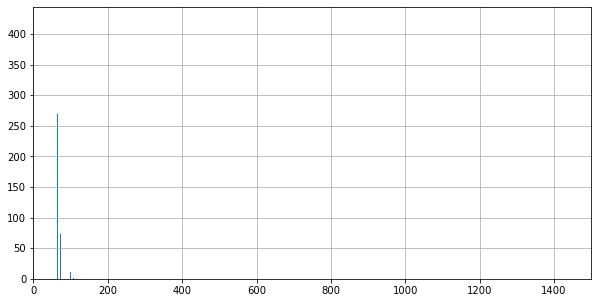

sample: slide_bmgsc_fov_01


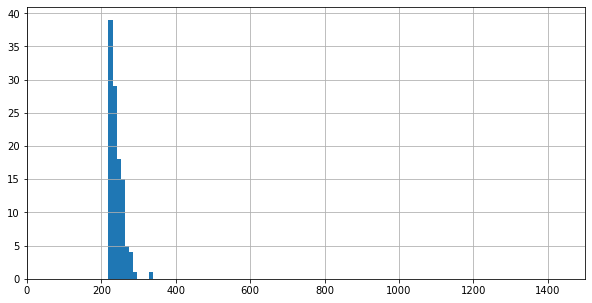

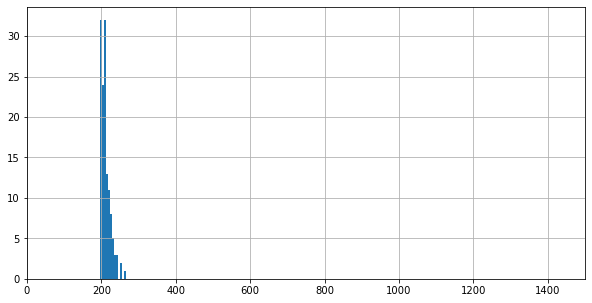

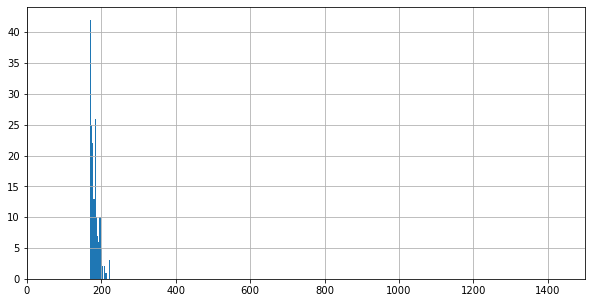

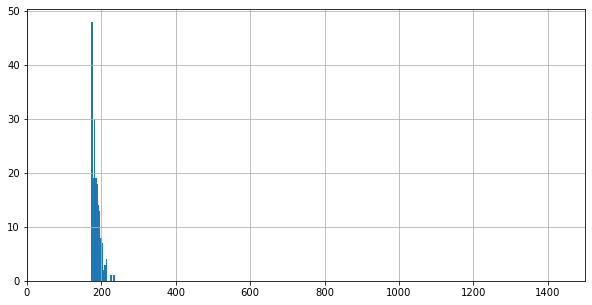

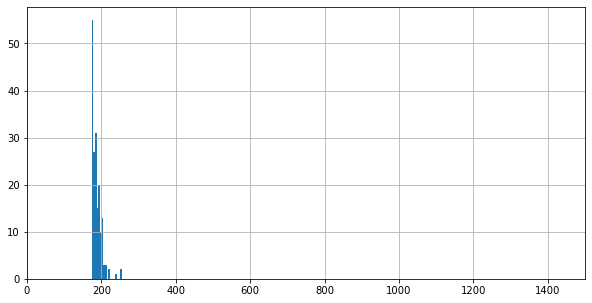

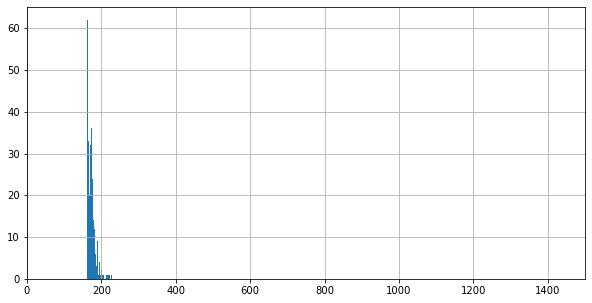

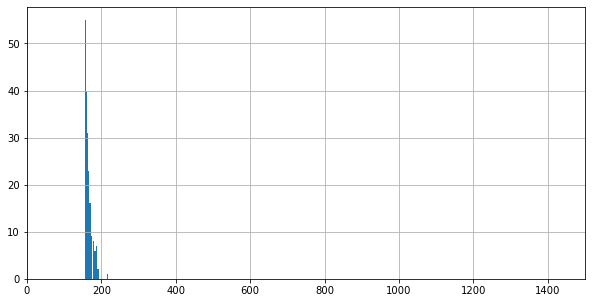

sample: slide_14_fov_03


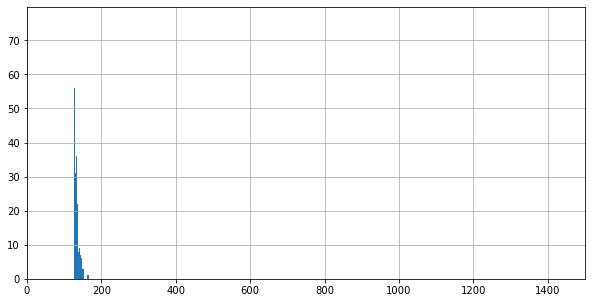

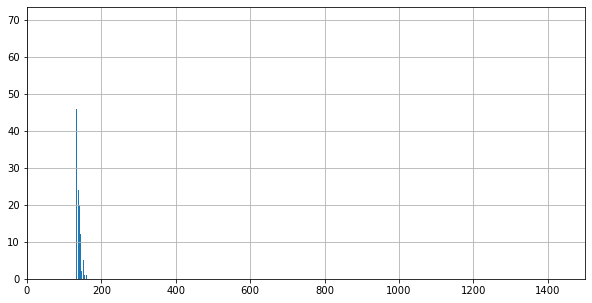

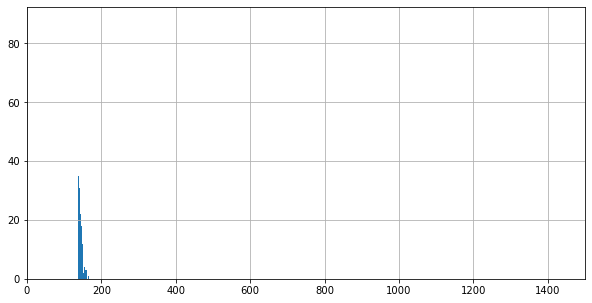

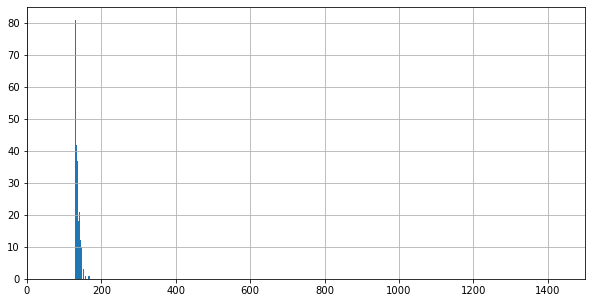

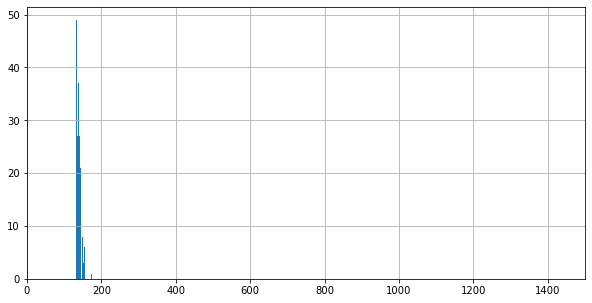

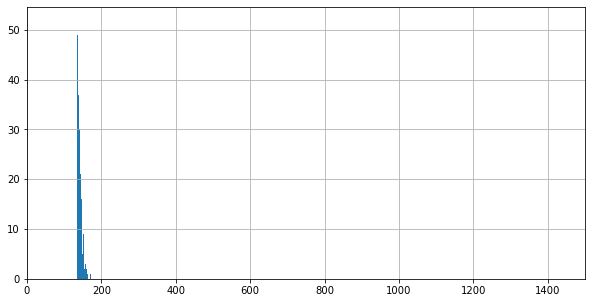

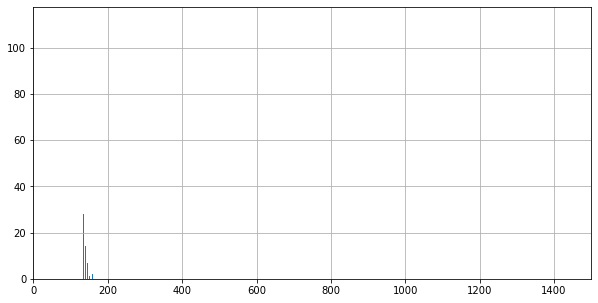

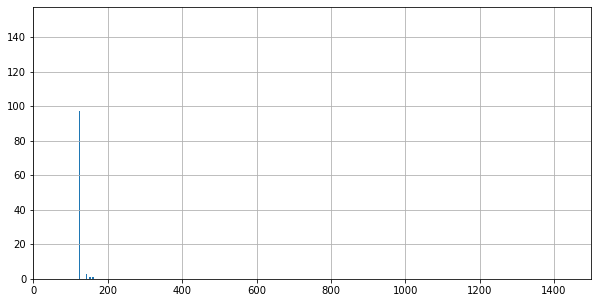

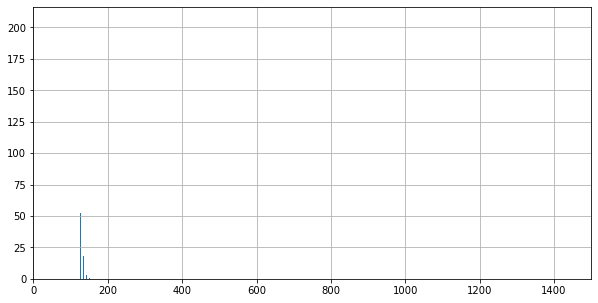

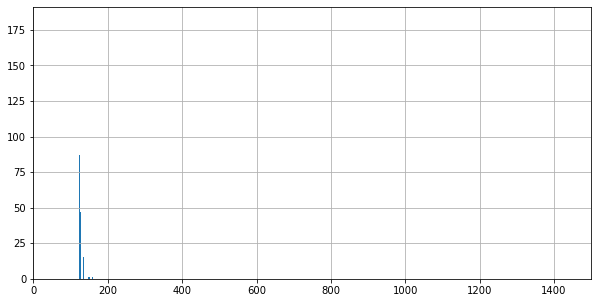

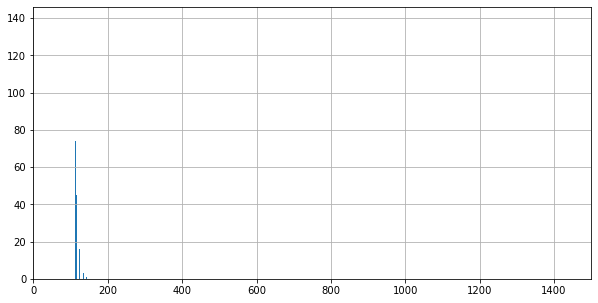

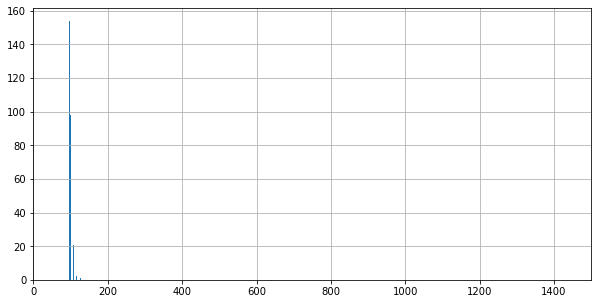

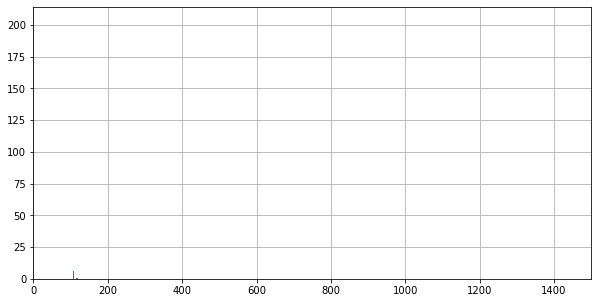

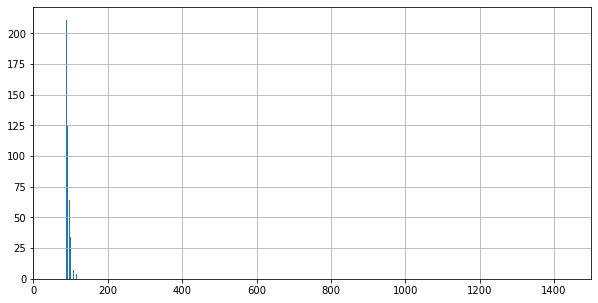

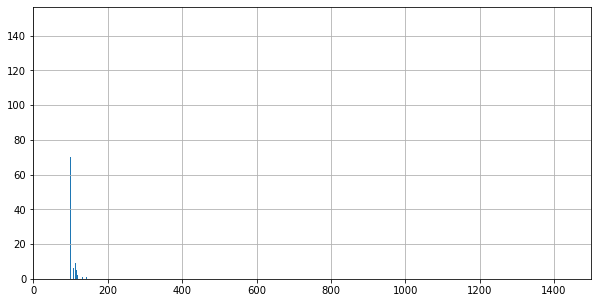

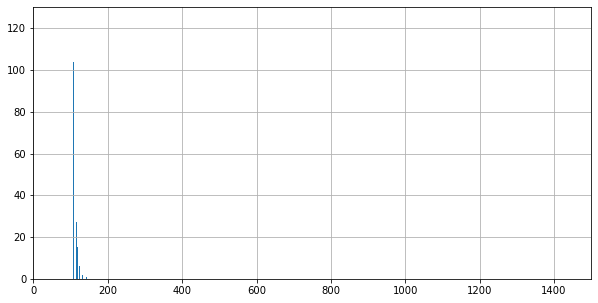

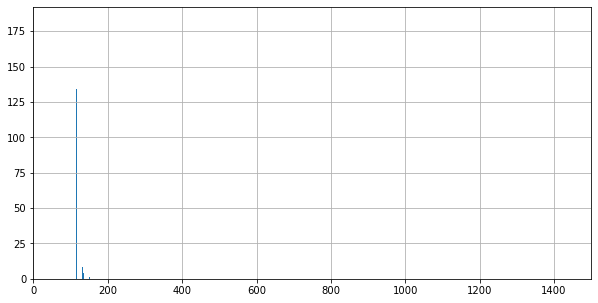

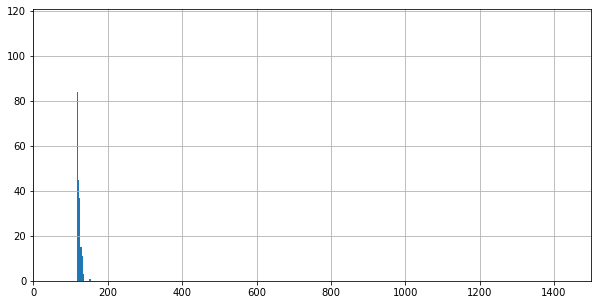

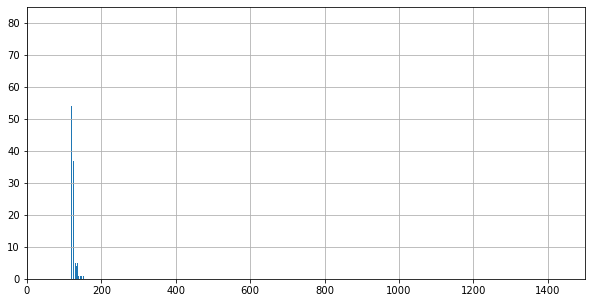

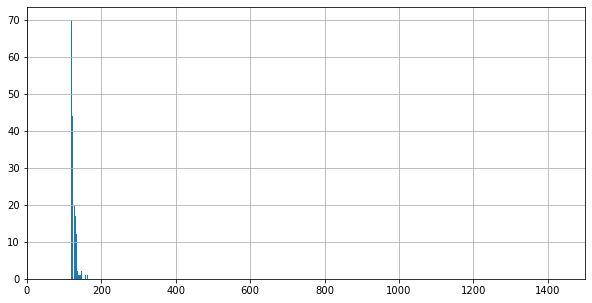

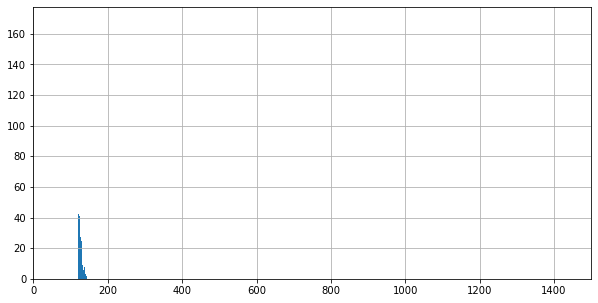

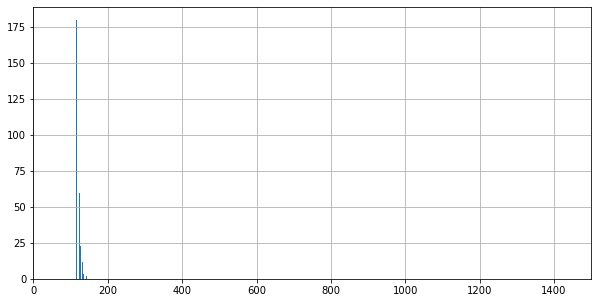

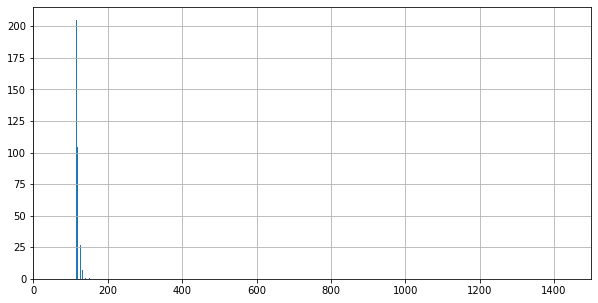

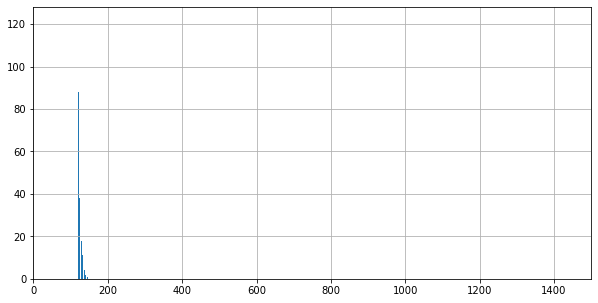

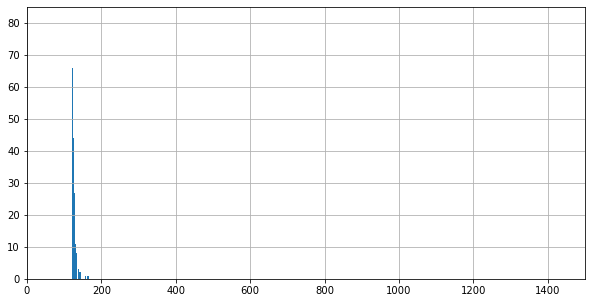

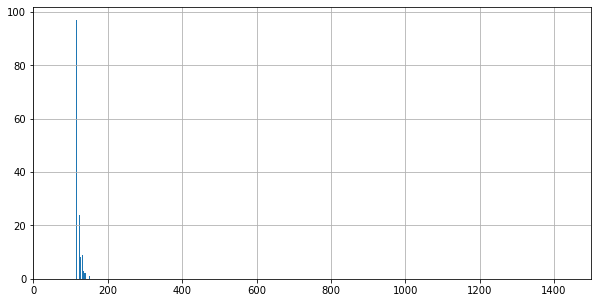

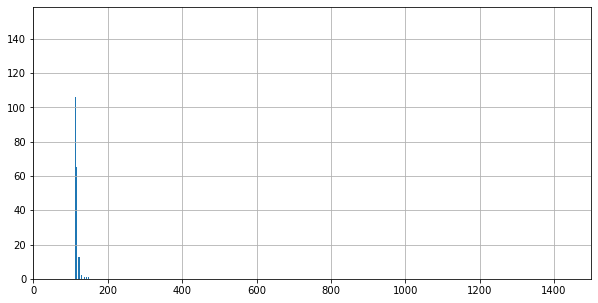

sample: slide_14_fov_05


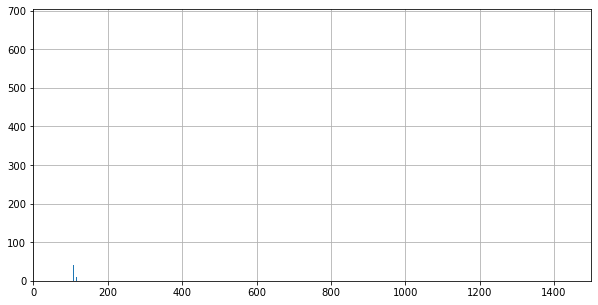

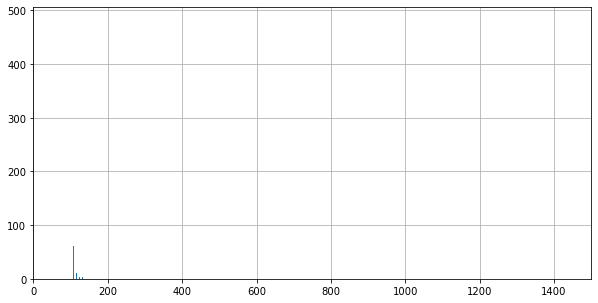

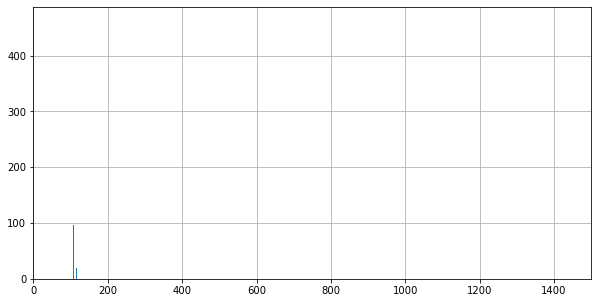

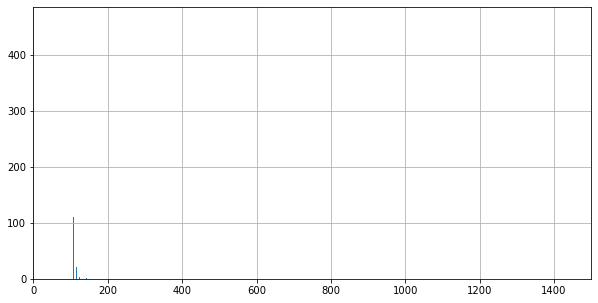

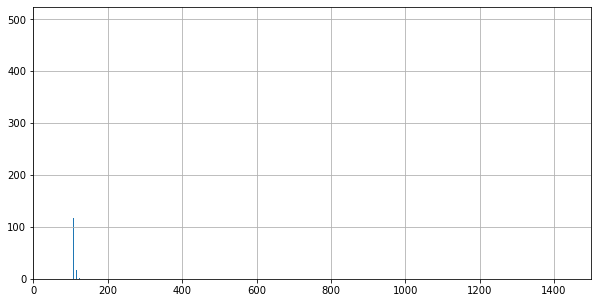

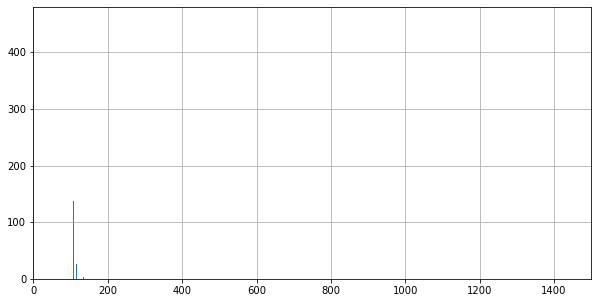

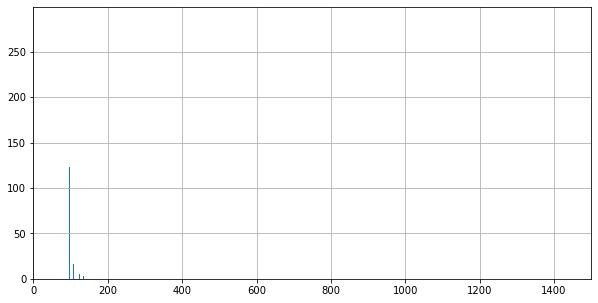

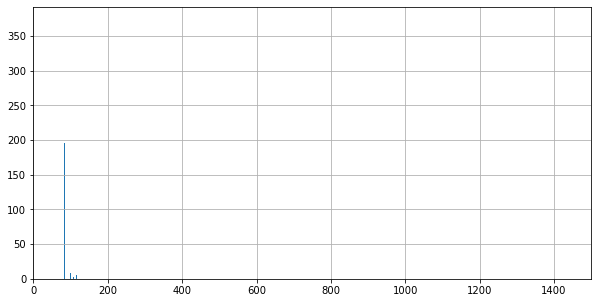

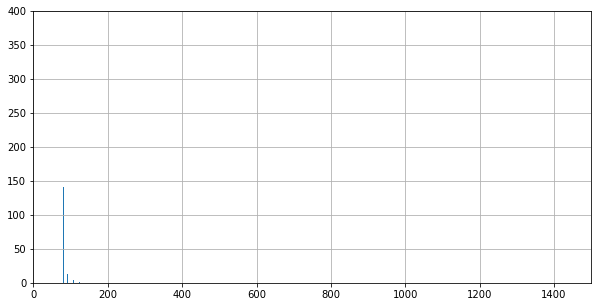

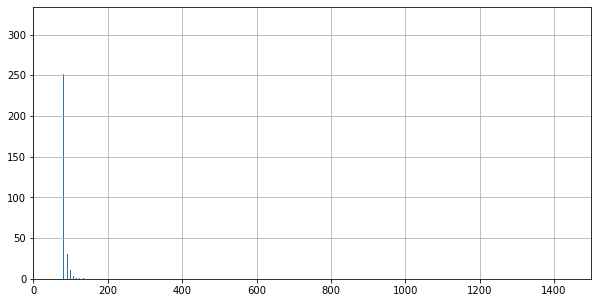

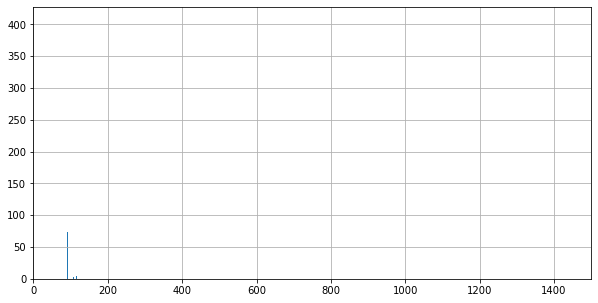

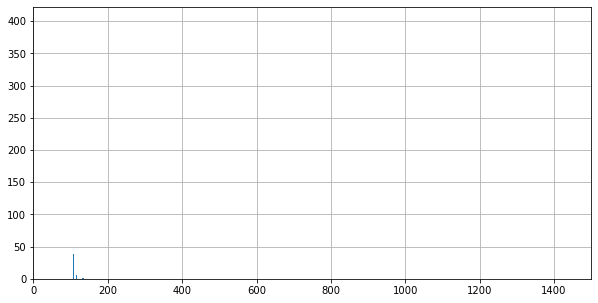

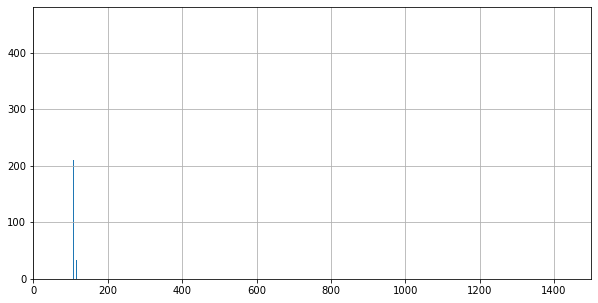

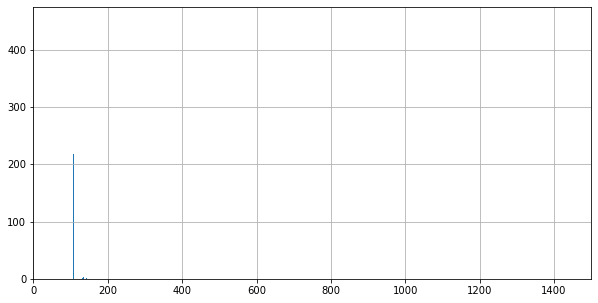

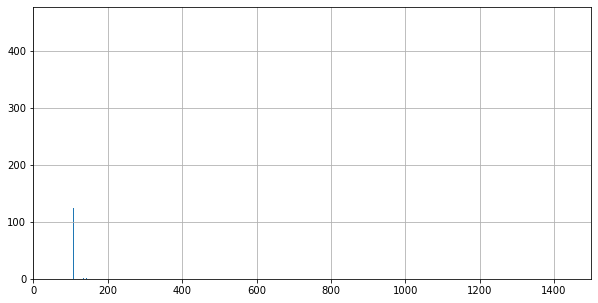

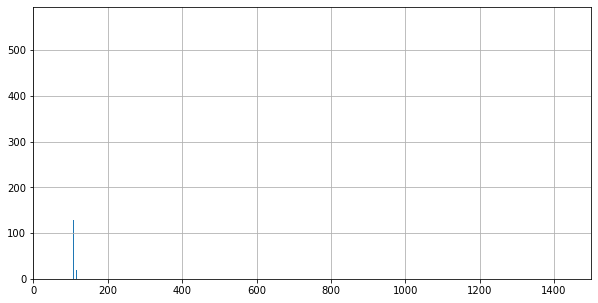

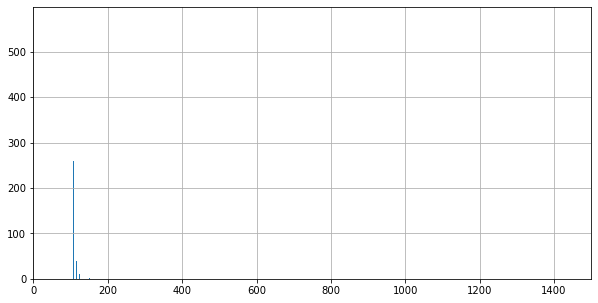

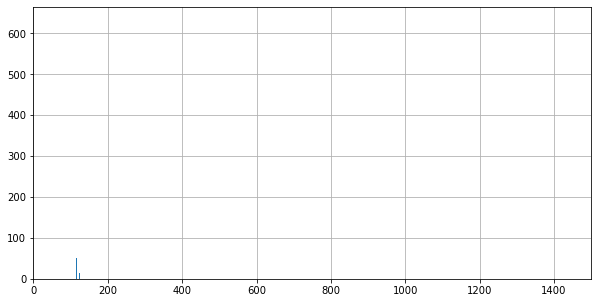

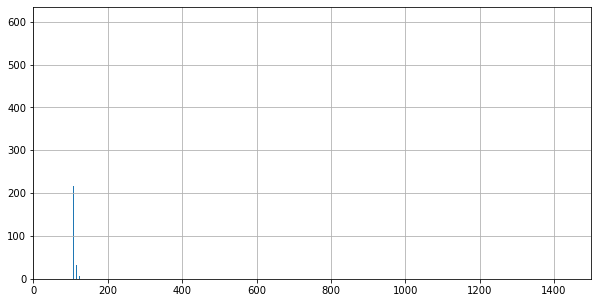

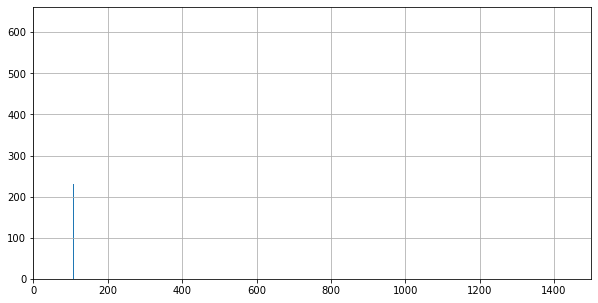

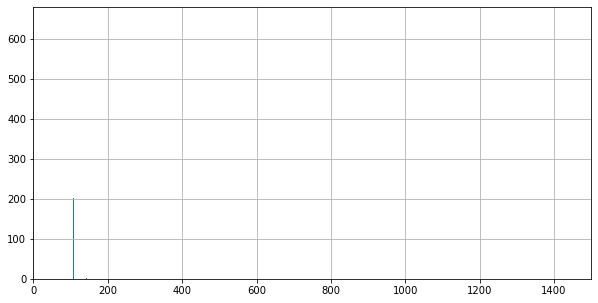

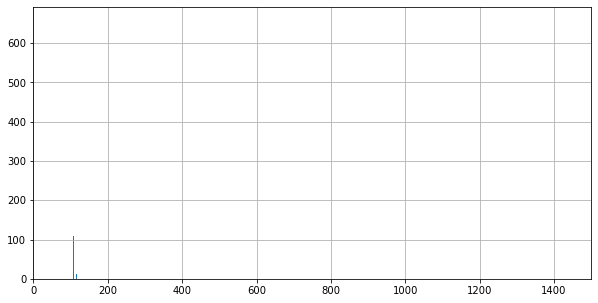

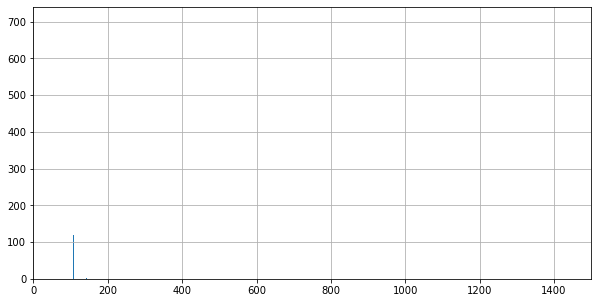

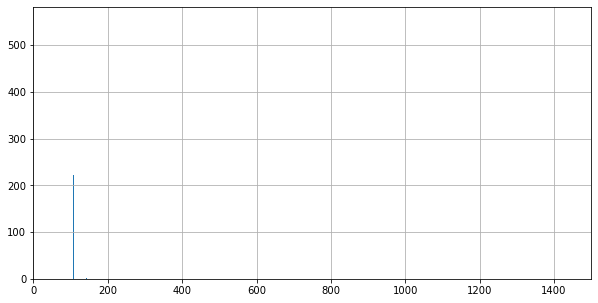

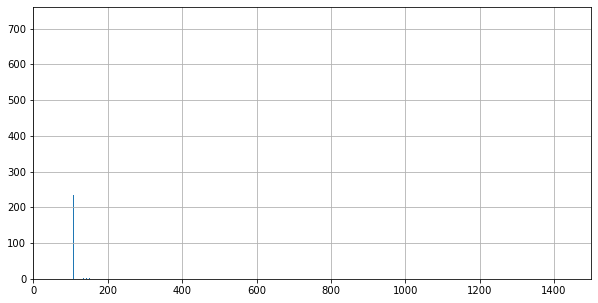

sample: slide_14_fov_06


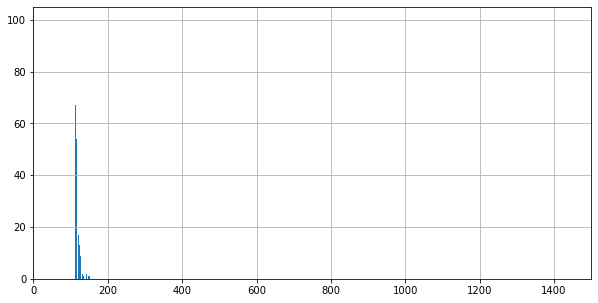

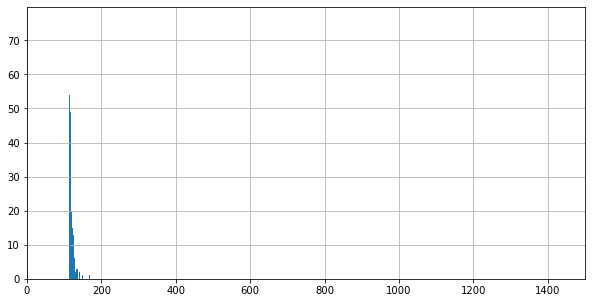

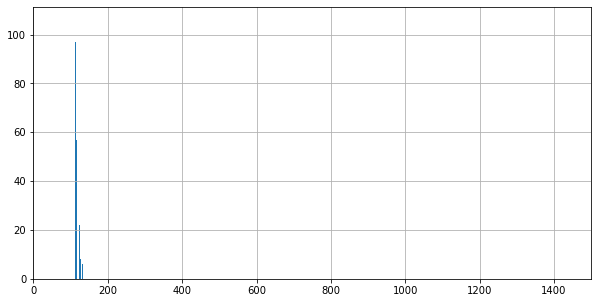

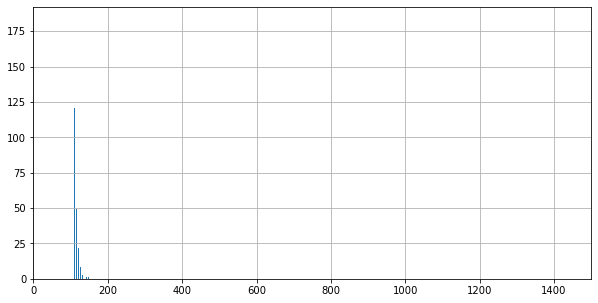

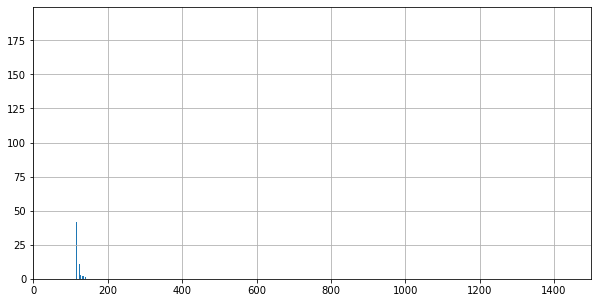

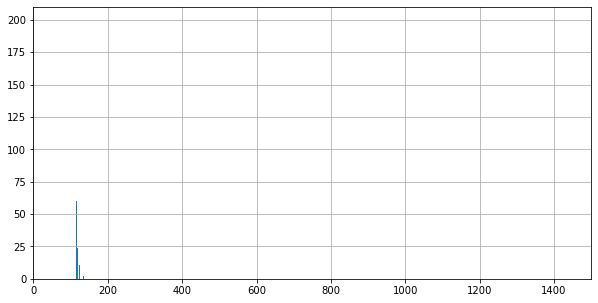

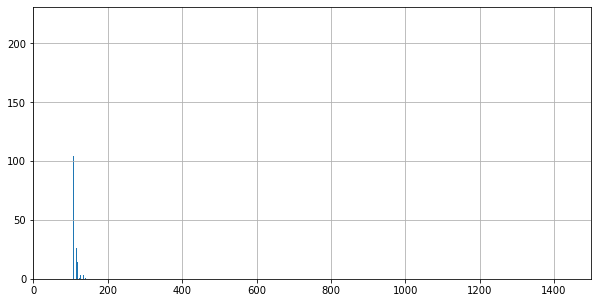

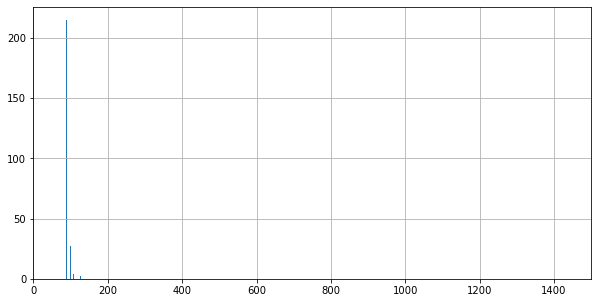

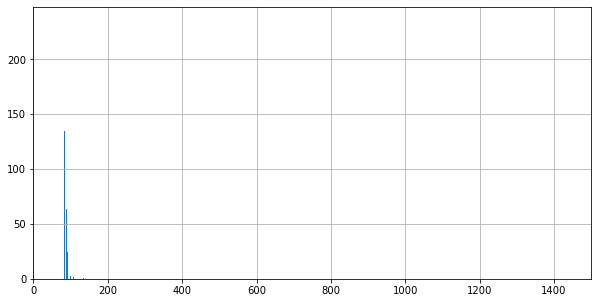

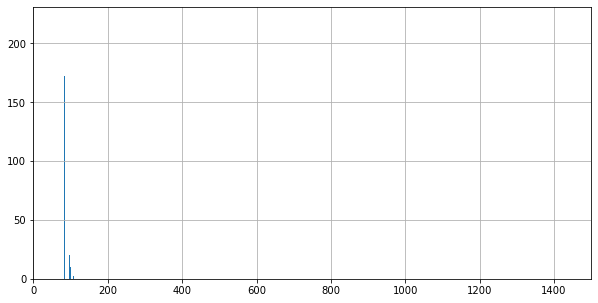

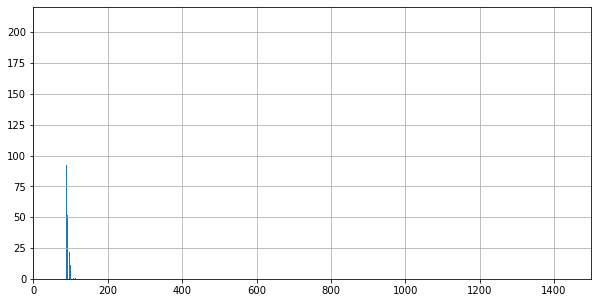

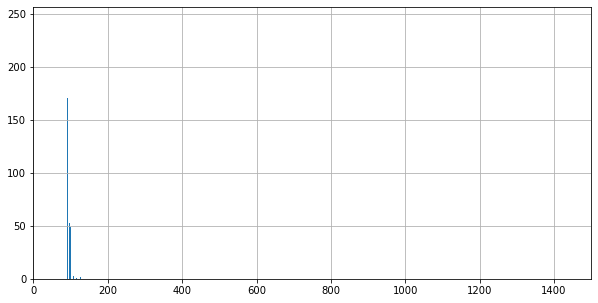

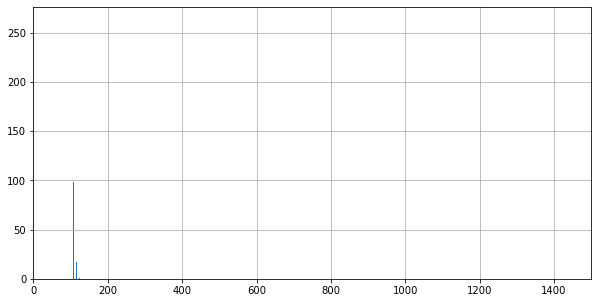

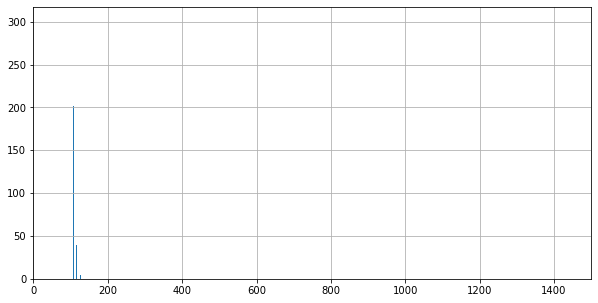

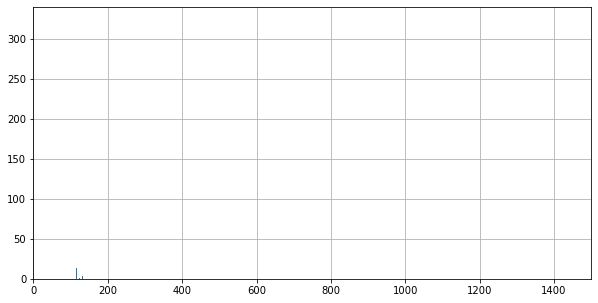

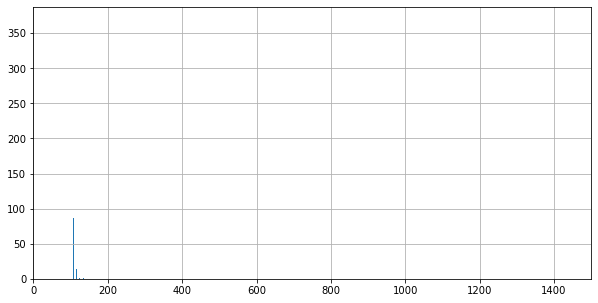

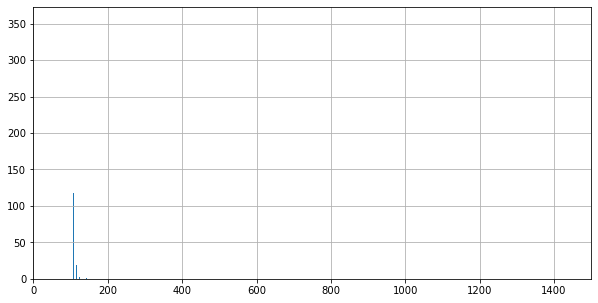

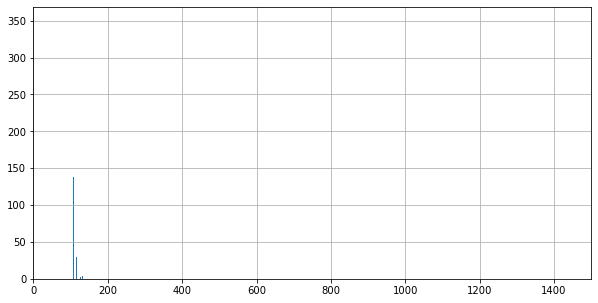

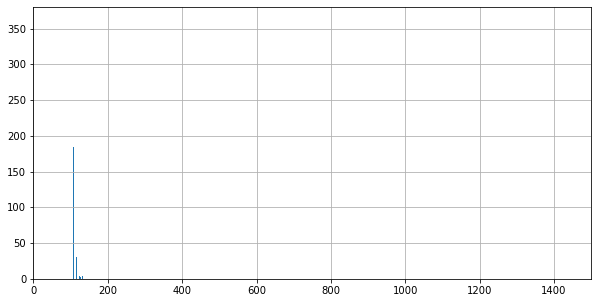

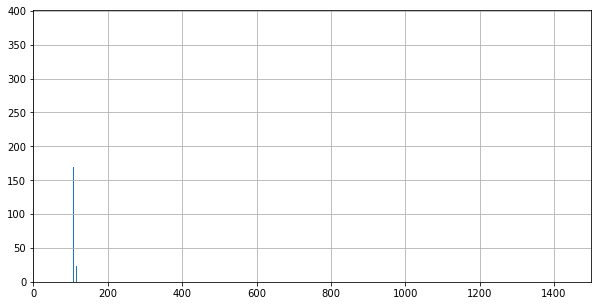

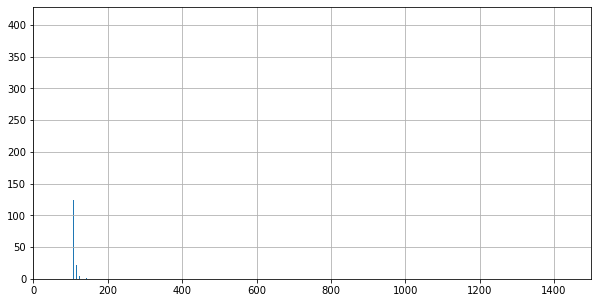

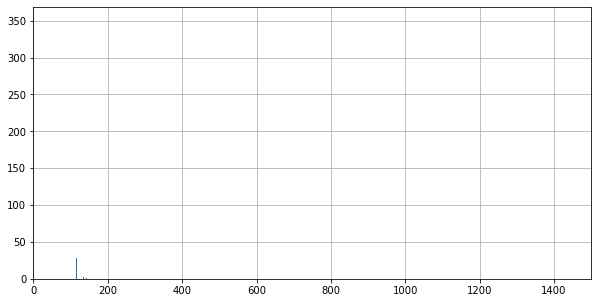

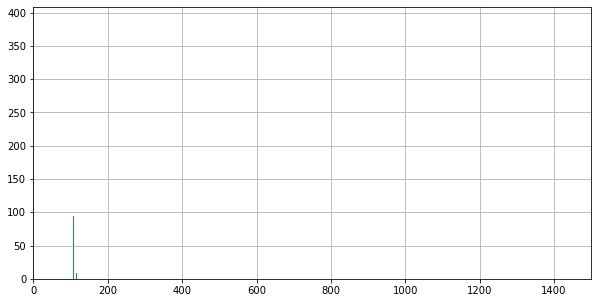

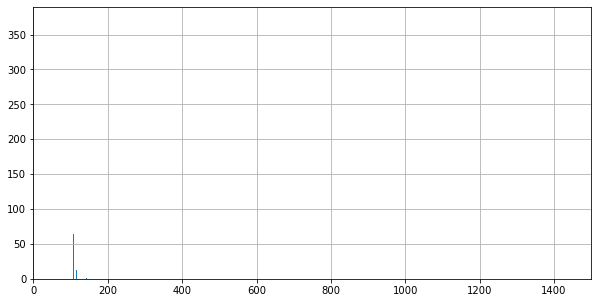

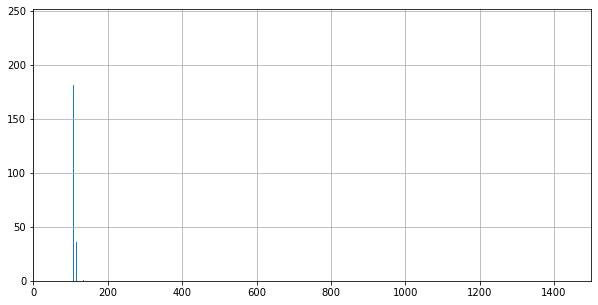

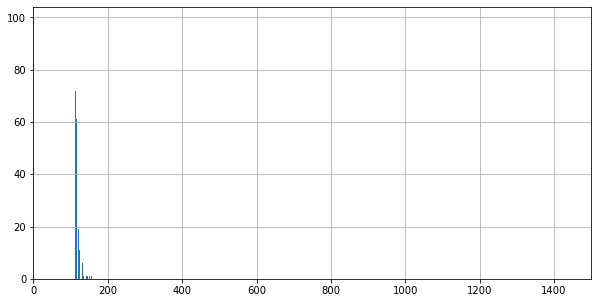

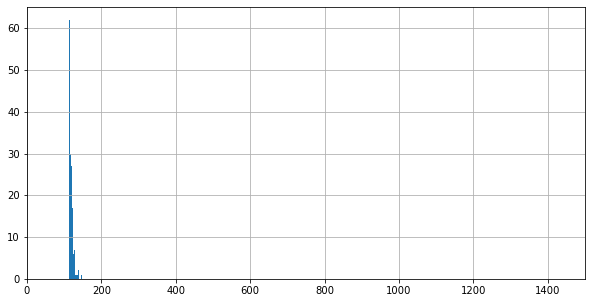

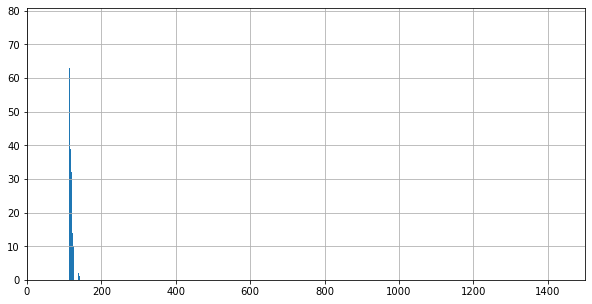

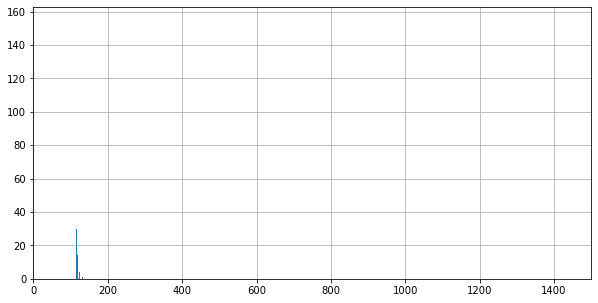

sample: slide_14_fov_07


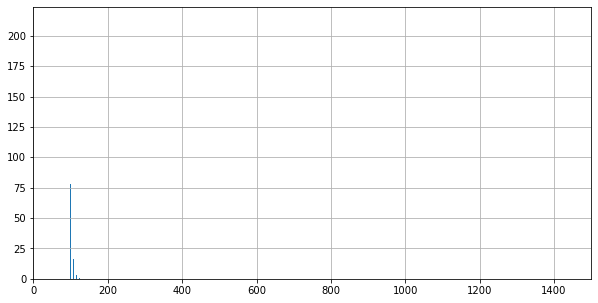

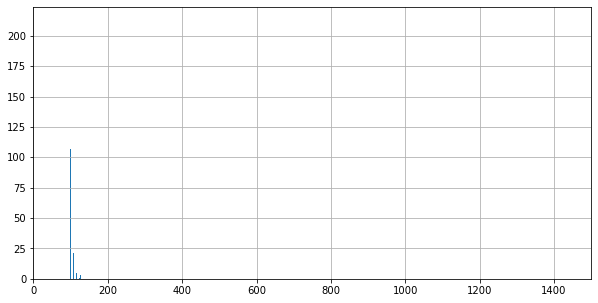

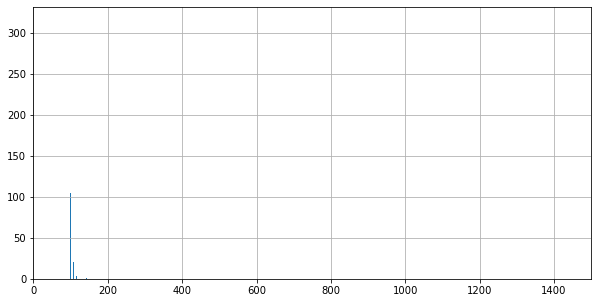

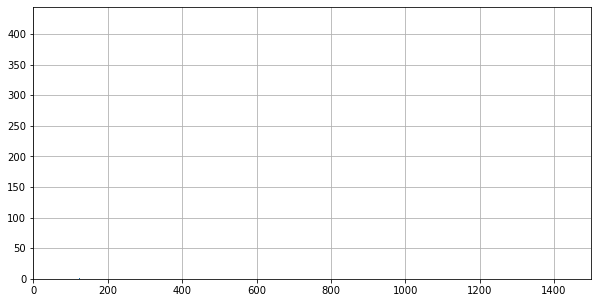

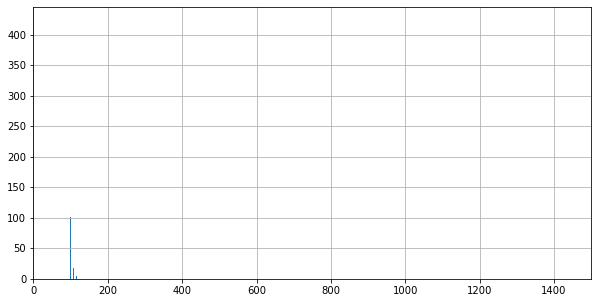

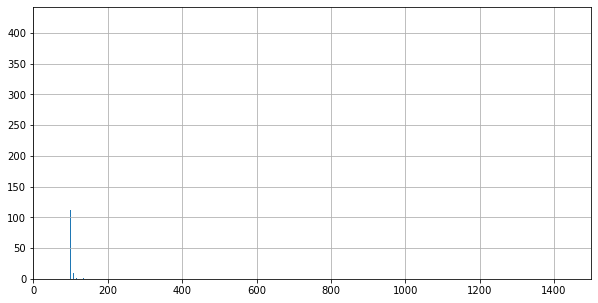

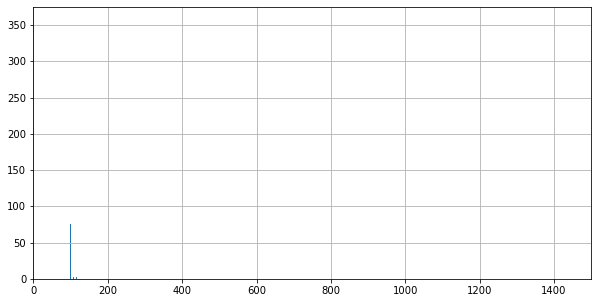

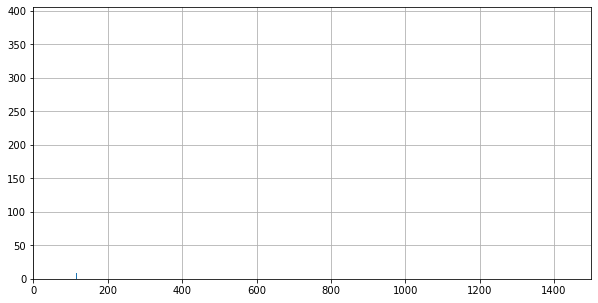

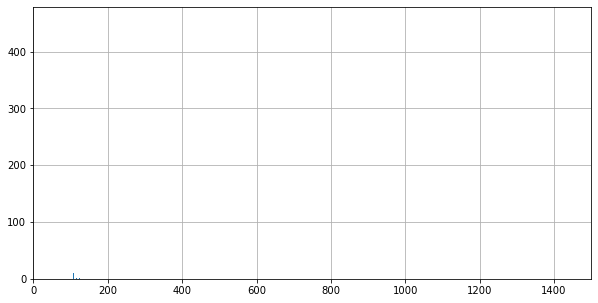

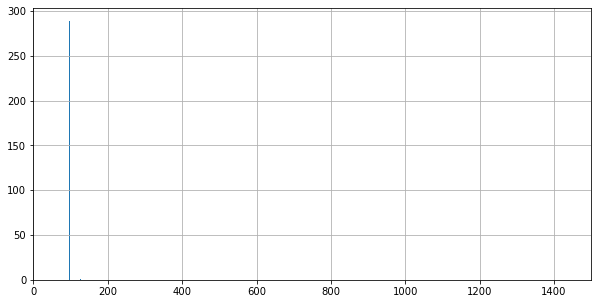

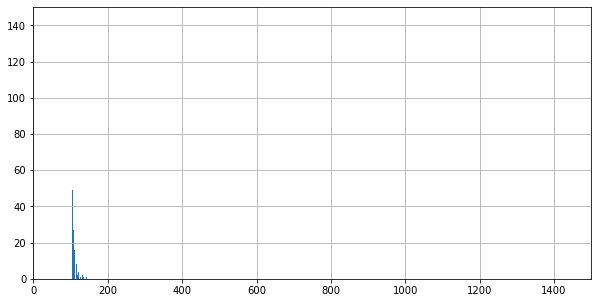

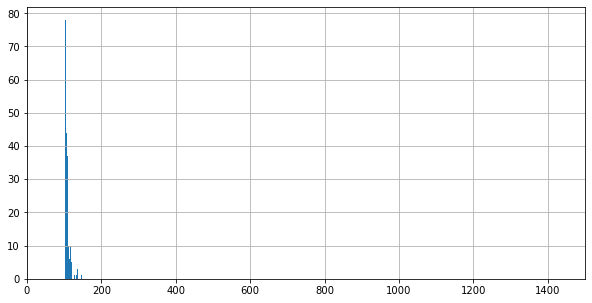

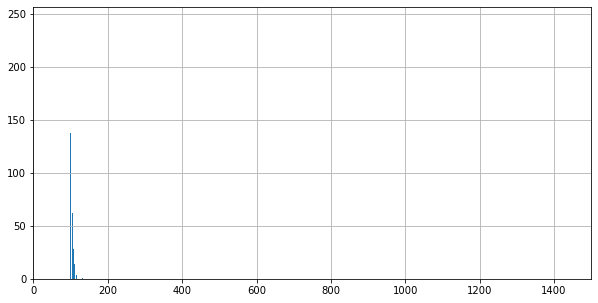

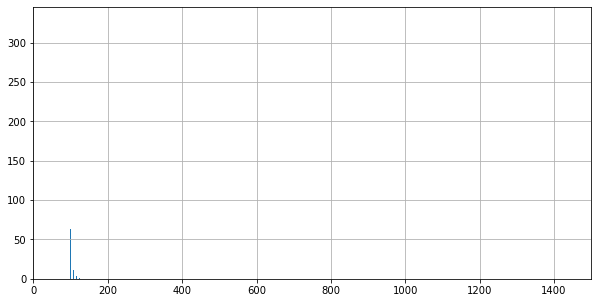

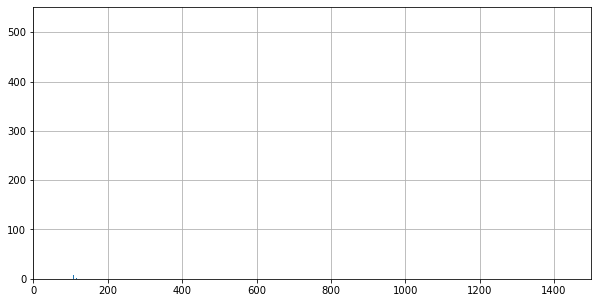

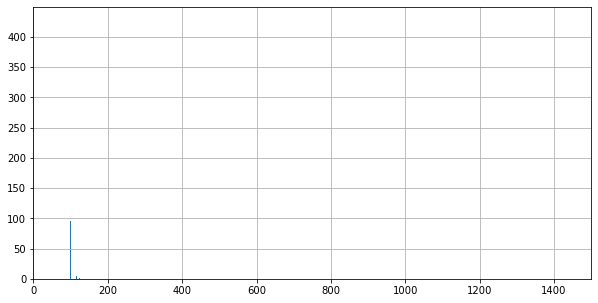

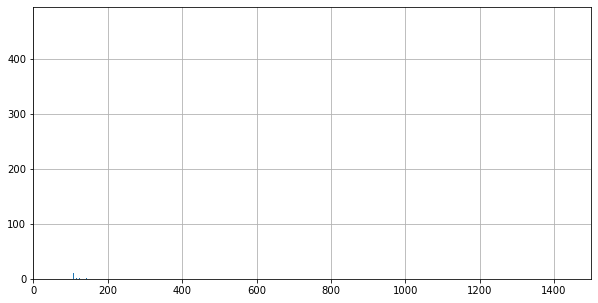

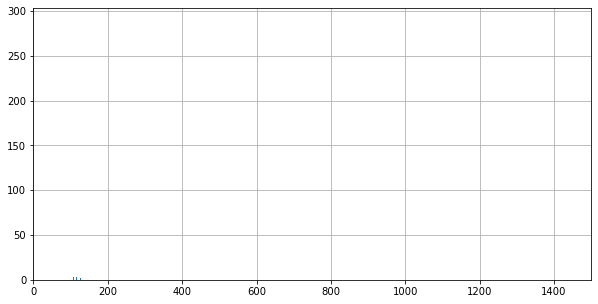

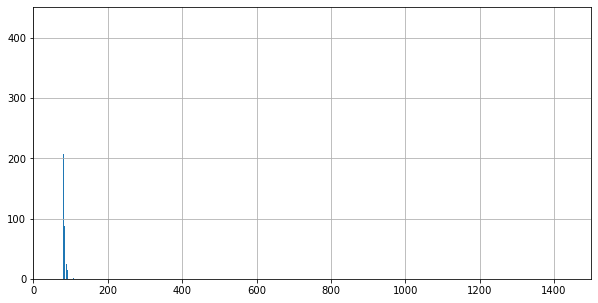

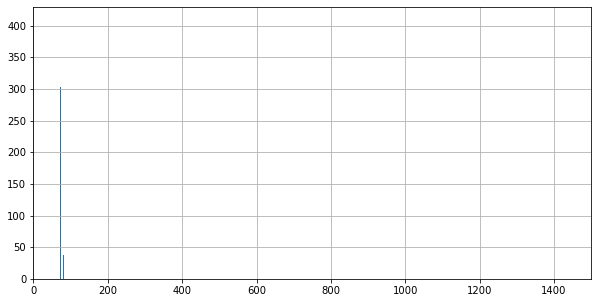

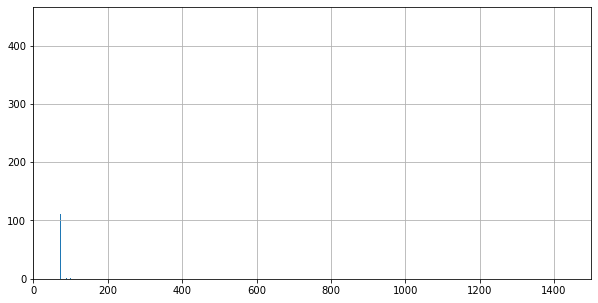

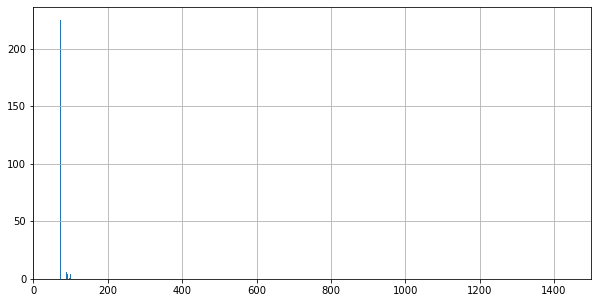

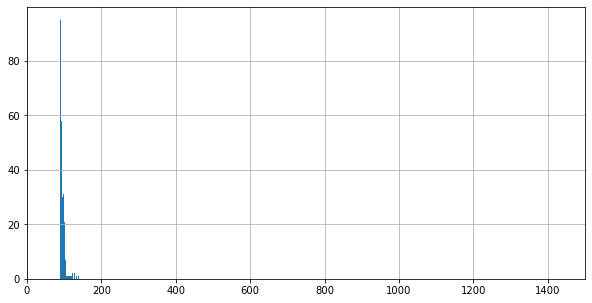

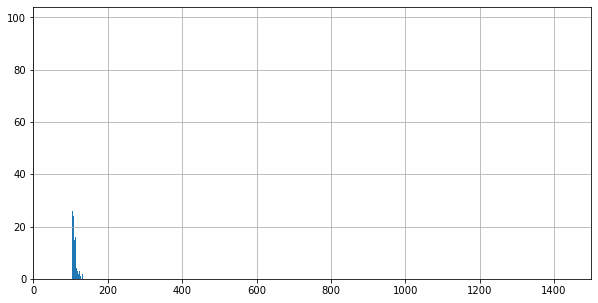

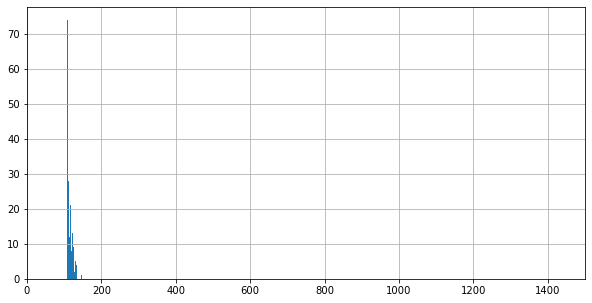

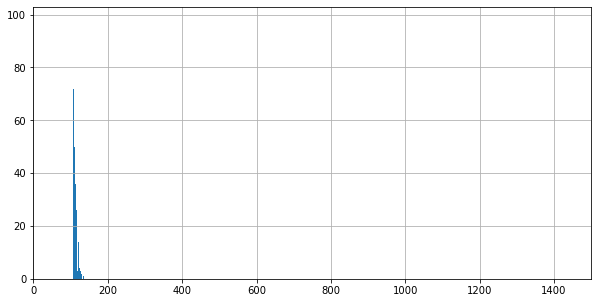

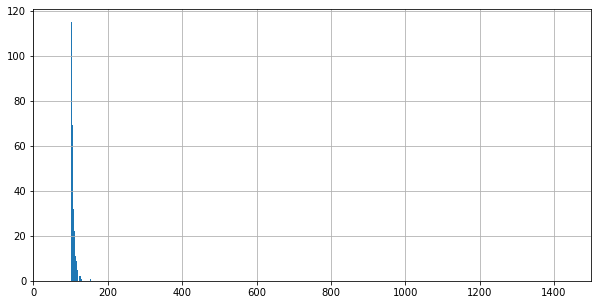

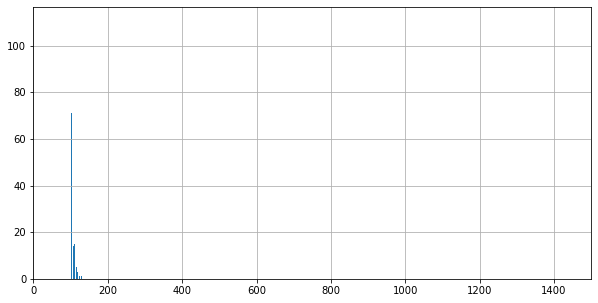

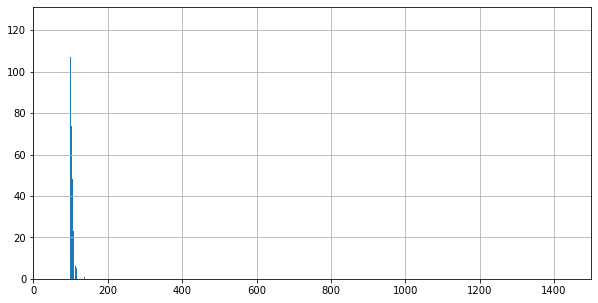

sample: slide_14_fov_09


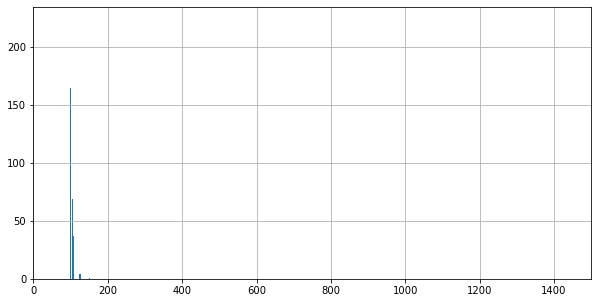

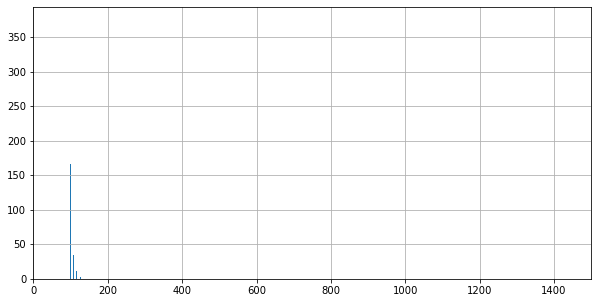

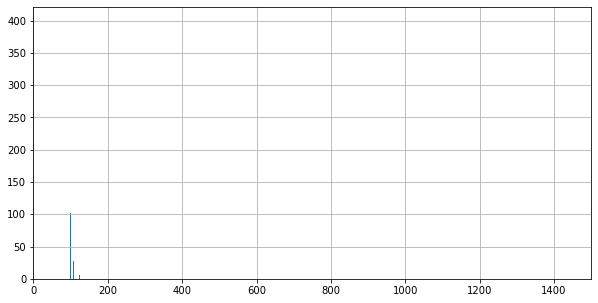

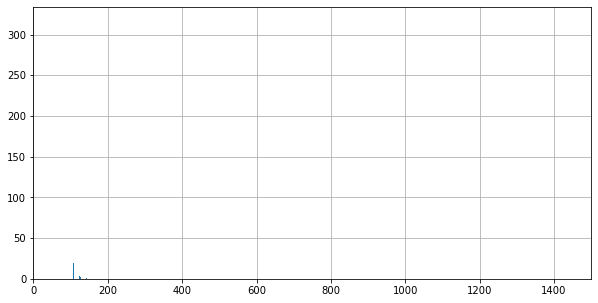

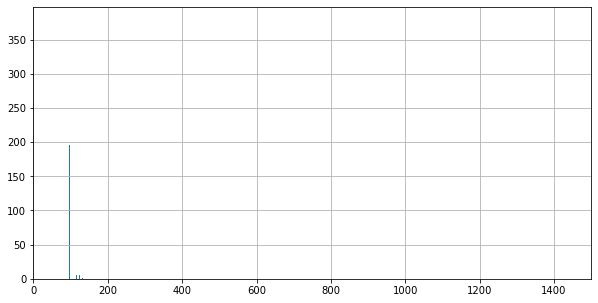

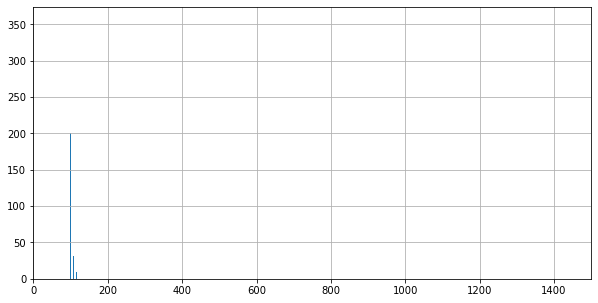

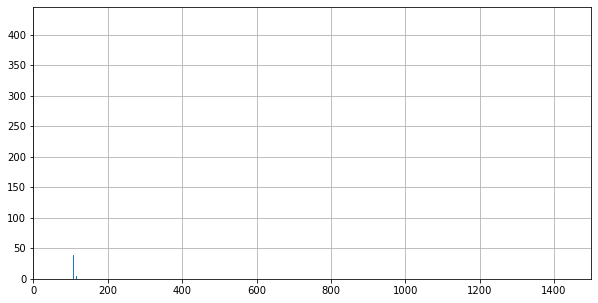

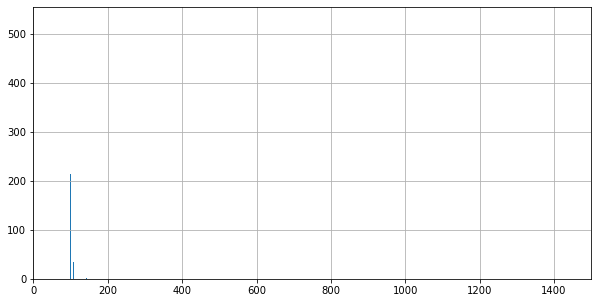

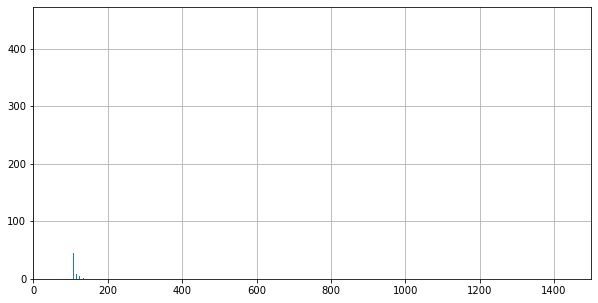

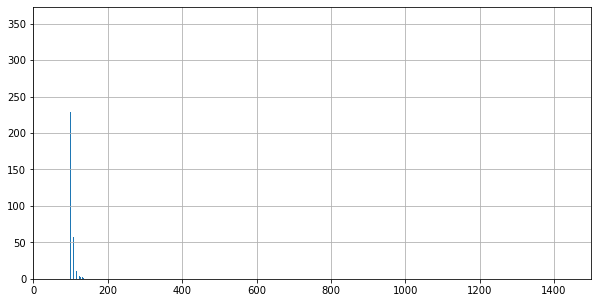

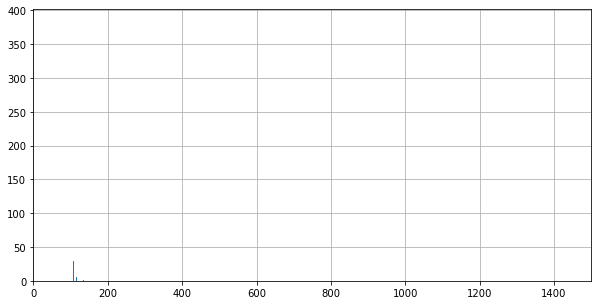

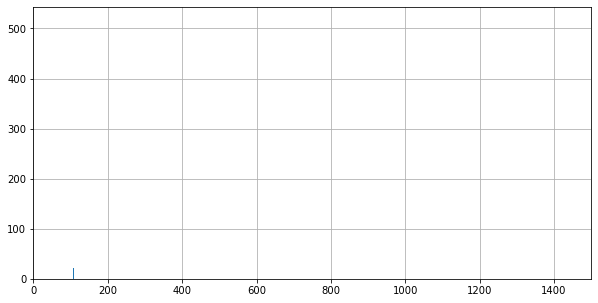

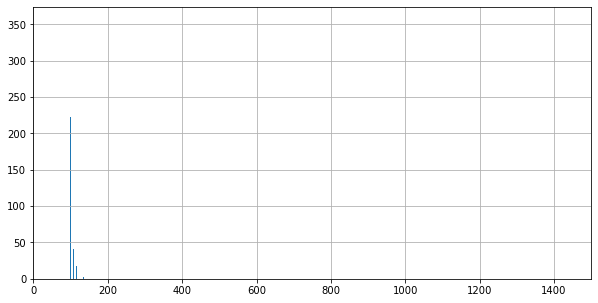

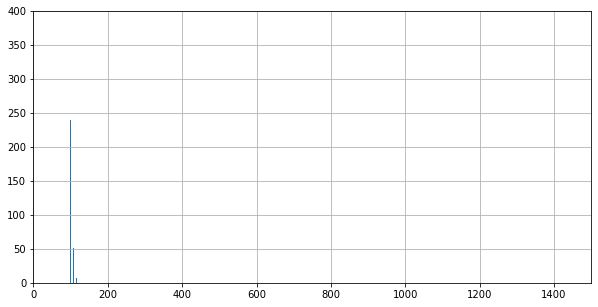

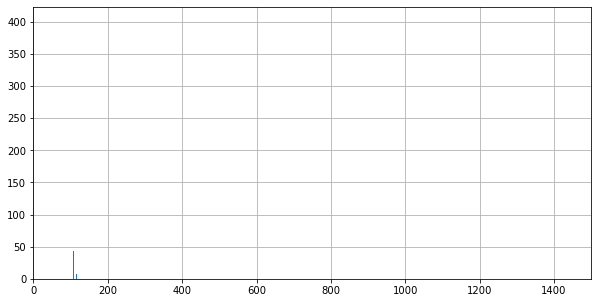

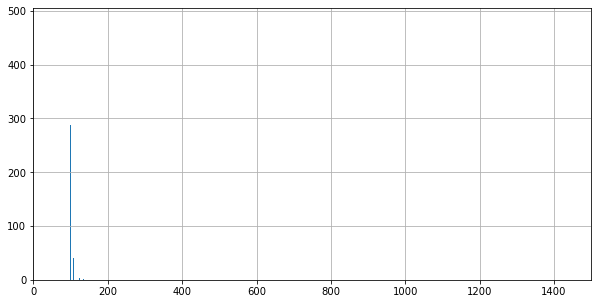

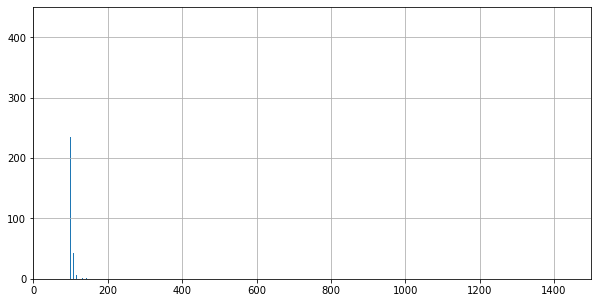

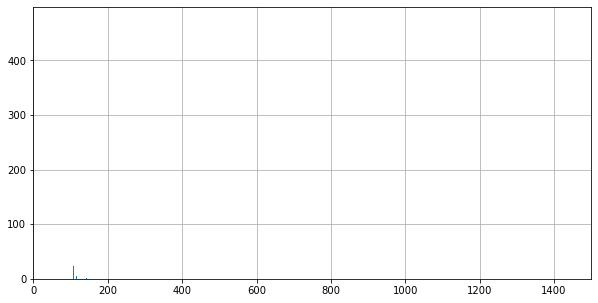

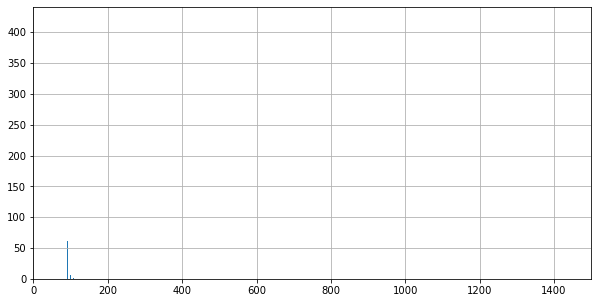

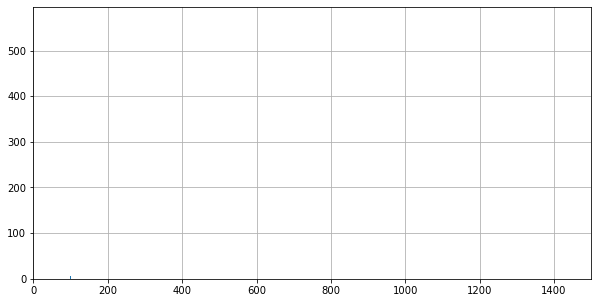

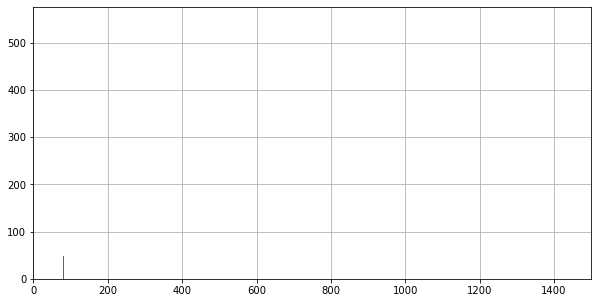

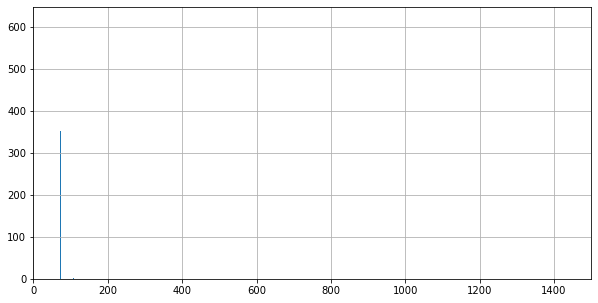

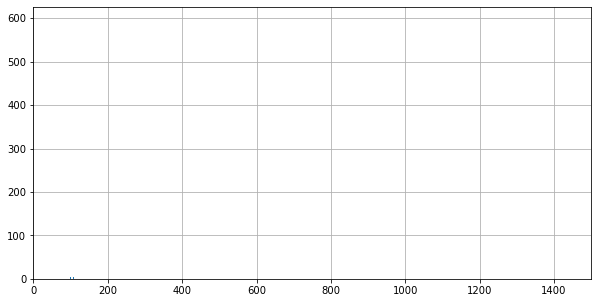

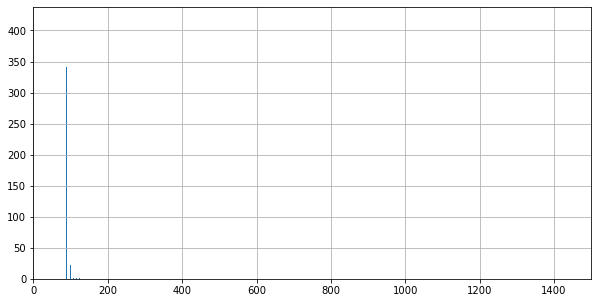

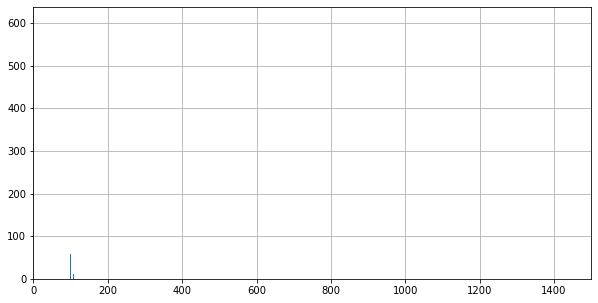

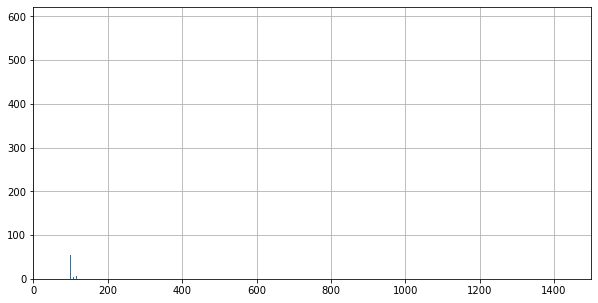

sample: slide_ec_fov_02


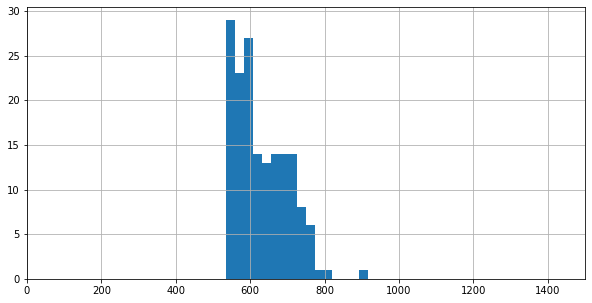

sample: slide_ec_fov_03


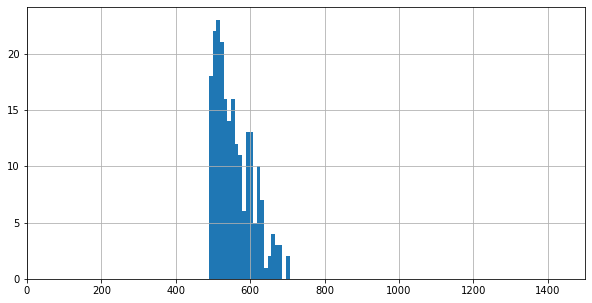

sample: slide_bmgsp_fov_01


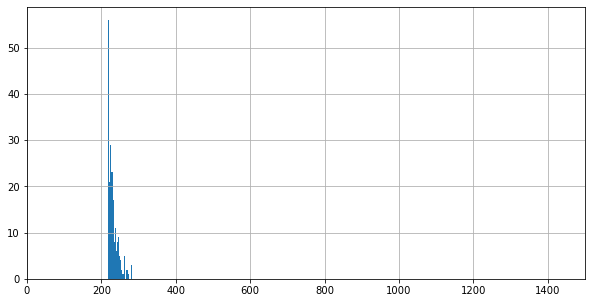

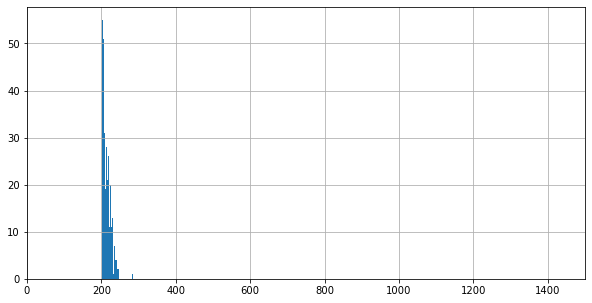

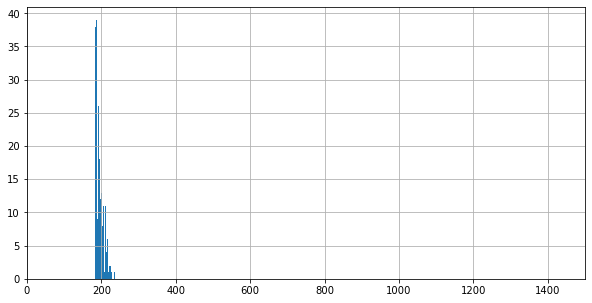

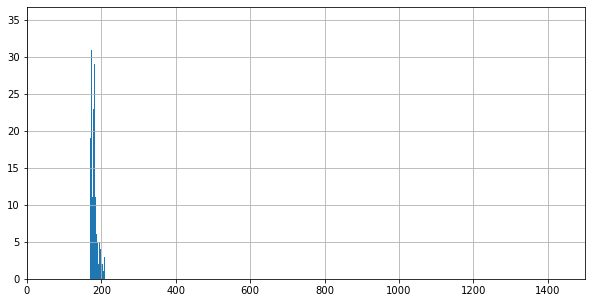

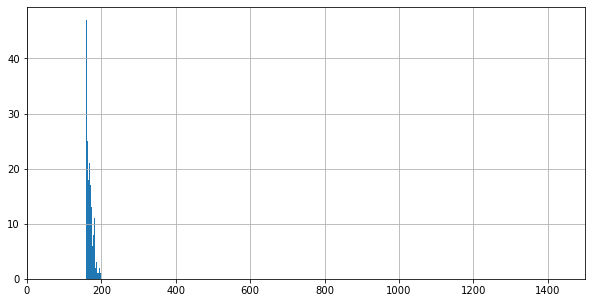

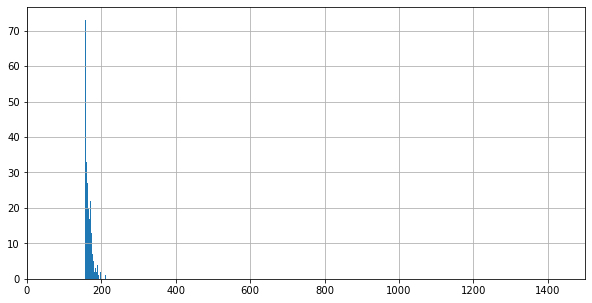

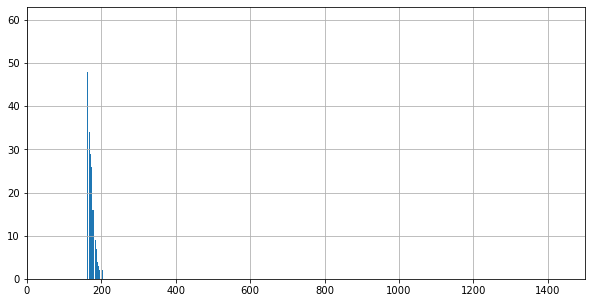

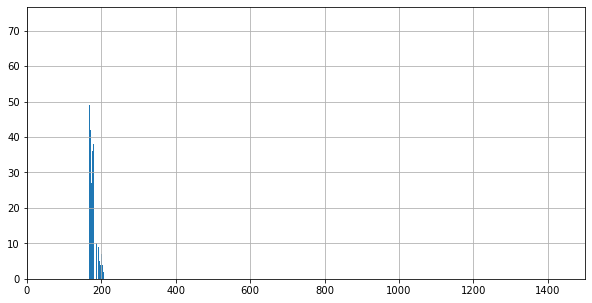

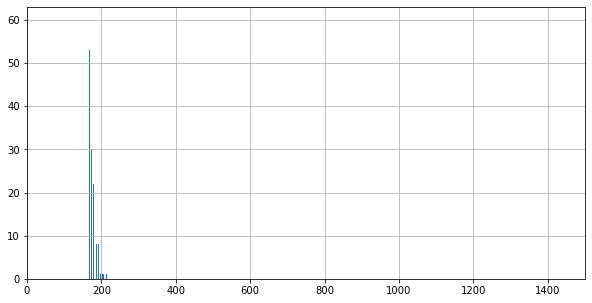

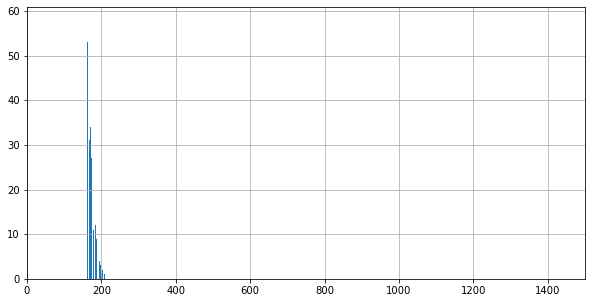

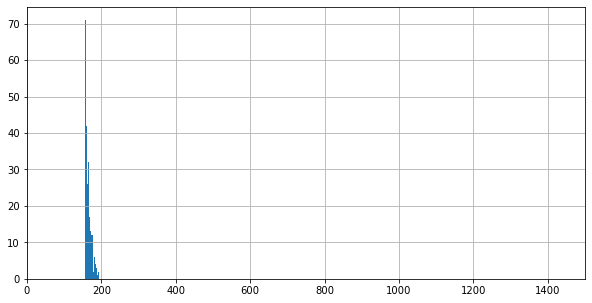

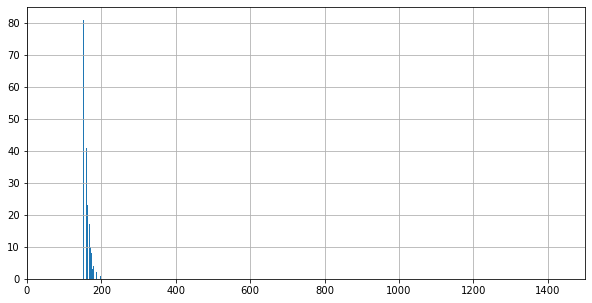

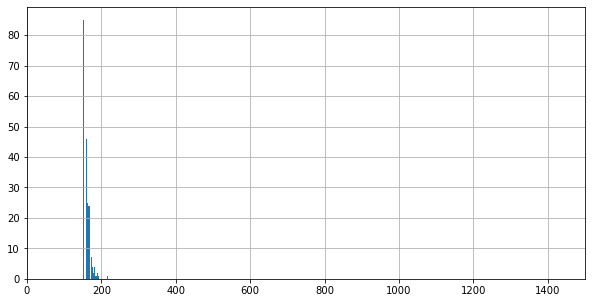

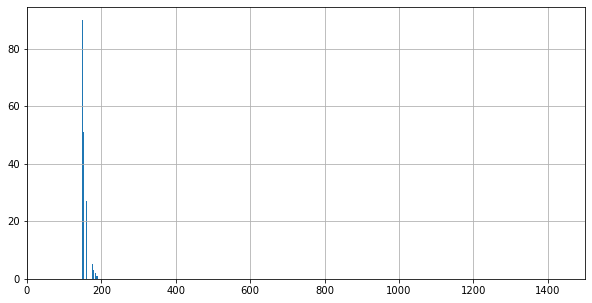

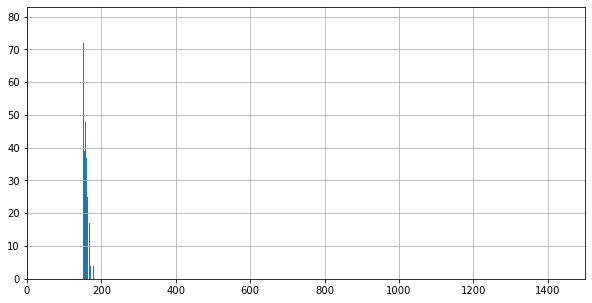

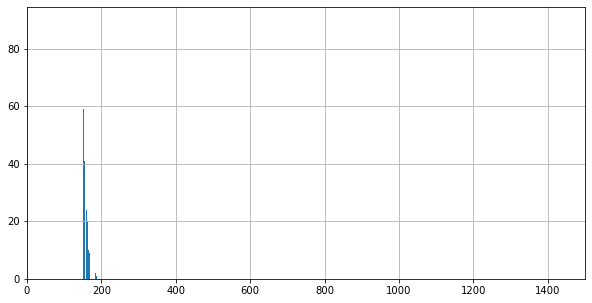

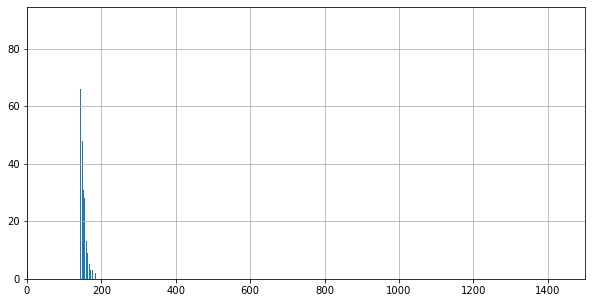

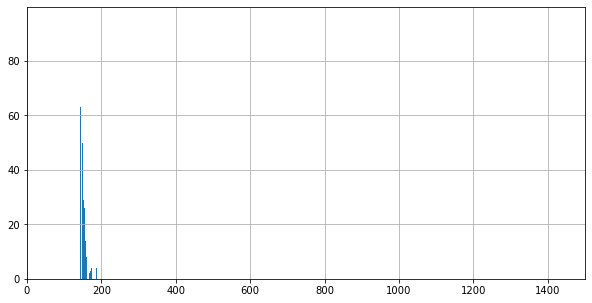

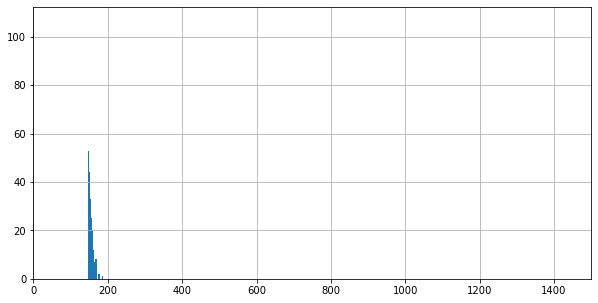

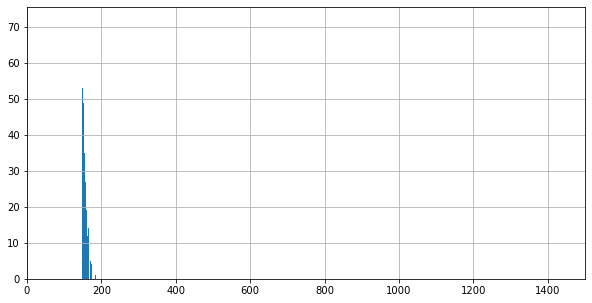

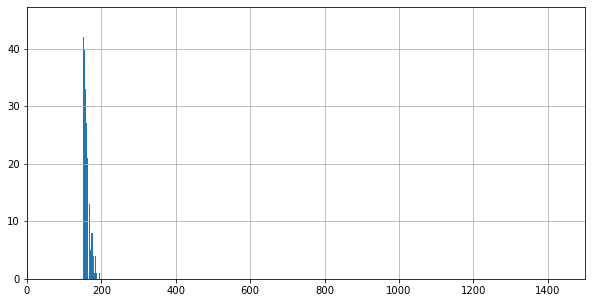

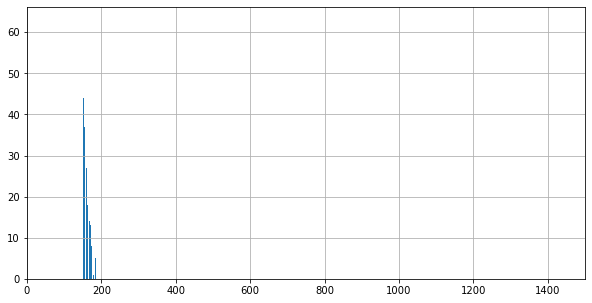

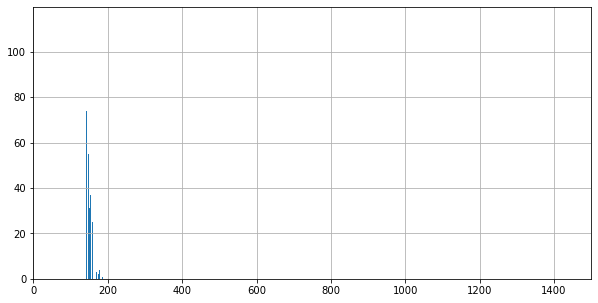

sample: slide_ec_fov_01


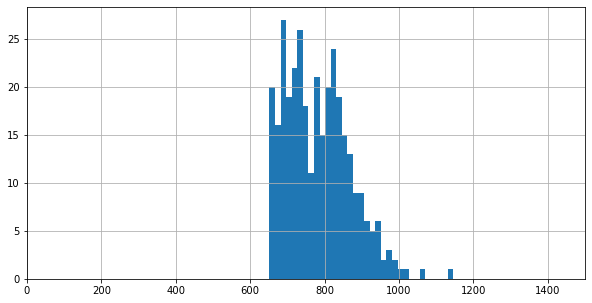

sample: slide_bmgsp_fov_02


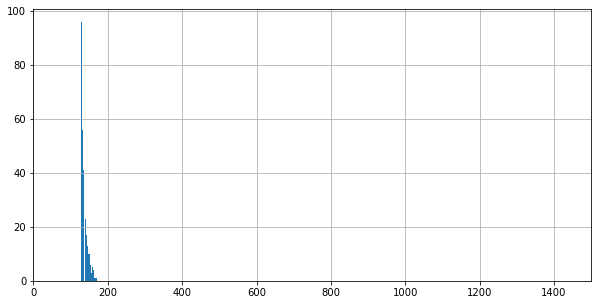

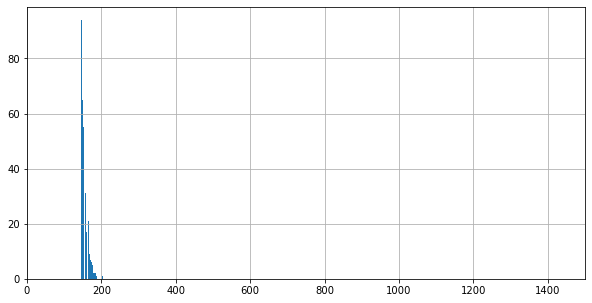

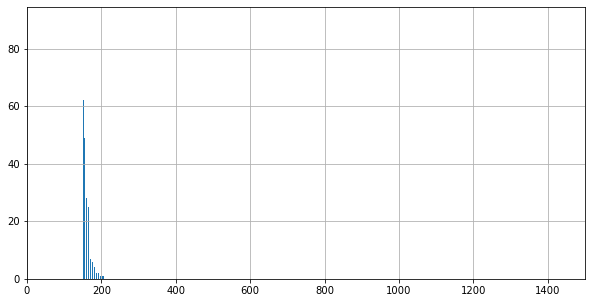

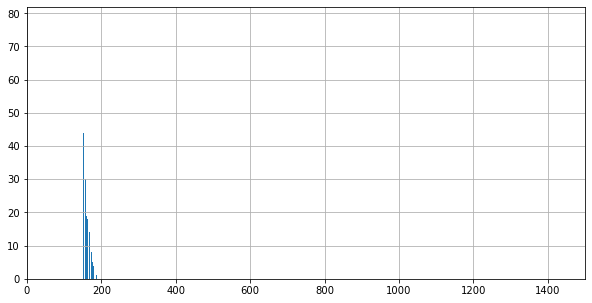

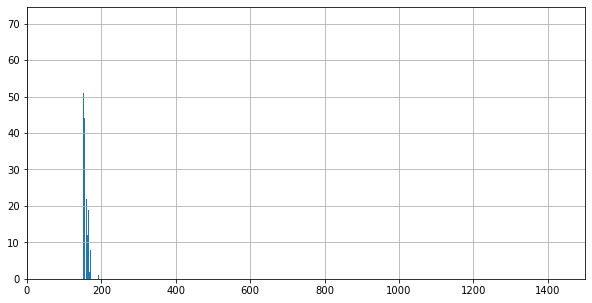

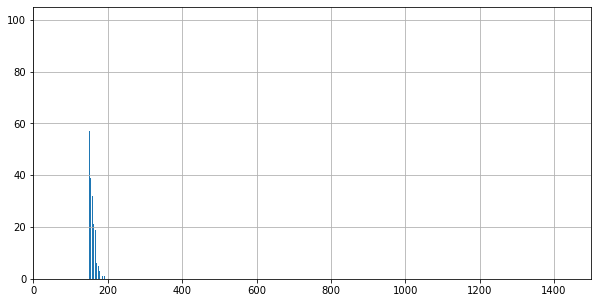

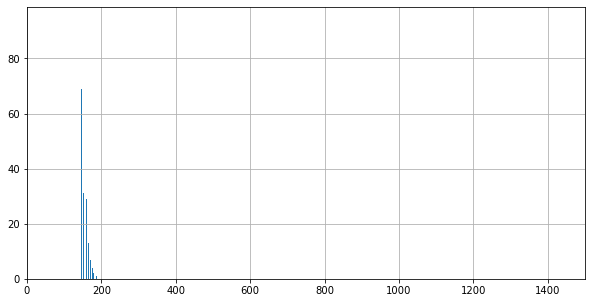

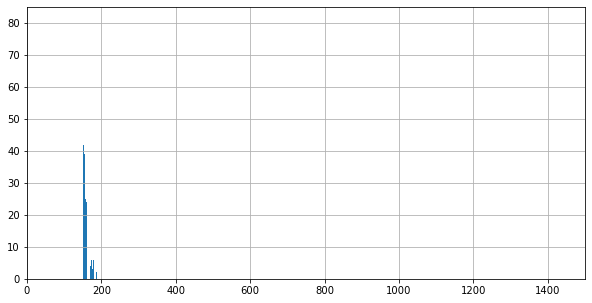

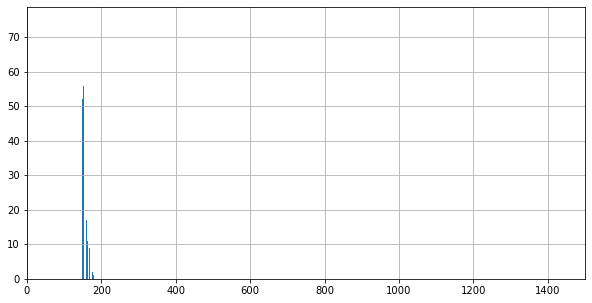

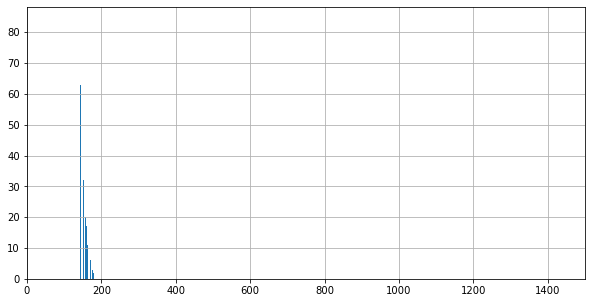

sample: slide_bmgsp_fov_03


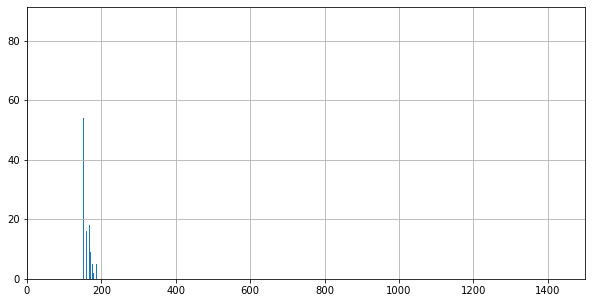

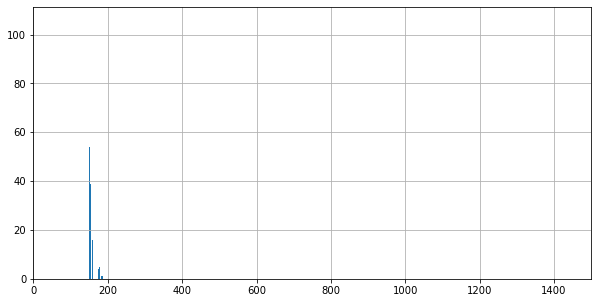

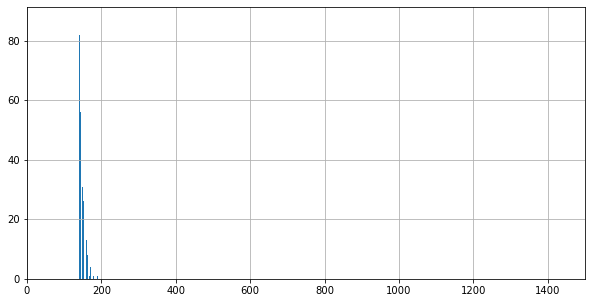

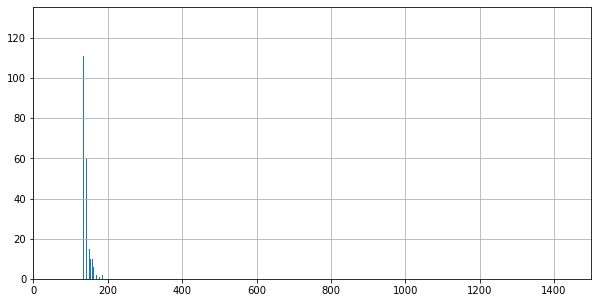

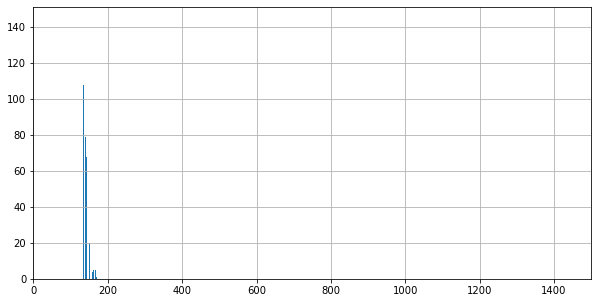

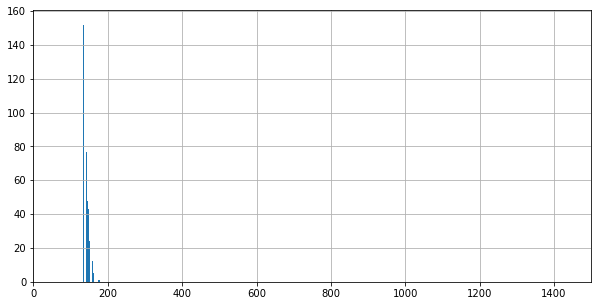

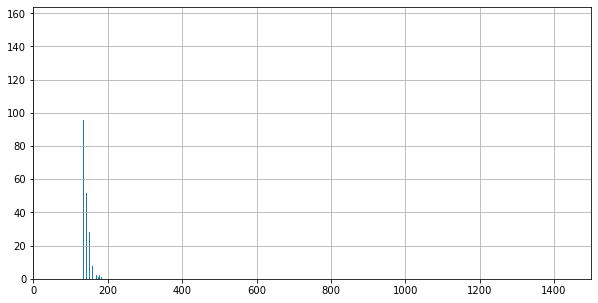

In [103]:
# counts = []
xlims=(0,1500)
for fn in filenames:
    sample_name = re.sub('2023_09_12_sapp05_spades08_','',os.path.split(fn)[1])
    sample_name = re.sub('_mode_airy_Airyscan\ Processing.czi','',sample_name)
    print('sample:', sample_name)
    czi = aplc.CziFile(fn)
    dims = czi.get_dims_shape()[0]
    counts_fov = []
    if 'M' in czi.dims:
        ms = dims['M'][1]
        if 'Z' in czi.dims:
            zs = dims['Z'][1] 
            for m in range(ms):
                for z in range(zs):
                    im, shp = czi.read_image(M=m, Z=z)
                    im_spot = get_spot_im(im)
                    counts_fov.append(count_spots(im_spot, snr=False, xlims=xlims))           
    elif 'Z' in czi.dims:
        zs = dims['Z'][1] 
        for z in range(zs):
            im, shp = czi.read_image(Z=z)
            im_spot = get_spot_im(im)
            counts_fov.append(count_spots(im_spot, snr=False, xlims=xlims))
    else:
        im, shp = czi.read_image()
        im_spot = get_spot_im(im)
        counts_fov.append(count_spots(im_spot, snr=False, xlims=xlims))
    counts.append(counts_fov)